##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5). This is an advanced example that assumes some knowledge of:

* Sequence to sequence models
* TensorFlow fundamentals below the keras layer: 
  * Working with tensors directly 
  * Writing custom `keras.Model`s and `keras.layers`

While this architecture is somewhat outdated it is still a very useful project to work through to get a deeper understanding of attention mechanisms (before going on to [Transformers](transformers.ipynb)).

After training the model in this notebook, you will be able to input a Spanish sentence, such as "*¿todavia estan en casa?*", and return the English translation: "*are you still at home?*"

The resulting model is exportable as a `tf.saved_model`, so it can be used in other TensorFlow environments.

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

## Setup

In [2]:
!pip install tensorflow_text

  Using cached tensorflow_text-2.5.0-cp37-cp37m-manylinux1_x86_64.whl (4.3 MB)


In [3]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

This tutorial builds a few layers from scratch, use this variable if you want to switch between the custom and builtin implementations.

In [4]:
use_builtins = True

This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial. 


In [5]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but we'll use the English-Spanish dataset.

### Download and prepare the dataset

For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [6]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

   8192/2638744 [..............................] - ETA: 0s

2646016/2638744 [==============================] - 0s 0us/step


In [7]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [8]:
targ, inp = load_data(path_to_file)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [9]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [10]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [11]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Detesto jugar a las cartas.'
 b'\xc3\x89l est\xc3\xa1 teniendo una aventura con su secretaria.'
 b'Tom le dijo a Mary lo que hab\xc3\xada visto en televisi\xc3\xb3n.'
 b'Pens\xc3\xa9 que Mar\xc3\xada a\xc3\xban me amaba.'
 b'El hu\xc3\xa9rfano se reuni\xc3\xb3 con sus dos hermanas cuando ten\xc3\xada cinco a\xc3\xb1os.'], shape=(5,), dtype=string)

tf.Tensor(
[b'I hate playing cards.' b'He is having an affair with his secretary.'
 b"Tom told Mary what he'd seen on TV." b'I thought Mary still loved me.'
 b'The orphan met up with his two sisters when he was five years old.'], shape=(5,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and retrun `tf.string` outputs: All the text processing happens inside the model. 

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensroflow_text` package contains a unicode normalize operation:

In [12]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [13]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

This standardization function will be wrapped up in a `preprocessing.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [15]:
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

The `TextVectorization` layer and many other `experimental.preprocessing` layers have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fix`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:  

In [16]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [17]:
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Now these layers can convert a batch of strings into a batch of token IDs:

In [18]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2, 2053,  319,    8,   34,  930,    4,    3,    0,    0],
       [   2,    7,   20, 2381,   23,    1,   27,   25, 3693,    4],
       [   2,   10,   28,   92,    8,   32,   22,    5,  103,  218]])>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [19]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] detesto jugar a las cartas . [END]            '

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

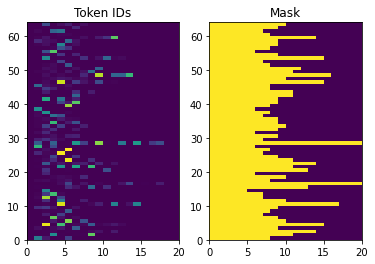

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

## The encoder/decoder model

The following diagram shows an overview of the model. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word. The diagram and formulas are from [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">


Before getting into it define a few constants for the model:

In [21]:
embedding_dim = 256
units = 1024

### The encoder

Start by building the encoder, the blue part of the diagram above.

The encoder:

1. Takes a list of token IDs (from `input_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a `layers.GRU`).
5. Returns:
  * The processed sequence. This will be passed to the attention head.
  * The internal state. This will be used to initialize the decoder


In [22]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

Here is how it fits together so far:

In [23]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 1024)
Encoder state, shape (batch, units): (64, 1024)


The encoder returns its internal state so that its state can be used to initialize the decoder.

It's also common for an RNN to return its state so that it can process a sequence over multiple calls. You'll see more of that building the decoder.

### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a _weighted_ average.

Let's look at how this works:

<img src="images/attention_equation_1.jpg" alt="attention equation 1" width="800">

<img src="images/attention_equation_2.jpg" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.


Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="images/attention_equation_4.jpg" alt="attention equation 4" width="800">

This tutorial uses [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf). TensorFlow includes implementations of both as `layers.Attention` and
`layers.AdditiveAttention`. The class below handles the weight matrices in a pair of `layers.Dense` layers, and calls the builtin implementation.

In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### Test the Attention layer

Create a `BahdanauAttention` layer:

In [25]:
attention_layer = BahdanauAttention(units)

This layer takes 3 inputs:

* The `query`: This will be generated by the decoder, later.
* The `value`: This Will be the output of the encoder.
* The `mask`: To exclude the padding, `example_tokens != 0`

In [26]:
(example_tokens != 0).shape

TensorShape([64, 20])

The vectorized implementation of the attention layer lets you pass a batch of sequences of query vectors and a batch of sequence of value vectors. The result is:

1. A batch of sequences of result vectors the size of the queries.
2. A batch attention maps, with size `(query_length, value_length)`.

In [27]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 20)


The attention weights should sum to `1.0` for each sequence.

Here are the attention weights across the sequences at `t=0`:

Text(0.5, 1.0, 'Mask')

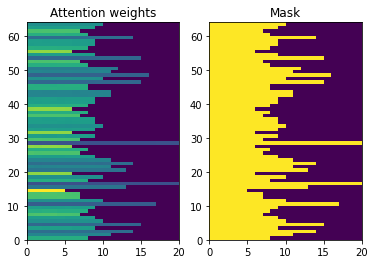

In [28]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


Because of the small-random initialization the attention weights are all close to `1/(sequence_length)`. If you zoom in on the weights for a single sequence, you can see that there is some _small_ variation that the model can learn to expand, and exploit.

In [29]:
attention_weights.shape

TensorShape([64, 2, 20])

In [30]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

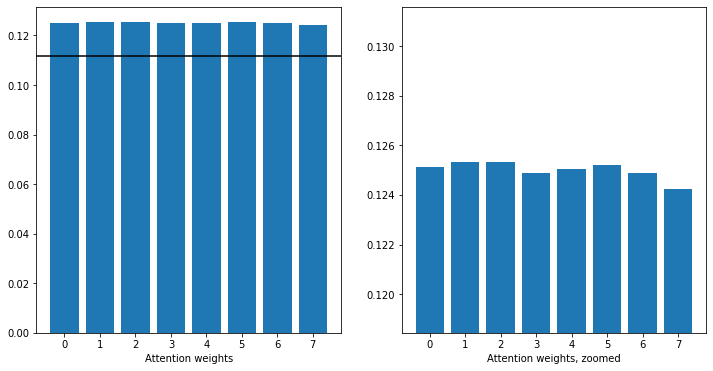

In [31]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

### The decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

<img src="images/attention_equation_3.jpg" alt="attention equation 3" width="800">


Here is the `Decoder` class and its initializer. The initializer creates all the necessary layers.

In [32]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

The `call` method for this layer takes and returns multiple tensors. Organize those into simple container classes:

In [33]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

Here is the implementation of the `call` method:

In [34]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [35]:
Decoder.call = call

The **encoder** processes its full input sequence with a single call to its RNN. This implementation of the **decoder** _can_ do that as well for efficient training. But this tutorial will run the decoder in a loop for a few reasons:

* Flexibility: Writing the loop gives you direct control over the training procedure.
* Clarity: It's possible to do masking tricks and use `layers.RNN`, or `tfa.seq2seq` APIs to pack this all into a single call. But writing it out as a loop may be clearer. 
  * Loop free training is demonstrated in the [Text generation](text_generation.ipynb) tutiorial.


Now try using this decoder.

In [36]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

The decoder takes 4 inputs.

* `new_tokens` -  The last token generated. Initialize the decoder with the `"[START]"` token.
* `enc_output` - Generated by the `Encoder`.
* `mask` - A boolean tensor indicating where `tokens != 0`
* `state` - The previous `state` output from the decoder (the internal state
  of the decoder's RNN). Pass `None` to zero-initialize it. The original
  paper initializes it from the encoder's final RNN state. 

In [37]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor._index_lookup_layer('[START]').numpy()
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [38]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


Sample a token according to the logits:

In [39]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

Decode the token as the first word of the output:

In [40]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['sounds'],
       ['does'],
       ['valid'],
       ['international'],
       ['loudly']], dtype='<U16')

Now use the decoder to generate a second set of logits.

- Pass the same `enc_output` and `mask`, these haven't changed.
- Pass the sampled token as `new_tokens`.
- Pass the `decoder_state` the decoder returned last time, so the RNN continues with a memory of where it left off last time.


In [41]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [42]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['fact'],
       ['worthless'],
       ['communicate'],
       ['darker'],
       ['plates']], dtype='<U16')

## Training

Now that you have all the model components, it's time to start training the model. You'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Define the loss function

In [43]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### Implement the training step

Start with a model class, the training process will be implemented as the `train_step` method on this model. See [Customizing fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details.

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

In [44]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks. 
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss. 
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

The `_preprocess` method, added below, implements steps #1 and #2: 

In [45]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [46]:
TrainTranslator._preprocess = _preprocess

The `_train_step` method, added below, handles the remaining steps except for actually running the decoder: 

In [47]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target the target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [48]:
TrainTranslator._train_step = _train_step

The `_loop_step` method, added below, executes the decoder and calculates the incremental loss and new decoder state (`dec_state`).

In [49]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [50]:
TrainTranslator._loop_step = _loop_step

### Test the training step

Build a `TrainTranslator`, and configure it for training using the `Model.compile` method:

In [51]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

Test out the `train_step`. For a text model like this the loss should start near:

In [52]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [53]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.637956>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6078267>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5514717>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.388698>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.7904134>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.087918>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8723435>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.475624>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2487626>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.150057>}

CPU times: user 5.24 s, sys: 187 ms, total: 5.43 s
Wall time: 4.94 s


While it's easier to debug without a `tf.function` it does give a performance boost. So now that the `_train_step` method is working, try the `tf.function`-wrapped `_tf_train_step`, to maximize performance while training:

In [54]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [55]:
TrainTranslator._tf_train_step = _tf_train_step

In [56]:
translator.use_tf_function = True

The first call will be slow, because it traces the function.

In [57]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1792917>}

But after that it's usually 2-3x faster than the eager `train_step` method:

In [58]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1361>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0575933>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9899843>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8948655>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7954547>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7969203>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7787275>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7324097>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.72061>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6613982>}

CPU times: user 5.06 s, sys: 1.16 s, total: 6.22 s
Wall time: 1.86 s


A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.


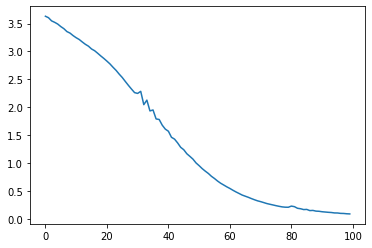

In [59]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

In [60]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [61]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [62]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3


   1/1859 [..............................] - ETA: 2:28:32 - batch_loss: 7.5947

   2/1859 [..............................] - ETA: 7:12 - batch_loss: 7.5881   

   3/1859 [..............................] - ETA: 6:37 - batch_loss: 7.5551

   4/1859 [..............................] - ETA: 5:59 - batch_loss: 7.5121

   5/1859 [..............................] - ETA: 6:52 - batch_loss: 7.4160

   6/1859 [..............................] - ETA: 6:42 - batch_loss: 7.1026

   7/1859 [..............................] - ETA: 6:19 - batch_loss: 6.9827

   8/1859 [..............................] - ETA: 6:07 - batch_loss: 6.7470

   9/1859 [..............................] - ETA: 5:59 - batch_loss: 6.6159

  10/1859 [..............................] - ETA: 6:14 - batch_loss: 6.4696

  11/1859 [..............................] - ETA: 6:18 - batch_loss: 6.3575

  12/1859 [..............................] - ETA: 6:11 - batch_loss: 6.2411

  13/1859 [..............................] - ETA: 6:09 - batch_loss: 6.1462

  14/1859 [..............................] - ETA: 6:05 - batch_loss: 6.0609

  15/1859 [..............................] - ETA: 6:09 - batch_loss: 5.9946

  16/1859 [..............................] - ETA: 6:06 - batch_loss: 5.9356

  17/1859 [..............................] - ETA: 6:06 - batch_loss: 5.8659

  18/1859 [..............................] - ETA: 6:04 - batch_loss: 5.8059

  19/1859 [..............................] - ETA: 6:05 - batch_loss: 5.7444

  20/1859 [..............................] - ETA: 5:57 - batch_loss: 5.6934

  21/1859 [..............................] - ETA: 5:53 - batch_loss: 5.6358

  22/1859 [..............................] - ETA: 5:51 - batch_loss: 5.5982

  23/1859 [..............................] - ETA: 5:53 - batch_loss: 5.5648

  24/1859 [..............................] - ETA: 5:50 - batch_loss: 5.5270

  25/1859 [..............................] - ETA: 5:47 - batch_loss: 5.4909

  26/1859 [..............................] - ETA: 5:46 - batch_loss: 5.4533

  27/1859 [..............................] - ETA: 5:43 - batch_loss: 5.4151

  28/1859 [..............................] - ETA: 5:41 - batch_loss: 5.3826

  29/1859 [..............................] - ETA: 5:39 - batch_loss: 5.3568

  30/1859 [..............................] - ETA: 5:37 - batch_loss: 5.3224

  31/1859 [..............................] - ETA: 5:37 - batch_loss: 5.2970

  32/1859 [..............................] - ETA: 5:37 - batch_loss: 5.2745

  33/1859 [..............................] - ETA: 5:36 - batch_loss: 5.2449

  34/1859 [..............................] - ETA: 5:34 - batch_loss: 5.2213

  35/1859 [..............................] - ETA: 5:33 - batch_loss: 5.1962

  36/1859 [..............................] - ETA: 5:32 - batch_loss: 5.1745

  37/1859 [..............................] - ETA: 5:32 - batch_loss: 5.1527

  38/1859 [..............................] - ETA: 5:34 - batch_loss: 5.1337

  39/1859 [..............................] - ETA: 5:35 - batch_loss: 5.1125

  40/1859 [..............................] - ETA: 5:40 - batch_loss: 5.0949

  41/1859 [..............................] - ETA: 5:40 - batch_loss: 5.0774

  42/1859 [..............................] - ETA: 5:38 - batch_loss: 5.0611

  43/1859 [..............................] - ETA: 5:38 - batch_loss: 5.0437

  44/1859 [..............................] - ETA: 5:39 - batch_loss: 5.0284

  45/1859 [..............................] - ETA: 5:37 - batch_loss: 5.0112

  46/1859 [..............................] - ETA: 5:37 - batch_loss: 5.0000

  47/1859 [..............................] - ETA: 5:36 - batch_loss: 4.9821

  48/1859 [..............................] - ETA: 5:35 - batch_loss: 4.9692

  49/1859 [..............................] - ETA: 5:34 - batch_loss: 4.9517

  50/1859 [..............................] - ETA: 5:33 - batch_loss: 4.9366

  51/1859 [..............................] - ETA: 5:35 - batch_loss: 4.9257

  52/1859 [..............................] - ETA: 5:33 - batch_loss: 4.9126

  53/1859 [..............................] - ETA: 5:35 - batch_loss: 4.8994

  54/1859 [..............................] - ETA: 5:35 - batch_loss: 4.8886

  55/1859 [..............................] - ETA: 5:34 - batch_loss: 4.8750

  56/1859 [..............................] - ETA: 5:33 - batch_loss: 4.8662

  57/1859 [..............................] - ETA: 5:37 - batch_loss: 4.8590

  58/1859 [..............................] - ETA: 5:36 - batch_loss: 4.8490

  59/1859 [..............................] - ETA: 5:37 - batch_loss: 4.8380

  60/1859 [..............................] - ETA: 5:37 - batch_loss: 4.8253

  61/1859 [..............................] - ETA: 5:38 - batch_loss: 4.8153

  62/1859 [>.............................] - ETA: 5:38 - batch_loss: 4.8054

  63/1859 [>.............................] - ETA: 5:38 - batch_loss: 4.7939

  64/1859 [>.............................] - ETA: 5:37 - batch_loss: 4.7819

  65/1859 [>.............................] - ETA: 5:37 - batch_loss: 4.7723

  66/1859 [>.............................] - ETA: 5:37 - batch_loss: 4.7606

  67/1859 [>.............................] - ETA: 5:37 - batch_loss: 4.7517

  68/1859 [>.............................] - ETA: 5:36 - batch_loss: 4.7435

  69/1859 [>.............................] - ETA: 5:35 - batch_loss: 4.7340

  70/1859 [>.............................] - ETA: 5:35 - batch_loss: 4.7239

  71/1859 [>.............................] - ETA: 5:34 - batch_loss: 4.7152

  72/1859 [>.............................] - ETA: 5:34 - batch_loss: 4.7074

  73/1859 [>.............................] - ETA: 5:33 - batch_loss: 4.6995

  74/1859 [>.............................] - ETA: 5:33 - batch_loss: 4.6910

  75/1859 [>.............................] - ETA: 5:34 - batch_loss: 4.6825

  76/1859 [>.............................] - ETA: 5:35 - batch_loss: 4.6761

  77/1859 [>.............................] - ETA: 5:35 - batch_loss: 4.6670

  78/1859 [>.............................] - ETA: 5:34 - batch_loss: 4.6578

  79/1859 [>.............................] - ETA: 5:34 - batch_loss: 4.6520

  80/1859 [>.............................] - ETA: 5:35 - batch_loss: 4.6463

  81/1859 [>.............................] - ETA: 5:34 - batch_loss: 4.6379

  82/1859 [>.............................] - ETA: 5:33 - batch_loss: 4.6313

  83/1859 [>.............................] - ETA: 5:34 - batch_loss: 4.6250

  84/1859 [>.............................] - ETA: 5:33 - batch_loss: 4.6162

  85/1859 [>.............................] - ETA: 5:32 - batch_loss: 4.6091

  86/1859 [>.............................] - ETA: 5:32 - batch_loss: 4.6017

  87/1859 [>.............................] - ETA: 5:32 - batch_loss: 4.5971

  88/1859 [>.............................] - ETA: 5:31 - batch_loss: 4.5919

  89/1859 [>.............................] - ETA: 5:30 - batch_loss: 4.5824

  90/1859 [>.............................] - ETA: 5:30 - batch_loss: 4.5757

  91/1859 [>.............................] - ETA: 5:29 - batch_loss: 4.5677

  92/1859 [>.............................] - ETA: 5:29 - batch_loss: 4.5608

  93/1859 [>.............................] - ETA: 5:29 - batch_loss: 4.5574

  94/1859 [>.............................] - ETA: 5:29 - batch_loss: 4.5525

  95/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.5447

  96/1859 [>.............................] - ETA: 5:29 - batch_loss: 4.5394

  97/1859 [>.............................] - ETA: 5:28 - batch_loss: 4.5337

  98/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.5301

  99/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.5271

 100/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.5233

 101/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.5182

 102/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.5142

 103/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.5091

 104/1859 [>.............................] - ETA: 5:27 - batch_loss: 4.5025

 105/1859 [>.............................] - ETA: 5:26 - batch_loss: 4.4982

 106/1859 [>.............................] - ETA: 5:25 - batch_loss: 4.4928

 107/1859 [>.............................] - ETA: 5:25 - batch_loss: 4.4874

 108/1859 [>.............................] - ETA: 5:25 - batch_loss: 4.4817

 109/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4768

 110/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4728

 111/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4691

 112/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4629

 113/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4571

 114/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4531

 115/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4495

 116/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4451

 117/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4394

 118/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4340

 119/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4305

 120/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4256

 121/1859 [>.............................] - ETA: 5:23 - batch_loss: 4.4209

 122/1859 [>.............................] - ETA: 5:25 - batch_loss: 4.4169

 123/1859 [>.............................] - ETA: 5:24 - batch_loss: 4.4118

 124/1859 [=>............................] - ETA: 5:24 - batch_loss: 4.4082

 125/1859 [=>............................] - ETA: 5:24 - batch_loss: 4.4032

 126/1859 [=>............................] - ETA: 5:24 - batch_loss: 4.3986

 127/1859 [=>............................] - ETA: 5:24 - batch_loss: 4.3939

 128/1859 [=>............................] - ETA: 5:23 - batch_loss: 4.3898

 129/1859 [=>............................] - ETA: 5:23 - batch_loss: 4.3873

 130/1859 [=>............................] - ETA: 5:23 - batch_loss: 4.3828

 131/1859 [=>............................] - ETA: 5:23 - batch_loss: 4.3773

 132/1859 [=>............................] - ETA: 5:23 - batch_loss: 4.3747

 133/1859 [=>............................] - ETA: 5:22 - batch_loss: 4.3700

 134/1859 [=>............................] - ETA: 5:22 - batch_loss: 4.3643

 135/1859 [=>............................] - ETA: 5:22 - batch_loss: 4.3620

 136/1859 [=>............................] - ETA: 5:22 - batch_loss: 4.3589

 137/1859 [=>............................] - ETA: 5:22 - batch_loss: 4.3559

 138/1859 [=>............................] - ETA: 5:22 - batch_loss: 4.3527

 139/1859 [=>............................] - ETA: 5:21 - batch_loss: 4.3491

 140/1859 [=>............................] - ETA: 5:21 - batch_loss: 4.3450

 141/1859 [=>............................] - ETA: 5:21 - batch_loss: 4.3399

 142/1859 [=>............................] - ETA: 5:21 - batch_loss: 4.3369

 143/1859 [=>............................] - ETA: 5:21 - batch_loss: 4.3337

 144/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3297

 145/1859 [=>............................] - ETA: 5:21 - batch_loss: 4.3263

 146/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3223

 147/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3181

 148/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3151

 149/1859 [=>............................] - ETA: 5:21 - batch_loss: 4.3109

 150/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.3073

 151/1859 [=>............................] - ETA: 5:21 - batch_loss: 4.3038

 152/1859 [=>............................] - ETA: 5:21 - batch_loss: 4.2995

 153/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.2948

 154/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.2919

 155/1859 [=>............................] - ETA: 5:20 - batch_loss: 4.2875

 156/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.2857

 157/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.2825

 158/1859 [=>............................] - ETA: 5:19 - batch_loss: 4.2787

 159/1859 [=>............................] - ETA: 5:18 - batch_loss: 4.2749

 160/1859 [=>............................] - ETA: 5:18 - batch_loss: 4.2714

 161/1859 [=>............................] - ETA: 5:18 - batch_loss: 4.2675

 162/1859 [=>............................] - ETA: 5:17 - batch_loss: 4.2636

 163/1859 [=>............................] - ETA: 5:17 - batch_loss: 4.2613

 164/1859 [=>............................] - ETA: 5:17 - batch_loss: 4.2587

 165/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2545

 166/1859 [=>............................] - ETA: 5:17 - batch_loss: 4.2503

 167/1859 [=>............................] - ETA: 5:17 - batch_loss: 4.2466

 168/1859 [=>............................] - ETA: 5:17 - batch_loss: 4.2438

 169/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2406

 170/1859 [=>............................] - ETA: 5:17 - batch_loss: 4.2376

 171/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2333

 172/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2299

 173/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2267

 174/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2231

 175/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2209

 176/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2177

 177/1859 [=>............................] - ETA: 5:16 - batch_loss: 4.2143

 178/1859 [=>............................] - ETA: 5:15 - batch_loss: 4.2113

 179/1859 [=>............................] - ETA: 5:15 - batch_loss: 4.2085

 180/1859 [=>............................] - ETA: 5:15 - batch_loss: 4.2059

 181/1859 [=>............................] - ETA: 5:15 - batch_loss: 4.2028

 182/1859 [=>............................] - ETA: 5:15 - batch_loss: 4.2001

 183/1859 [=>............................] - ETA: 5:15 - batch_loss: 4.1972

 184/1859 [=>............................] - ETA: 5:15 - batch_loss: 4.1942

 185/1859 [=>............................] - ETA: 5:15 - batch_loss: 4.1910

 186/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1872

 187/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1843

 188/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1825

 189/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1807

 190/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1777

 191/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1742

 192/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1712

 193/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1690

 194/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1660

 195/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1631

 196/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1622

 197/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1591

 198/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1575

 199/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1548

 200/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1512

 201/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1482

 202/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1457

 203/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1428

 204/1859 [==>...........................] - ETA: 5:15 - batch_loss: 4.1402

 205/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1375

 206/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1333

 207/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1303

 208/1859 [==>...........................] - ETA: 5:14 - batch_loss: 4.1272

 209/1859 [==>...........................] - ETA: 5:13 - batch_loss: 4.1242

 210/1859 [==>...........................] - ETA: 5:13 - batch_loss: 4.1210

 211/1859 [==>...........................] - ETA: 5:13 - batch_loss: 4.1184

 212/1859 [==>...........................] - ETA: 5:13 - batch_loss: 4.1153

 213/1859 [==>...........................] - ETA: 5:13 - batch_loss: 4.1122

 214/1859 [==>...........................] - ETA: 5:12 - batch_loss: 4.1093

 215/1859 [==>...........................] - ETA: 5:12 - batch_loss: 4.1061

 216/1859 [==>...........................] - ETA: 5:12 - batch_loss: 4.1028

 217/1859 [==>...........................] - ETA: 5:13 - batch_loss: 4.1012

 218/1859 [==>...........................] - ETA: 5:13 - batch_loss: 4.0984

 219/1859 [==>...........................] - ETA: 5:12 - batch_loss: 4.0947

 220/1859 [==>...........................] - ETA: 5:12 - batch_loss: 4.0911

 221/1859 [==>...........................] - ETA: 5:12 - batch_loss: 4.0876

 222/1859 [==>...........................] - ETA: 5:12 - batch_loss: 4.0838

 223/1859 [==>...........................] - ETA: 5:12 - batch_loss: 4.0817

 224/1859 [==>...........................] - ETA: 5:12 - batch_loss: 4.0794

 225/1859 [==>...........................] - ETA: 5:11 - batch_loss: 4.0764

 226/1859 [==>...........................] - ETA: 5:11 - batch_loss: 4.0736

 227/1859 [==>...........................] - ETA: 5:11 - batch_loss: 4.0707

 228/1859 [==>...........................] - ETA: 5:10 - batch_loss: 4.0683

 229/1859 [==>...........................] - ETA: 5:10 - batch_loss: 4.0653

 230/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.0615

 231/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.0581

 232/1859 [==>...........................] - ETA: 5:09 - batch_loss: 4.0557

 233/1859 [==>...........................] - ETA: 5:08 - batch_loss: 4.0536

 234/1859 [==>...........................] - ETA: 5:08 - batch_loss: 4.0513

 235/1859 [==>...........................] - ETA: 5:08 - batch_loss: 4.0489

 236/1859 [==>...........................] - ETA: 5:08 - batch_loss: 4.0465

 237/1859 [==>...........................] - ETA: 5:08 - batch_loss: 4.0439

 238/1859 [==>...........................] - ETA: 5:08 - batch_loss: 4.0400

 239/1859 [==>...........................] - ETA: 5:07 - batch_loss: 4.0363

 240/1859 [==>...........................] - ETA: 5:07 - batch_loss: 4.0342

 241/1859 [==>...........................] - ETA: 5:07 - batch_loss: 4.0310

 242/1859 [==>...........................] - ETA: 5:06 - batch_loss: 4.0277

 243/1859 [==>...........................] - ETA: 5:06 - batch_loss: 4.0246

 244/1859 [==>...........................] - ETA: 5:06 - batch_loss: 4.0218

 245/1859 [==>...........................] - ETA: 5:05 - batch_loss: 4.0198

 246/1859 [==>...........................] - ETA: 5:05 - batch_loss: 4.0174

 247/1859 [==>...........................] - ETA: 5:05 - batch_loss: 4.0146

 248/1859 [===>..........................] - ETA: 5:04 - batch_loss: 4.0116

 249/1859 [===>..........................] - ETA: 5:04 - batch_loss: 4.0085

 250/1859 [===>..........................] - ETA: 5:04 - batch_loss: 4.0064

 251/1859 [===>..........................] - ETA: 5:04 - batch_loss: 4.0034

 252/1859 [===>..........................] - ETA: 5:04 - batch_loss: 4.0008

 253/1859 [===>..........................] - ETA: 5:03 - batch_loss: 3.9979

 254/1859 [===>..........................] - ETA: 5:03 - batch_loss: 3.9958

 255/1859 [===>..........................] - ETA: 5:03 - batch_loss: 3.9932

 256/1859 [===>..........................] - ETA: 5:03 - batch_loss: 3.9906

 257/1859 [===>..........................] - ETA: 5:03 - batch_loss: 3.9873

 258/1859 [===>..........................] - ETA: 5:03 - batch_loss: 3.9846

 259/1859 [===>..........................] - ETA: 5:03 - batch_loss: 3.9821

 260/1859 [===>..........................] - ETA: 5:02 - batch_loss: 3.9799

 261/1859 [===>..........................] - ETA: 5:03 - batch_loss: 3.9773

 262/1859 [===>..........................] - ETA: 5:02 - batch_loss: 3.9755

 263/1859 [===>..........................] - ETA: 5:02 - batch_loss: 3.9727

 264/1859 [===>..........................] - ETA: 5:02 - batch_loss: 3.9697

 265/1859 [===>..........................] - ETA: 5:02 - batch_loss: 3.9665

 266/1859 [===>..........................] - ETA: 5:02 - batch_loss: 3.9644

 267/1859 [===>..........................] - ETA: 5:01 - batch_loss: 3.9619

 268/1859 [===>..........................] - ETA: 5:01 - batch_loss: 3.9594

 269/1859 [===>..........................] - ETA: 5:01 - batch_loss: 3.9567

 270/1859 [===>..........................] - ETA: 5:01 - batch_loss: 3.9536

 271/1859 [===>..........................] - ETA: 5:01 - batch_loss: 3.9501

 272/1859 [===>..........................] - ETA: 5:00 - batch_loss: 3.9478

 273/1859 [===>..........................] - ETA: 5:00 - batch_loss: 3.9455

 274/1859 [===>..........................] - ETA: 5:00 - batch_loss: 3.9426

 275/1859 [===>..........................] - ETA: 4:59 - batch_loss: 3.9399

 276/1859 [===>..........................] - ETA: 5:00 - batch_loss: 3.9370

 277/1859 [===>..........................] - ETA: 4:59 - batch_loss: 3.9345

 278/1859 [===>..........................] - ETA: 4:59 - batch_loss: 3.9324

 279/1859 [===>..........................] - ETA: 4:59 - batch_loss: 3.9297

 280/1859 [===>..........................] - ETA: 4:59 - batch_loss: 3.9265

 281/1859 [===>..........................] - ETA: 4:58 - batch_loss: 3.9232

 282/1859 [===>..........................] - ETA: 4:58 - batch_loss: 3.9211

 283/1859 [===>..........................] - ETA: 4:58 - batch_loss: 3.9190

 284/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9166

 285/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9152

 286/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9125

 287/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9106

 288/1859 [===>..........................] - ETA: 4:57 - batch_loss: 3.9072

 289/1859 [===>..........................] - ETA: 4:56 - batch_loss: 3.9048

 290/1859 [===>..........................] - ETA: 4:56 - batch_loss: 3.9022

 291/1859 [===>..........................] - ETA: 4:56 - batch_loss: 3.8997

 292/1859 [===>..........................] - ETA: 4:56 - batch_loss: 3.8971

 293/1859 [===>..........................] - ETA: 4:56 - batch_loss: 3.8950

 294/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.8926

 295/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.8900

 296/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.8875

 297/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.8853

 298/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.8822

 299/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.8798

 300/1859 [===>..........................] - ETA: 4:55 - batch_loss: 3.8776

 301/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.8749

 302/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.8727

 303/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.8706

 304/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.8685

 305/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.8663

 306/1859 [===>..........................] - ETA: 4:54 - batch_loss: 3.8645

 307/1859 [===>..........................] - ETA: 4:53 - batch_loss: 3.8624

 308/1859 [===>..........................] - ETA: 4:53 - batch_loss: 3.8608

 309/1859 [===>..........................] - ETA: 4:53 - batch_loss: 3.8579

 310/1859 [====>.........................] - ETA: 4:53 - batch_loss: 3.8548

 311/1859 [====>.........................] - ETA: 4:52 - batch_loss: 3.8528

 312/1859 [====>.........................] - ETA: 4:53 - batch_loss: 3.8509

 313/1859 [====>.........................] - ETA: 4:52 - batch_loss: 3.8482

 314/1859 [====>.........................] - ETA: 4:52 - batch_loss: 3.8455

 315/1859 [====>.........................] - ETA: 4:52 - batch_loss: 3.8437

 316/1859 [====>.........................] - ETA: 4:52 - batch_loss: 3.8420

 317/1859 [====>.........................] - ETA: 4:52 - batch_loss: 3.8405

 318/1859 [====>.........................] - ETA: 4:51 - batch_loss: 3.8382

 319/1859 [====>.........................] - ETA: 4:51 - batch_loss: 3.8357

 320/1859 [====>.........................] - ETA: 4:51 - batch_loss: 3.8327

 321/1859 [====>.........................] - ETA: 4:51 - batch_loss: 3.8304

 322/1859 [====>.........................] - ETA: 4:51 - batch_loss: 3.8281

 323/1859 [====>.........................] - ETA: 4:50 - batch_loss: 3.8250

 324/1859 [====>.........................] - ETA: 4:51 - batch_loss: 3.8234

 325/1859 [====>.........................] - ETA: 4:51 - batch_loss: 3.8214

 326/1859 [====>.........................] - ETA: 4:51 - batch_loss: 3.8185

 327/1859 [====>.........................] - ETA: 4:50 - batch_loss: 3.8167

 328/1859 [====>.........................] - ETA: 4:51 - batch_loss: 3.8141

 329/1859 [====>.........................] - ETA: 4:50 - batch_loss: 3.8117

 330/1859 [====>.........................] - ETA: 4:50 - batch_loss: 3.8098

 331/1859 [====>.........................] - ETA: 4:50 - batch_loss: 3.8072

 332/1859 [====>.........................] - ETA: 4:50 - batch_loss: 3.8050

 333/1859 [====>.........................] - ETA: 4:50 - batch_loss: 3.8023

 334/1859 [====>.........................] - ETA: 4:50 - batch_loss: 3.8002

 335/1859 [====>.........................] - ETA: 4:50 - batch_loss: 3.7979

 336/1859 [====>.........................] - ETA: 4:49 - batch_loss: 3.7952

 337/1859 [====>.........................] - ETA: 4:49 - batch_loss: 3.7926

 338/1859 [====>.........................] - ETA: 4:49 - batch_loss: 3.7901

 339/1859 [====>.........................] - ETA: 4:49 - batch_loss: 3.7878

 340/1859 [====>.........................] - ETA: 4:49 - batch_loss: 3.7853

 341/1859 [====>.........................] - ETA: 4:49 - batch_loss: 3.7831

 342/1859 [====>.........................] - ETA: 4:49 - batch_loss: 3.7809

 343/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7787

 344/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7758

 345/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7738

 346/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7713

 347/1859 [====>.........................] - ETA: 4:48 - batch_loss: 3.7690

 348/1859 [====>.........................] - ETA: 4:47 - batch_loss: 3.7661

 349/1859 [====>.........................] - ETA: 4:47 - batch_loss: 3.7637

 350/1859 [====>.........................] - ETA: 4:47 - batch_loss: 3.7610

 351/1859 [====>.........................] - ETA: 4:47 - batch_loss: 3.7585

 352/1859 [====>.........................] - ETA: 4:46 - batch_loss: 3.7561

 353/1859 [====>.........................] - ETA: 4:46 - batch_loss: 3.7536

 354/1859 [====>.........................] - ETA: 4:46 - batch_loss: 3.7510

 355/1859 [====>.........................] - ETA: 4:46 - batch_loss: 3.7487

 356/1859 [====>.........................] - ETA: 4:45 - batch_loss: 3.7461

 357/1859 [====>.........................] - ETA: 4:45 - batch_loss: 3.7441

 358/1859 [====>.........................] - ETA: 4:45 - batch_loss: 3.7413

 359/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7386

 360/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7365

 361/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7337

 362/1859 [====>.........................] - ETA: 4:44 - batch_loss: 3.7314

 363/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7288

 364/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7266

 365/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7247

 366/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7214

 367/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7190

 368/1859 [====>.........................] - ETA: 4:43 - batch_loss: 3.7166

 369/1859 [====>.........................] - ETA: 4:42 - batch_loss: 3.7141

 370/1859 [====>.........................] - ETA: 4:42 - batch_loss: 3.7115

 371/1859 [====>.........................] - ETA: 4:42 - batch_loss: 3.7098

 372/1859 [=====>........................] - ETA: 4:42 - batch_loss: 3.7075

 373/1859 [=====>........................] - ETA: 4:42 - batch_loss: 3.7057

 374/1859 [=====>........................] - ETA: 4:41 - batch_loss: 3.7031

 375/1859 [=====>........................] - ETA: 4:41 - batch_loss: 3.7003

 376/1859 [=====>........................] - ETA: 4:41 - batch_loss: 3.6978

 377/1859 [=====>........................] - ETA: 4:41 - batch_loss: 3.6956

 378/1859 [=====>........................] - ETA: 4:40 - batch_loss: 3.6929

 379/1859 [=====>........................] - ETA: 4:40 - batch_loss: 3.6906

 380/1859 [=====>........................] - ETA: 4:40 - batch_loss: 3.6876

 381/1859 [=====>........................] - ETA: 4:40 - batch_loss: 3.6853

 382/1859 [=====>........................] - ETA: 4:40 - batch_loss: 3.6834

 383/1859 [=====>........................] - ETA: 4:40 - batch_loss: 3.6811

 384/1859 [=====>........................] - ETA: 4:39 - batch_loss: 3.6783

 385/1859 [=====>........................] - ETA: 4:39 - batch_loss: 3.6762

 386/1859 [=====>........................] - ETA: 4:39 - batch_loss: 3.6737

 387/1859 [=====>........................] - ETA: 4:39 - batch_loss: 3.6711

 388/1859 [=====>........................] - ETA: 4:39 - batch_loss: 3.6690

 389/1859 [=====>........................] - ETA: 4:38 - batch_loss: 3.6666

 390/1859 [=====>........................] - ETA: 4:38 - batch_loss: 3.6635

 391/1859 [=====>........................] - ETA: 4:38 - batch_loss: 3.6612

 392/1859 [=====>........................] - ETA: 4:38 - batch_loss: 3.6591

 393/1859 [=====>........................] - ETA: 4:38 - batch_loss: 3.6569

 394/1859 [=====>........................] - ETA: 4:38 - batch_loss: 3.6543

 395/1859 [=====>........................] - ETA: 4:38 - batch_loss: 3.6522

 396/1859 [=====>........................] - ETA: 4:38 - batch_loss: 3.6504

 397/1859 [=====>........................] - ETA: 4:38 - batch_loss: 3.6480

 398/1859 [=====>........................] - ETA: 4:37 - batch_loss: 3.6452

 399/1859 [=====>........................] - ETA: 4:37 - batch_loss: 3.6425

 400/1859 [=====>........................] - ETA: 4:37 - batch_loss: 3.6405

 401/1859 [=====>........................] - ETA: 4:36 - batch_loss: 3.6385

 402/1859 [=====>........................] - ETA: 4:36 - batch_loss: 3.6368

 403/1859 [=====>........................] - ETA: 4:36 - batch_loss: 3.6348

 404/1859 [=====>........................] - ETA: 4:36 - batch_loss: 3.6325

 405/1859 [=====>........................] - ETA: 4:35 - batch_loss: 3.6300

 406/1859 [=====>........................] - ETA: 4:35 - batch_loss: 3.6278

 407/1859 [=====>........................] - ETA: 4:35 - batch_loss: 3.6256

 408/1859 [=====>........................] - ETA: 4:35 - batch_loss: 3.6239

 409/1859 [=====>........................] - ETA: 4:35 - batch_loss: 3.6223

 410/1859 [=====>........................] - ETA: 4:34 - batch_loss: 3.6201

 411/1859 [=====>........................] - ETA: 4:34 - batch_loss: 3.6178

 412/1859 [=====>........................] - ETA: 4:34 - batch_loss: 3.6158

 413/1859 [=====>........................] - ETA: 4:34 - batch_loss: 3.6136

 414/1859 [=====>........................] - ETA: 4:33 - batch_loss: 3.6114

 415/1859 [=====>........................] - ETA: 4:33 - batch_loss: 3.6094

 416/1859 [=====>........................] - ETA: 4:33 - batch_loss: 3.6076

 417/1859 [=====>........................] - ETA: 4:33 - batch_loss: 3.6053

 418/1859 [=====>........................] - ETA: 4:33 - batch_loss: 3.6027

 419/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.6006

 420/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.5986

 421/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.5959

 422/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.5947

 423/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.5926

 424/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.5905

 425/1859 [=====>........................] - ETA: 4:32 - batch_loss: 3.5884

 426/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5859

 427/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5834

 428/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5812

 429/1859 [=====>........................] - ETA: 4:31 - batch_loss: 3.5795

 430/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5772

 431/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5749

 432/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5727

 433/1859 [=====>........................] - ETA: 4:30 - batch_loss: 3.5705

 434/1859 [======>.......................] - ETA: 4:30 - batch_loss: 3.5686

 435/1859 [======>.......................] - ETA: 4:30 - batch_loss: 3.5664

 436/1859 [======>.......................] - ETA: 4:29 - batch_loss: 3.5639

 437/1859 [======>.......................] - ETA: 4:29 - batch_loss: 3.5617

 438/1859 [======>.......................] - ETA: 4:29 - batch_loss: 3.5599

 439/1859 [======>.......................] - ETA: 4:29 - batch_loss: 3.5576

 440/1859 [======>.......................] - ETA: 4:29 - batch_loss: 3.5556

 441/1859 [======>.......................] - ETA: 4:28 - batch_loss: 3.5530

 442/1859 [======>.......................] - ETA: 4:28 - batch_loss: 3.5506

 443/1859 [======>.......................] - ETA: 4:28 - batch_loss: 3.5483

 444/1859 [======>.......................] - ETA: 4:28 - batch_loss: 3.5461

 445/1859 [======>.......................] - ETA: 4:28 - batch_loss: 3.5441

 446/1859 [======>.......................] - ETA: 4:27 - batch_loss: 3.5418

 447/1859 [======>.......................] - ETA: 4:27 - batch_loss: 3.5401

 448/1859 [======>.......................] - ETA: 4:28 - batch_loss: 3.5385

 449/1859 [======>.......................] - ETA: 4:27 - batch_loss: 3.5366

 450/1859 [======>.......................] - ETA: 4:27 - batch_loss: 3.5346

 451/1859 [======>.......................] - ETA: 4:27 - batch_loss: 3.5327

 452/1859 [======>.......................] - ETA: 4:27 - batch_loss: 3.5307

 453/1859 [======>.......................] - ETA: 4:27 - batch_loss: 3.5291

 454/1859 [======>.......................] - ETA: 4:26 - batch_loss: 3.5268

 455/1859 [======>.......................] - ETA: 4:26 - batch_loss: 3.5243

 456/1859 [======>.......................] - ETA: 4:26 - batch_loss: 3.5224

 457/1859 [======>.......................] - ETA: 4:26 - batch_loss: 3.5207

 458/1859 [======>.......................] - ETA: 4:26 - batch_loss: 3.5190

 459/1859 [======>.......................] - ETA: 4:25 - batch_loss: 3.5165

 460/1859 [======>.......................] - ETA: 4:25 - batch_loss: 3.5144

 461/1859 [======>.......................] - ETA: 4:25 - batch_loss: 3.5125

 462/1859 [======>.......................] - ETA: 4:24 - batch_loss: 3.5107

 463/1859 [======>.......................] - ETA: 4:24 - batch_loss: 3.5082

 464/1859 [======>.......................] - ETA: 4:24 - batch_loss: 3.5063

 465/1859 [======>.......................] - ETA: 4:24 - batch_loss: 3.5038

 466/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.5015

 467/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4997

 468/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4975

 469/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4955

 470/1859 [======>.......................] - ETA: 4:23 - batch_loss: 3.4932

 471/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4912

 472/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4893

 473/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4870

 474/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4844

 475/1859 [======>.......................] - ETA: 4:22 - batch_loss: 3.4826

 476/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4806

 477/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4785

 478/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4766

 479/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4743

 480/1859 [======>.......................] - ETA: 4:21 - batch_loss: 3.4717

 481/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4697

 482/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4676

 483/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4655

 484/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4633

 485/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4608

 486/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4586

 487/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4562

 488/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4542

 489/1859 [======>.......................] - ETA: 4:20 - batch_loss: 3.4515

 490/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4490

 491/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4461

 492/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4441

 493/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4418

 494/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4391

 495/1859 [======>.......................] - ETA: 4:19 - batch_loss: 3.4371

 496/1859 [=======>......................] - ETA: 4:18 - batch_loss: 3.4348

 497/1859 [=======>......................] - ETA: 4:18 - batch_loss: 3.4326

 498/1859 [=======>......................] - ETA: 4:18 - batch_loss: 3.4305

 499/1859 [=======>......................] - ETA: 4:18 - batch_loss: 3.4286

 500/1859 [=======>......................] - ETA: 4:18 - batch_loss: 3.4269

 501/1859 [=======>......................] - ETA: 4:18 - batch_loss: 3.4247

 502/1859 [=======>......................] - ETA: 4:17 - batch_loss: 3.4232

 503/1859 [=======>......................] - ETA: 4:17 - batch_loss: 3.4218

 504/1859 [=======>......................] - ETA: 4:17 - batch_loss: 3.4200

 505/1859 [=======>......................] - ETA: 4:17 - batch_loss: 3.4181

 506/1859 [=======>......................] - ETA: 4:17 - batch_loss: 3.4165

 507/1859 [=======>......................] - ETA: 4:17 - batch_loss: 3.4143

 508/1859 [=======>......................] - ETA: 4:16 - batch_loss: 3.4128

 509/1859 [=======>......................] - ETA: 4:16 - batch_loss: 3.4105

 510/1859 [=======>......................] - ETA: 4:16 - batch_loss: 3.4085

 511/1859 [=======>......................] - ETA: 4:16 - batch_loss: 3.4064

 512/1859 [=======>......................] - ETA: 4:16 - batch_loss: 3.4040

 513/1859 [=======>......................] - ETA: 4:15 - batch_loss: 3.4019

 514/1859 [=======>......................] - ETA: 4:15 - batch_loss: 3.3994

 515/1859 [=======>......................] - ETA: 4:15 - batch_loss: 3.3974

 516/1859 [=======>......................] - ETA: 4:15 - batch_loss: 3.3959

 517/1859 [=======>......................] - ETA: 4:15 - batch_loss: 3.3942

 518/1859 [=======>......................] - ETA: 4:15 - batch_loss: 3.3925

 519/1859 [=======>......................] - ETA: 4:14 - batch_loss: 3.3907

 520/1859 [=======>......................] - ETA: 4:14 - batch_loss: 3.3888

 521/1859 [=======>......................] - ETA: 4:14 - batch_loss: 3.3868

 522/1859 [=======>......................] - ETA: 4:14 - batch_loss: 3.3849

 523/1859 [=======>......................] - ETA: 4:14 - batch_loss: 3.3829

 524/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3808

 525/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3782

 526/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3759

 527/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3739

 528/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3718

 529/1859 [=======>......................] - ETA: 4:13 - batch_loss: 3.3696

 530/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3677

 531/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3654

 532/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3633

 533/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3614

 534/1859 [=======>......................] - ETA: 4:12 - batch_loss: 3.3596

 535/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3577

 536/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3558

 537/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3537

 538/1859 [=======>......................] - ETA: 4:11 - batch_loss: 3.3524

 539/1859 [=======>......................] - ETA: 4:10 - batch_loss: 3.3503

 540/1859 [=======>......................] - ETA: 4:10 - batch_loss: 3.3484

 541/1859 [=======>......................] - ETA: 4:10 - batch_loss: 3.3467

 542/1859 [=======>......................] - ETA: 4:10 - batch_loss: 3.3448

 543/1859 [=======>......................] - ETA: 4:10 - batch_loss: 3.3427

 544/1859 [=======>......................] - ETA: 4:10 - batch_loss: 3.3406

 545/1859 [=======>......................] - ETA: 4:09 - batch_loss: 3.3385

 546/1859 [=======>......................] - ETA: 4:09 - batch_loss: 3.3366

 547/1859 [=======>......................] - ETA: 4:09 - batch_loss: 3.3342

 548/1859 [=======>......................] - ETA: 4:09 - batch_loss: 3.3322

 549/1859 [=======>......................] - ETA: 4:08 - batch_loss: 3.3300

 550/1859 [=======>......................] - ETA: 4:08 - batch_loss: 3.3278

 551/1859 [=======>......................] - ETA: 4:08 - batch_loss: 3.3258

 552/1859 [=======>......................] - ETA: 4:08 - batch_loss: 3.3238

 553/1859 [=======>......................] - ETA: 4:08 - batch_loss: 3.3219

 554/1859 [=======>......................] - ETA: 4:07 - batch_loss: 3.3201

 555/1859 [=======>......................] - ETA: 4:07 - batch_loss: 3.3185

 556/1859 [=======>......................] - ETA: 4:07 - batch_loss: 3.3167

 557/1859 [=======>......................] - ETA: 4:07 - batch_loss: 3.3149

 558/1859 [========>.....................] - ETA: 4:07 - batch_loss: 3.3130

 559/1859 [========>.....................] - ETA: 4:06 - batch_loss: 3.3113

 560/1859 [========>.....................] - ETA: 4:06 - batch_loss: 3.3092

 561/1859 [========>.....................] - ETA: 4:06 - batch_loss: 3.3074

 562/1859 [========>.....................] - ETA: 4:06 - batch_loss: 3.3054

 563/1859 [========>.....................] - ETA: 4:06 - batch_loss: 3.3038

 564/1859 [========>.....................] - ETA: 4:06 - batch_loss: 3.3017

 565/1859 [========>.....................] - ETA: 4:05 - batch_loss: 3.2998

 566/1859 [========>.....................] - ETA: 4:05 - batch_loss: 3.2980

 567/1859 [========>.....................] - ETA: 4:05 - batch_loss: 3.2967

 568/1859 [========>.....................] - ETA: 4:05 - batch_loss: 3.2946

 569/1859 [========>.....................] - ETA: 4:05 - batch_loss: 3.2930

 570/1859 [========>.....................] - ETA: 4:05 - batch_loss: 3.2910

 571/1859 [========>.....................] - ETA: 4:05 - batch_loss: 3.2893

 572/1859 [========>.....................] - ETA: 4:05 - batch_loss: 3.2874

 573/1859 [========>.....................] - ETA: 4:04 - batch_loss: 3.2853

 574/1859 [========>.....................] - ETA: 4:04 - batch_loss: 3.2838

 575/1859 [========>.....................] - ETA: 4:04 - batch_loss: 3.2821

 576/1859 [========>.....................] - ETA: 4:04 - batch_loss: 3.2803

 577/1859 [========>.....................] - ETA: 4:04 - batch_loss: 3.2783

 578/1859 [========>.....................] - ETA: 4:03 - batch_loss: 3.2766

 579/1859 [========>.....................] - ETA: 4:03 - batch_loss: 3.2745

 580/1859 [========>.....................] - ETA: 4:03 - batch_loss: 3.2728

 581/1859 [========>.....................] - ETA: 4:03 - batch_loss: 3.2707

 582/1859 [========>.....................] - ETA: 4:03 - batch_loss: 3.2684

 583/1859 [========>.....................] - ETA: 4:03 - batch_loss: 3.2666

 584/1859 [========>.....................] - ETA: 4:02 - batch_loss: 3.2653

 585/1859 [========>.....................] - ETA: 4:02 - batch_loss: 3.2636

 586/1859 [========>.....................] - ETA: 4:02 - batch_loss: 3.2613

 587/1859 [========>.....................] - ETA: 4:02 - batch_loss: 3.2594

 588/1859 [========>.....................] - ETA: 4:01 - batch_loss: 3.2567

 589/1859 [========>.....................] - ETA: 4:01 - batch_loss: 3.2550

 590/1859 [========>.....................] - ETA: 4:01 - batch_loss: 3.2534

 591/1859 [========>.....................] - ETA: 4:01 - batch_loss: 3.2513

 592/1859 [========>.....................] - ETA: 4:01 - batch_loss: 3.2492

 593/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2476

 594/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2457

 595/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2434

 596/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2420

 597/1859 [========>.....................] - ETA: 4:00 - batch_loss: 3.2401

 598/1859 [========>.....................] - ETA: 3:59 - batch_loss: 3.2383

 599/1859 [========>.....................] - ETA: 3:59 - batch_loss: 3.2362

 600/1859 [========>.....................] - ETA: 3:59 - batch_loss: 3.2344

 601/1859 [========>.....................] - ETA: 3:59 - batch_loss: 3.2323

 602/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.2301

 603/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.2285

 604/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.2270

 605/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.2251

 606/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.2231

 607/1859 [========>.....................] - ETA: 3:58 - batch_loss: 3.2213

 608/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.2195

 609/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.2179

 610/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.2162

 611/1859 [========>.....................] - ETA: 3:57 - batch_loss: 3.2141

 612/1859 [========>.....................] - ETA: 3:56 - batch_loss: 3.2120

 613/1859 [========>.....................] - ETA: 3:56 - batch_loss: 3.2105

 614/1859 [========>.....................] - ETA: 3:56 - batch_loss: 3.2089

 615/1859 [========>.....................] - ETA: 3:56 - batch_loss: 3.2076

 616/1859 [========>.....................] - ETA: 3:56 - batch_loss: 3.2052

 617/1859 [========>.....................] - ETA: 3:55 - batch_loss: 3.2032

 618/1859 [========>.....................] - ETA: 3:55 - batch_loss: 3.2014

 619/1859 [========>.....................] - ETA: 3:55 - batch_loss: 3.1991

 620/1859 [=========>....................] - ETA: 3:55 - batch_loss: 3.1973

 621/1859 [=========>....................] - ETA: 3:55 - batch_loss: 3.1955

 622/1859 [=========>....................] - ETA: 3:55 - batch_loss: 3.1935

 623/1859 [=========>....................] - ETA: 3:54 - batch_loss: 3.1921

 624/1859 [=========>....................] - ETA: 3:54 - batch_loss: 3.1903

 625/1859 [=========>....................] - ETA: 3:54 - batch_loss: 3.1884

 626/1859 [=========>....................] - ETA: 3:54 - batch_loss: 3.1867

 627/1859 [=========>....................] - ETA: 3:54 - batch_loss: 3.1848

 628/1859 [=========>....................] - ETA: 3:54 - batch_loss: 3.1831

 629/1859 [=========>....................] - ETA: 3:53 - batch_loss: 3.1812

 630/1859 [=========>....................] - ETA: 3:53 - batch_loss: 3.1795

 631/1859 [=========>....................] - ETA: 3:53 - batch_loss: 3.1779

 632/1859 [=========>....................] - ETA: 3:53 - batch_loss: 3.1760

 633/1859 [=========>....................] - ETA: 3:53 - batch_loss: 3.1743

 634/1859 [=========>....................] - ETA: 3:52 - batch_loss: 3.1728

 635/1859 [=========>....................] - ETA: 3:52 - batch_loss: 3.1708

 636/1859 [=========>....................] - ETA: 3:52 - batch_loss: 3.1693

 637/1859 [=========>....................] - ETA: 3:52 - batch_loss: 3.1675

 638/1859 [=========>....................] - ETA: 3:52 - batch_loss: 3.1660

 639/1859 [=========>....................] - ETA: 3:51 - batch_loss: 3.1644

 640/1859 [=========>....................] - ETA: 3:51 - batch_loss: 3.1628

 641/1859 [=========>....................] - ETA: 3:51 - batch_loss: 3.1614

 642/1859 [=========>....................] - ETA: 3:51 - batch_loss: 3.1596

 643/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.1578

 644/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.1561

 645/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.1544

 646/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.1529

 647/1859 [=========>....................] - ETA: 3:50 - batch_loss: 3.1512

 648/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.1493

 649/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.1471

 650/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.1455

 651/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.1435

 652/1859 [=========>....................] - ETA: 3:49 - batch_loss: 3.1423

 653/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.1404

 654/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.1383

 655/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.1365

 656/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.1346

 657/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.1328

 658/1859 [=========>....................] - ETA: 3:48 - batch_loss: 3.1313

 659/1859 [=========>....................] - ETA: 3:47 - batch_loss: 3.1296

 660/1859 [=========>....................] - ETA: 3:47 - batch_loss: 3.1279

 661/1859 [=========>....................] - ETA: 3:47 - batch_loss: 3.1258

 662/1859 [=========>....................] - ETA: 3:47 - batch_loss: 3.1240

 663/1859 [=========>....................] - ETA: 3:47 - batch_loss: 3.1221

 664/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.1201

 665/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.1186

 666/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.1170

 667/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.1152

 668/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.1136

 669/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.1123

 670/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.1109

 671/1859 [=========>....................] - ETA: 3:46 - batch_loss: 3.1091

 672/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.1074

 673/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.1057

 674/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.1042

 675/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.1023

 676/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.1008

 677/1859 [=========>....................] - ETA: 3:45 - batch_loss: 3.0994

 678/1859 [=========>....................] - ETA: 3:44 - batch_loss: 3.0978

 679/1859 [=========>....................] - ETA: 3:44 - batch_loss: 3.0960

 680/1859 [=========>....................] - ETA: 3:44 - batch_loss: 3.0946

 681/1859 [=========>....................] - ETA: 3:44 - batch_loss: 3.0932

 682/1859 [==========>...................] - ETA: 3:43 - batch_loss: 3.0917

 683/1859 [==========>...................] - ETA: 3:43 - batch_loss: 3.0902

 684/1859 [==========>...................] - ETA: 3:43 - batch_loss: 3.0885

 685/1859 [==========>...................] - ETA: 3:43 - batch_loss: 3.0866

 686/1859 [==========>...................] - ETA: 3:43 - batch_loss: 3.0848

 687/1859 [==========>...................] - ETA: 3:43 - batch_loss: 3.0831

 688/1859 [==========>...................] - ETA: 3:42 - batch_loss: 3.0818

 689/1859 [==========>...................] - ETA: 3:42 - batch_loss: 3.0804

 690/1859 [==========>...................] - ETA: 3:42 - batch_loss: 3.0788

 691/1859 [==========>...................] - ETA: 3:42 - batch_loss: 3.0772

 692/1859 [==========>...................] - ETA: 3:42 - batch_loss: 3.0757

 693/1859 [==========>...................] - ETA: 3:42 - batch_loss: 3.0741

 694/1859 [==========>...................] - ETA: 3:41 - batch_loss: 3.0723

 695/1859 [==========>...................] - ETA: 3:41 - batch_loss: 3.0707

 696/1859 [==========>...................] - ETA: 3:41 - batch_loss: 3.0690

 697/1859 [==========>...................] - ETA: 3:41 - batch_loss: 3.0676

 698/1859 [==========>...................] - ETA: 3:41 - batch_loss: 3.0658

 699/1859 [==========>...................] - ETA: 3:41 - batch_loss: 3.0639

 700/1859 [==========>...................] - ETA: 3:40 - batch_loss: 3.0623

 701/1859 [==========>...................] - ETA: 3:40 - batch_loss: 3.0608

 702/1859 [==========>...................] - ETA: 3:40 - batch_loss: 3.0589

 703/1859 [==========>...................] - ETA: 3:40 - batch_loss: 3.0571

 704/1859 [==========>...................] - ETA: 3:40 - batch_loss: 3.0553

 705/1859 [==========>...................] - ETA: 3:40 - batch_loss: 3.0536

 706/1859 [==========>...................] - ETA: 3:39 - batch_loss: 3.0523

 707/1859 [==========>...................] - ETA: 3:39 - batch_loss: 3.0510

 708/1859 [==========>...................] - ETA: 3:39 - batch_loss: 3.0495

 709/1859 [==========>...................] - ETA: 3:39 - batch_loss: 3.0478

 710/1859 [==========>...................] - ETA: 3:39 - batch_loss: 3.0462

 711/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0446

 712/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0430

 713/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0414

 714/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0397

 715/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0383

 716/1859 [==========>...................] - ETA: 3:38 - batch_loss: 3.0367

 717/1859 [==========>...................] - ETA: 3:37 - batch_loss: 3.0350

 718/1859 [==========>...................] - ETA: 3:37 - batch_loss: 3.0338

 719/1859 [==========>...................] - ETA: 3:37 - batch_loss: 3.0323

 720/1859 [==========>...................] - ETA: 3:37 - batch_loss: 3.0310

 721/1859 [==========>...................] - ETA: 3:37 - batch_loss: 3.0292

 722/1859 [==========>...................] - ETA: 3:36 - batch_loss: 3.0276

 723/1859 [==========>...................] - ETA: 3:36 - batch_loss: 3.0263

 724/1859 [==========>...................] - ETA: 3:36 - batch_loss: 3.0248

 725/1859 [==========>...................] - ETA: 3:36 - batch_loss: 3.0233

 726/1859 [==========>...................] - ETA: 3:36 - batch_loss: 3.0215

 727/1859 [==========>...................] - ETA: 3:35 - batch_loss: 3.0198

 728/1859 [==========>...................] - ETA: 3:35 - batch_loss: 3.0181

 729/1859 [==========>...................] - ETA: 3:35 - batch_loss: 3.0164

 730/1859 [==========>...................] - ETA: 3:35 - batch_loss: 3.0148

 731/1859 [==========>...................] - ETA: 3:35 - batch_loss: 3.0133

 732/1859 [==========>...................] - ETA: 3:35 - batch_loss: 3.0122

 733/1859 [==========>...................] - ETA: 3:35 - batch_loss: 3.0104

 734/1859 [==========>...................] - ETA: 3:34 - batch_loss: 3.0089

 735/1859 [==========>...................] - ETA: 3:34 - batch_loss: 3.0070

 736/1859 [==========>...................] - ETA: 3:34 - batch_loss: 3.0055

 737/1859 [==========>...................] - ETA: 3:34 - batch_loss: 3.0038

 738/1859 [==========>...................] - ETA: 3:33 - batch_loss: 3.0019

 739/1859 [==========>...................] - ETA: 3:33 - batch_loss: 3.0003

 740/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9987

 741/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9968

 742/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9955

 743/1859 [==========>...................] - ETA: 3:33 - batch_loss: 2.9938

 744/1859 [===========>..................] - ETA: 3:33 - batch_loss: 2.9922

 745/1859 [===========>..................] - ETA: 3:32 - batch_loss: 2.9912

 746/1859 [===========>..................] - ETA: 3:32 - batch_loss: 2.9895

 747/1859 [===========>..................] - ETA: 3:32 - batch_loss: 2.9880

 748/1859 [===========>..................] - ETA: 3:32 - batch_loss: 2.9865

 749/1859 [===========>..................] - ETA: 3:32 - batch_loss: 2.9847

 750/1859 [===========>..................] - ETA: 3:31 - batch_loss: 2.9835

 751/1859 [===========>..................] - ETA: 3:31 - batch_loss: 2.9819

 752/1859 [===========>..................] - ETA: 3:31 - batch_loss: 2.9808

 753/1859 [===========>..................] - ETA: 3:31 - batch_loss: 2.9792

 754/1859 [===========>..................] - ETA: 3:31 - batch_loss: 2.9773

 755/1859 [===========>..................] - ETA: 3:31 - batch_loss: 2.9762

 756/1859 [===========>..................] - ETA: 3:30 - batch_loss: 2.9747

 757/1859 [===========>..................] - ETA: 3:30 - batch_loss: 2.9728

 758/1859 [===========>..................] - ETA: 3:30 - batch_loss: 2.9715

 759/1859 [===========>..................] - ETA: 3:30 - batch_loss: 2.9699

 760/1859 [===========>..................] - ETA: 3:30 - batch_loss: 2.9684

 761/1859 [===========>..................] - ETA: 3:29 - batch_loss: 2.9671

 762/1859 [===========>..................] - ETA: 3:29 - batch_loss: 2.9657

 763/1859 [===========>..................] - ETA: 3:29 - batch_loss: 2.9642

 764/1859 [===========>..................] - ETA: 3:29 - batch_loss: 2.9626

 765/1859 [===========>..................] - ETA: 3:29 - batch_loss: 2.9611

 766/1859 [===========>..................] - ETA: 3:28 - batch_loss: 2.9593

 767/1859 [===========>..................] - ETA: 3:28 - batch_loss: 2.9580

 768/1859 [===========>..................] - ETA: 3:28 - batch_loss: 2.9566

 769/1859 [===========>..................] - ETA: 3:28 - batch_loss: 2.9549

 770/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9534

 771/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9517

 772/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9504

 773/1859 [===========>..................] - ETA: 3:28 - batch_loss: 2.9492

 774/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9479

 775/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9463

 776/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9451

 777/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9437

 778/1859 [===========>..................] - ETA: 3:27 - batch_loss: 2.9421

 779/1859 [===========>..................] - ETA: 3:26 - batch_loss: 2.9405

 780/1859 [===========>..................] - ETA: 3:26 - batch_loss: 2.9389

 781/1859 [===========>..................] - ETA: 3:26 - batch_loss: 2.9377

 782/1859 [===========>..................] - ETA: 3:26 - batch_loss: 2.9363

 783/1859 [===========>..................] - ETA: 3:26 - batch_loss: 2.9349

 784/1859 [===========>..................] - ETA: 3:26 - batch_loss: 2.9334

 785/1859 [===========>..................] - ETA: 3:25 - batch_loss: 2.9320

 786/1859 [===========>..................] - ETA: 3:25 - batch_loss: 2.9305

 787/1859 [===========>..................] - ETA: 3:25 - batch_loss: 2.9289

 788/1859 [===========>..................] - ETA: 3:25 - batch_loss: 2.9274

 789/1859 [===========>..................] - ETA: 3:25 - batch_loss: 2.9262

 790/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.9251

 791/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.9238

 792/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.9226

 793/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.9209

 794/1859 [===========>..................] - ETA: 3:24 - batch_loss: 2.9195

 795/1859 [===========>..................] - ETA: 3:23 - batch_loss: 2.9181

 796/1859 [===========>..................] - ETA: 3:23 - batch_loss: 2.9167

 797/1859 [===========>..................] - ETA: 3:23 - batch_loss: 2.9153

 798/1859 [===========>..................] - ETA: 3:23 - batch_loss: 2.9137

 799/1859 [===========>..................] - ETA: 3:23 - batch_loss: 2.9128

 800/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.9116

 801/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.9105

 802/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.9091

 803/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.9076

 804/1859 [===========>..................] - ETA: 3:22 - batch_loss: 2.9063

 805/1859 [===========>..................] - ETA: 3:21 - batch_loss: 2.9049

 806/1859 [============>.................] - ETA: 3:21 - batch_loss: 2.9035

 807/1859 [============>.................] - ETA: 3:21 - batch_loss: 2.9022

 808/1859 [============>.................] - ETA: 3:21 - batch_loss: 2.9011

 809/1859 [============>.................] - ETA: 3:21 - batch_loss: 2.8997

 810/1859 [============>.................] - ETA: 3:20 - batch_loss: 2.8984

 811/1859 [============>.................] - ETA: 3:20 - batch_loss: 2.8974

 812/1859 [============>.................] - ETA: 3:20 - batch_loss: 2.8960

 813/1859 [============>.................] - ETA: 3:20 - batch_loss: 2.8947

 814/1859 [============>.................] - ETA: 3:20 - batch_loss: 2.8932

 815/1859 [============>.................] - ETA: 3:20 - batch_loss: 2.8920

 816/1859 [============>.................] - ETA: 3:19 - batch_loss: 2.8905

 817/1859 [============>.................] - ETA: 3:19 - batch_loss: 2.8892

 818/1859 [============>.................] - ETA: 3:19 - batch_loss: 2.8880

 819/1859 [============>.................] - ETA: 3:19 - batch_loss: 2.8863

 820/1859 [============>.................] - ETA: 3:19 - batch_loss: 2.8853

 821/1859 [============>.................] - ETA: 3:18 - batch_loss: 2.8840

 822/1859 [============>.................] - ETA: 3:18 - batch_loss: 2.8828

 823/1859 [============>.................] - ETA: 3:18 - batch_loss: 2.8812

 824/1859 [============>.................] - ETA: 3:18 - batch_loss: 2.8797

 825/1859 [============>.................] - ETA: 3:18 - batch_loss: 2.8782

 826/1859 [============>.................] - ETA: 3:17 - batch_loss: 2.8766

 827/1859 [============>.................] - ETA: 3:17 - batch_loss: 2.8755

 828/1859 [============>.................] - ETA: 3:17 - batch_loss: 2.8739

 829/1859 [============>.................] - ETA: 3:17 - batch_loss: 2.8723

 830/1859 [============>.................] - ETA: 3:17 - batch_loss: 2.8711

 831/1859 [============>.................] - ETA: 3:16 - batch_loss: 2.8699

 832/1859 [============>.................] - ETA: 3:16 - batch_loss: 2.8685

 833/1859 [============>.................] - ETA: 3:16 - batch_loss: 2.8672

 834/1859 [============>.................] - ETA: 3:16 - batch_loss: 2.8659

 835/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8648

 836/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8633

 837/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8620

 838/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8607

 839/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8596

 840/1859 [============>.................] - ETA: 3:15 - batch_loss: 2.8583

 841/1859 [============>.................] - ETA: 3:14 - batch_loss: 2.8570

 842/1859 [============>.................] - ETA: 3:14 - batch_loss: 2.8561

 843/1859 [============>.................] - ETA: 3:14 - batch_loss: 2.8549

 844/1859 [============>.................] - ETA: 3:14 - batch_loss: 2.8533

 845/1859 [============>.................] - ETA: 3:13 - batch_loss: 2.8521

 846/1859 [============>.................] - ETA: 3:13 - batch_loss: 2.8508

 847/1859 [============>.................] - ETA: 3:13 - batch_loss: 2.8497

 848/1859 [============>.................] - ETA: 3:13 - batch_loss: 2.8482

 849/1859 [============>.................] - ETA: 3:13 - batch_loss: 2.8469

 850/1859 [============>.................] - ETA: 3:12 - batch_loss: 2.8456

 851/1859 [============>.................] - ETA: 3:12 - batch_loss: 2.8445

 852/1859 [============>.................] - ETA: 3:12 - batch_loss: 2.8433

 853/1859 [============>.................] - ETA: 3:12 - batch_loss: 2.8418

 854/1859 [============>.................] - ETA: 3:12 - batch_loss: 2.8405

 855/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.8394

 856/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.8384

 857/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.8367

 858/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.8355

 859/1859 [============>.................] - ETA: 3:11 - batch_loss: 2.8342

 860/1859 [============>.................] - ETA: 3:10 - batch_loss: 2.8329

 861/1859 [============>.................] - ETA: 3:10 - batch_loss: 2.8315

 862/1859 [============>.................] - ETA: 3:10 - batch_loss: 2.8300

 863/1859 [============>.................] - ETA: 3:10 - batch_loss: 2.8287

 864/1859 [============>.................] - ETA: 3:10 - batch_loss: 2.8271

 865/1859 [============>.................] - ETA: 3:09 - batch_loss: 2.8259

 866/1859 [============>.................] - ETA: 3:09 - batch_loss: 2.8246

 867/1859 [============>.................] - ETA: 3:09 - batch_loss: 2.8233

 868/1859 [=============>................] - ETA: 3:09 - batch_loss: 2.8219

 869/1859 [=============>................] - ETA: 3:09 - batch_loss: 2.8206

 870/1859 [=============>................] - ETA: 3:08 - batch_loss: 2.8198

 871/1859 [=============>................] - ETA: 3:08 - batch_loss: 2.8187

 872/1859 [=============>................] - ETA: 3:08 - batch_loss: 2.8172

 873/1859 [=============>................] - ETA: 3:08 - batch_loss: 2.8164

 874/1859 [=============>................] - ETA: 3:08 - batch_loss: 2.8150

 875/1859 [=============>................] - ETA: 3:07 - batch_loss: 2.8139

 876/1859 [=============>................] - ETA: 3:07 - batch_loss: 2.8123

 877/1859 [=============>................] - ETA: 3:07 - batch_loss: 2.8108

 878/1859 [=============>................] - ETA: 3:07 - batch_loss: 2.8092

 879/1859 [=============>................] - ETA: 3:07 - batch_loss: 2.8078

 880/1859 [=============>................] - ETA: 3:06 - batch_loss: 2.8067

 881/1859 [=============>................] - ETA: 3:06 - batch_loss: 2.8055

 882/1859 [=============>................] - ETA: 3:06 - batch_loss: 2.8043

 883/1859 [=============>................] - ETA: 3:06 - batch_loss: 2.8030

 884/1859 [=============>................] - ETA: 3:06 - batch_loss: 2.8016

 885/1859 [=============>................] - ETA: 3:05 - batch_loss: 2.8002

 886/1859 [=============>................] - ETA: 3:05 - batch_loss: 2.7987

 887/1859 [=============>................] - ETA: 3:05 - batch_loss: 2.7976

 888/1859 [=============>................] - ETA: 3:05 - batch_loss: 2.7968

 889/1859 [=============>................] - ETA: 3:05 - batch_loss: 2.7959

 890/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7949

 891/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7937

 892/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7927

 893/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7913

 894/1859 [=============>................] - ETA: 3:04 - batch_loss: 2.7903

 895/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7893

 896/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7883

 897/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7870

 898/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7857

 899/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7844

 900/1859 [=============>................] - ETA: 3:03 - batch_loss: 2.7830

 901/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7816

 902/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7805

 903/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7792

 904/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7784

 905/1859 [=============>................] - ETA: 3:02 - batch_loss: 2.7771

 906/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7756

 907/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7746

 908/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7734

 909/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7723

 910/1859 [=============>................] - ETA: 3:01 - batch_loss: 2.7711

 911/1859 [=============>................] - ETA: 3:00 - batch_loss: 2.7698

 912/1859 [=============>................] - ETA: 3:00 - batch_loss: 2.7687

 913/1859 [=============>................] - ETA: 3:00 - batch_loss: 2.7676

 914/1859 [=============>................] - ETA: 3:00 - batch_loss: 2.7663

 915/1859 [=============>................] - ETA: 3:00 - batch_loss: 2.7652

 916/1859 [=============>................] - ETA: 2:59 - batch_loss: 2.7642

 917/1859 [=============>................] - ETA: 2:59 - batch_loss: 2.7629

 918/1859 [=============>................] - ETA: 2:59 - batch_loss: 2.7617

 919/1859 [=============>................] - ETA: 2:59 - batch_loss: 2.7603

 920/1859 [=============>................] - ETA: 2:59 - batch_loss: 2.7589

 921/1859 [=============>................] - ETA: 2:58 - batch_loss: 2.7578

 922/1859 [=============>................] - ETA: 2:58 - batch_loss: 2.7568

 923/1859 [=============>................] - ETA: 2:58 - batch_loss: 2.7556

 924/1859 [=============>................] - ETA: 2:58 - batch_loss: 2.7544

 925/1859 [=============>................] - ETA: 2:57 - batch_loss: 2.7531

 926/1859 [=============>................] - ETA: 2:57 - batch_loss: 2.7516

 927/1859 [=============>................] - ETA: 2:57 - batch_loss: 2.7502

 928/1859 [=============>................] - ETA: 2:57 - batch_loss: 2.7492

 929/1859 [=============>................] - ETA: 2:57 - batch_loss: 2.7481

 930/1859 [==============>...............] - ETA: 2:56 - batch_loss: 2.7470

 931/1859 [==============>...............] - ETA: 2:56 - batch_loss: 2.7455

 932/1859 [==============>...............] - ETA: 2:56 - batch_loss: 2.7443

 933/1859 [==============>...............] - ETA: 2:56 - batch_loss: 2.7432

 934/1859 [==============>...............] - ETA: 2:56 - batch_loss: 2.7420

 935/1859 [==============>...............] - ETA: 2:55 - batch_loss: 2.7407

 936/1859 [==============>...............] - ETA: 2:55 - batch_loss: 2.7399

 937/1859 [==============>...............] - ETA: 2:55 - batch_loss: 2.7390

 938/1859 [==============>...............] - ETA: 2:55 - batch_loss: 2.7379

 939/1859 [==============>...............] - ETA: 2:55 - batch_loss: 2.7367

 940/1859 [==============>...............] - ETA: 2:55 - batch_loss: 2.7354

 941/1859 [==============>...............] - ETA: 2:54 - batch_loss: 2.7344

 942/1859 [==============>...............] - ETA: 2:54 - batch_loss: 2.7332

 943/1859 [==============>...............] - ETA: 2:54 - batch_loss: 2.7322

 944/1859 [==============>...............] - ETA: 2:54 - batch_loss: 2.7312

 945/1859 [==============>...............] - ETA: 2:54 - batch_loss: 2.7300

 946/1859 [==============>...............] - ETA: 2:53 - batch_loss: 2.7289

 947/1859 [==============>...............] - ETA: 2:53 - batch_loss: 2.7277

 948/1859 [==============>...............] - ETA: 2:53 - batch_loss: 2.7267

 949/1859 [==============>...............] - ETA: 2:53 - batch_loss: 2.7256

 950/1859 [==============>...............] - ETA: 2:53 - batch_loss: 2.7243

 951/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.7234

 952/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.7224

 953/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.7213

 954/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.7200

 955/1859 [==============>...............] - ETA: 2:52 - batch_loss: 2.7189

 956/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.7178

 957/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.7166

 958/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.7153

 959/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.7143

 960/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.7131

 961/1859 [==============>...............] - ETA: 2:51 - batch_loss: 2.7121

 962/1859 [==============>...............] - ETA: 2:50 - batch_loss: 2.7112

 963/1859 [==============>...............] - ETA: 2:50 - batch_loss: 2.7102

 964/1859 [==============>...............] - ETA: 2:50 - batch_loss: 2.7093

 965/1859 [==============>...............] - ETA: 2:50 - batch_loss: 2.7082

 966/1859 [==============>...............] - ETA: 2:50 - batch_loss: 2.7074

 967/1859 [==============>...............] - ETA: 2:49 - batch_loss: 2.7062

 968/1859 [==============>...............] - ETA: 2:49 - batch_loss: 2.7050

 969/1859 [==============>...............] - ETA: 2:49 - batch_loss: 2.7039

 970/1859 [==============>...............] - ETA: 2:49 - batch_loss: 2.7028

 971/1859 [==============>...............] - ETA: 2:49 - batch_loss: 2.7015

 972/1859 [==============>...............] - ETA: 2:48 - batch_loss: 2.7003

 973/1859 [==============>...............] - ETA: 2:48 - batch_loss: 2.6991

 974/1859 [==============>...............] - ETA: 2:48 - batch_loss: 2.6979

 975/1859 [==============>...............] - ETA: 2:48 - batch_loss: 2.6971

 976/1859 [==============>...............] - ETA: 2:48 - batch_loss: 2.6959

 977/1859 [==============>...............] - ETA: 2:47 - batch_loss: 2.6950

 978/1859 [==============>...............] - ETA: 2:47 - batch_loss: 2.6942

 979/1859 [==============>...............] - ETA: 2:47 - batch_loss: 2.6931

 980/1859 [==============>...............] - ETA: 2:47 - batch_loss: 2.6921

 981/1859 [==============>...............] - ETA: 2:47 - batch_loss: 2.6910

 982/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6901

 983/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6887

 984/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6878

 985/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6866

 986/1859 [==============>...............] - ETA: 2:46 - batch_loss: 2.6855

 987/1859 [==============>...............] - ETA: 2:45 - batch_loss: 2.6844

 988/1859 [==============>...............] - ETA: 2:45 - batch_loss: 2.6832

 989/1859 [==============>...............] - ETA: 2:45 - batch_loss: 2.6822

 990/1859 [==============>...............] - ETA: 2:45 - batch_loss: 2.6811

 991/1859 [==============>...............] - ETA: 2:45 - batch_loss: 2.6798

 992/1859 [===============>..............] - ETA: 2:44 - batch_loss: 2.6788

 993/1859 [===============>..............] - ETA: 2:44 - batch_loss: 2.6778

 994/1859 [===============>..............] - ETA: 2:44 - batch_loss: 2.6766

 995/1859 [===============>..............] - ETA: 2:44 - batch_loss: 2.6755

 996/1859 [===============>..............] - ETA: 2:44 - batch_loss: 2.6745

 997/1859 [===============>..............] - ETA: 2:43 - batch_loss: 2.6733

 998/1859 [===============>..............] - ETA: 2:43 - batch_loss: 2.6722

 999/1859 [===============>..............] - ETA: 2:43 - batch_loss: 2.6713

1000/1859 [===============>..............] - ETA: 2:43 - batch_loss: 2.6705

1001/1859 [===============>..............] - ETA: 2:43 - batch_loss: 2.6693

1002/1859 [===============>..............] - ETA: 2:42 - batch_loss: 2.6681

1003/1859 [===============>..............] - ETA: 2:42 - batch_loss: 2.6670

1004/1859 [===============>..............] - ETA: 2:42 - batch_loss: 2.6659

1005/1859 [===============>..............] - ETA: 2:42 - batch_loss: 2.6647

1006/1859 [===============>..............] - ETA: 2:42 - batch_loss: 2.6637

1007/1859 [===============>..............] - ETA: 2:41 - batch_loss: 2.6626

1008/1859 [===============>..............] - ETA: 2:41 - batch_loss: 2.6614

1009/1859 [===============>..............] - ETA: 2:41 - batch_loss: 2.6602

1010/1859 [===============>..............] - ETA: 2:41 - batch_loss: 2.6591

1011/1859 [===============>..............] - ETA: 2:41 - batch_loss: 2.6582

1012/1859 [===============>..............] - ETA: 2:40 - batch_loss: 2.6571

1013/1859 [===============>..............] - ETA: 2:40 - batch_loss: 2.6561

1014/1859 [===============>..............] - ETA: 2:40 - batch_loss: 2.6548

1015/1859 [===============>..............] - ETA: 2:40 - batch_loss: 2.6538

1016/1859 [===============>..............] - ETA: 2:40 - batch_loss: 2.6528

1017/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6518

1018/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6510

1019/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6499

1020/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6489

1021/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6479

1022/1859 [===============>..............] - ETA: 2:39 - batch_loss: 2.6468

1023/1859 [===============>..............] - ETA: 2:38 - batch_loss: 2.6456

1024/1859 [===============>..............] - ETA: 2:38 - batch_loss: 2.6445

1025/1859 [===============>..............] - ETA: 2:38 - batch_loss: 2.6436

1026/1859 [===============>..............] - ETA: 2:38 - batch_loss: 2.6424

1027/1859 [===============>..............] - ETA: 2:38 - batch_loss: 2.6414

1028/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.6401

1029/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.6392

1030/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.6381

1031/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.6372

1032/1859 [===============>..............] - ETA: 2:37 - batch_loss: 2.6363

1033/1859 [===============>..............] - ETA: 2:36 - batch_loss: 2.6353

1034/1859 [===============>..............] - ETA: 2:36 - batch_loss: 2.6342

1035/1859 [===============>..............] - ETA: 2:36 - batch_loss: 2.6332

1036/1859 [===============>..............] - ETA: 2:36 - batch_loss: 2.6322

1037/1859 [===============>..............] - ETA: 2:36 - batch_loss: 2.6311

1038/1859 [===============>..............] - ETA: 2:36 - batch_loss: 2.6301

1039/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.6290

1040/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.6280

1041/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.6268

1042/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.6259

1043/1859 [===============>..............] - ETA: 2:34 - batch_loss: 2.6252

1044/1859 [===============>..............] - ETA: 2:35 - batch_loss: 2.6246

1045/1859 [===============>..............] - ETA: 2:34 - batch_loss: 2.6238

1046/1859 [===============>..............] - ETA: 2:34 - batch_loss: 2.6228

1047/1859 [===============>..............] - ETA: 2:34 - batch_loss: 2.6218

1048/1859 [===============>..............] - ETA: 2:34 - batch_loss: 2.6208

1049/1859 [===============>..............] - ETA: 2:34 - batch_loss: 2.6199

1050/1859 [===============>..............] - ETA: 2:33 - batch_loss: 2.6189

1051/1859 [===============>..............] - ETA: 2:33 - batch_loss: 2.6179

1052/1859 [===============>..............] - ETA: 2:33 - batch_loss: 2.6170

1053/1859 [===============>..............] - ETA: 2:33 - batch_loss: 2.6159

1054/1859 [================>.............] - ETA: 2:33 - batch_loss: 2.6152

1055/1859 [================>.............] - ETA: 2:32 - batch_loss: 2.6142

1056/1859 [================>.............] - ETA: 2:32 - batch_loss: 2.6132

1057/1859 [================>.............] - ETA: 2:32 - batch_loss: 2.6123

1058/1859 [================>.............] - ETA: 2:32 - batch_loss: 2.6112

1059/1859 [================>.............] - ETA: 2:32 - batch_loss: 2.6103

1060/1859 [================>.............] - ETA: 2:31 - batch_loss: 2.6093

1061/1859 [================>.............] - ETA: 2:31 - batch_loss: 2.6084

1062/1859 [================>.............] - ETA: 2:31 - batch_loss: 2.6074

1063/1859 [================>.............] - ETA: 2:31 - batch_loss: 2.6063

1064/1859 [================>.............] - ETA: 2:31 - batch_loss: 2.6052

1065/1859 [================>.............] - ETA: 2:30 - batch_loss: 2.6043

1066/1859 [================>.............] - ETA: 2:30 - batch_loss: 2.6033

1067/1859 [================>.............] - ETA: 2:30 - batch_loss: 2.6022

1068/1859 [================>.............] - ETA: 2:30 - batch_loss: 2.6012

1069/1859 [================>.............] - ETA: 2:30 - batch_loss: 2.6001

1070/1859 [================>.............] - ETA: 2:29 - batch_loss: 2.5991

1071/1859 [================>.............] - ETA: 2:29 - batch_loss: 2.5982

1072/1859 [================>.............] - ETA: 2:29 - batch_loss: 2.5976

1073/1859 [================>.............] - ETA: 2:29 - batch_loss: 2.5963

1074/1859 [================>.............] - ETA: 2:29 - batch_loss: 2.5955

1075/1859 [================>.............] - ETA: 2:28 - batch_loss: 2.5947

1076/1859 [================>.............] - ETA: 2:28 - batch_loss: 2.5937

1077/1859 [================>.............] - ETA: 2:28 - batch_loss: 2.5926

1078/1859 [================>.............] - ETA: 2:28 - batch_loss: 2.5915

1079/1859 [================>.............] - ETA: 2:28 - batch_loss: 2.5907

1080/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5895

1081/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5884

1082/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5875

1083/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5866

1084/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5857

1085/1859 [================>.............] - ETA: 2:27 - batch_loss: 2.5850

1086/1859 [================>.............] - ETA: 2:26 - batch_loss: 2.5842

1087/1859 [================>.............] - ETA: 2:26 - batch_loss: 2.5831

1088/1859 [================>.............] - ETA: 2:26 - batch_loss: 2.5820

1089/1859 [================>.............] - ETA: 2:26 - batch_loss: 2.5808

1090/1859 [================>.............] - ETA: 2:26 - batch_loss: 2.5798

1091/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5787

1092/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5779

1093/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5767

1094/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5759

1095/1859 [================>.............] - ETA: 2:25 - batch_loss: 2.5752

1096/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5741

1097/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5731

1098/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5724

1099/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5714

1100/1859 [================>.............] - ETA: 2:24 - batch_loss: 2.5705

1101/1859 [================>.............] - ETA: 2:23 - batch_loss: 2.5692

1102/1859 [================>.............] - ETA: 2:23 - batch_loss: 2.5682

1103/1859 [================>.............] - ETA: 2:23 - batch_loss: 2.5674

1104/1859 [================>.............] - ETA: 2:23 - batch_loss: 2.5662

1105/1859 [================>.............] - ETA: 2:23 - batch_loss: 2.5654

1106/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5646

1107/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5635

1108/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5626

1109/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5617

1110/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5606

1111/1859 [================>.............] - ETA: 2:22 - batch_loss: 2.5597

1112/1859 [================>.............] - ETA: 2:21 - batch_loss: 2.5588

1113/1859 [================>.............] - ETA: 2:21 - batch_loss: 2.5580

1114/1859 [================>.............] - ETA: 2:21 - batch_loss: 2.5572

1115/1859 [================>.............] - ETA: 2:21 - batch_loss: 2.5562

1116/1859 [=================>............] - ETA: 2:21 - batch_loss: 2.5555

1117/1859 [=================>............] - ETA: 2:20 - batch_loss: 2.5547

1118/1859 [=================>............] - ETA: 2:20 - batch_loss: 2.5538

1119/1859 [=================>............] - ETA: 2:20 - batch_loss: 2.5529

1120/1859 [=================>............] - ETA: 2:20 - batch_loss: 2.5522

1121/1859 [=================>............] - ETA: 2:20 - batch_loss: 2.5512

1122/1859 [=================>............] - ETA: 2:19 - batch_loss: 2.5505

1123/1859 [=================>............] - ETA: 2:19 - batch_loss: 2.5495

1124/1859 [=================>............] - ETA: 2:19 - batch_loss: 2.5485

1125/1859 [=================>............] - ETA: 2:19 - batch_loss: 2.5477

1126/1859 [=================>............] - ETA: 2:19 - batch_loss: 2.5468

1127/1859 [=================>............] - ETA: 2:19 - batch_loss: 2.5460

1128/1859 [=================>............] - ETA: 2:18 - batch_loss: 2.5450

1129/1859 [=================>............] - ETA: 2:18 - batch_loss: 2.5440

1130/1859 [=================>............] - ETA: 2:18 - batch_loss: 2.5431

1131/1859 [=================>............] - ETA: 2:18 - batch_loss: 2.5423

1132/1859 [=================>............] - ETA: 2:18 - batch_loss: 2.5415

1133/1859 [=================>............] - ETA: 2:17 - batch_loss: 2.5407

1134/1859 [=================>............] - ETA: 2:17 - batch_loss: 2.5397

1135/1859 [=================>............] - ETA: 2:17 - batch_loss: 2.5389

1136/1859 [=================>............] - ETA: 2:17 - batch_loss: 2.5381

1137/1859 [=================>............] - ETA: 2:17 - batch_loss: 2.5372

1138/1859 [=================>............] - ETA: 2:16 - batch_loss: 2.5363

1139/1859 [=================>............] - ETA: 2:16 - batch_loss: 2.5354

1140/1859 [=================>............] - ETA: 2:16 - batch_loss: 2.5345

1141/1859 [=================>............] - ETA: 2:16 - batch_loss: 2.5335

1142/1859 [=================>............] - ETA: 2:16 - batch_loss: 2.5328

1143/1859 [=================>............] - ETA: 2:15 - batch_loss: 2.5320

1144/1859 [=================>............] - ETA: 2:15 - batch_loss: 2.5313

1145/1859 [=================>............] - ETA: 2:15 - batch_loss: 2.5304

1146/1859 [=================>............] - ETA: 2:15 - batch_loss: 2.5294

1147/1859 [=================>............] - ETA: 2:15 - batch_loss: 2.5285

1148/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.5280

1149/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.5270

1150/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.5261

1151/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.5252

1152/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.5244

1153/1859 [=================>............] - ETA: 2:14 - batch_loss: 2.5238

1154/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.5231

1155/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.5220

1156/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.5212

1157/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.5202

1158/1859 [=================>............] - ETA: 2:13 - batch_loss: 2.5193

1159/1859 [=================>............] - ETA: 2:12 - batch_loss: 2.5182

1160/1859 [=================>............] - ETA: 2:12 - batch_loss: 2.5175

1161/1859 [=================>............] - ETA: 2:12 - batch_loss: 2.5168

1162/1859 [=================>............] - ETA: 2:12 - batch_loss: 2.5161

1163/1859 [=================>............] - ETA: 2:12 - batch_loss: 2.5151

1164/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.5144

1165/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.5136

1166/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.5129

1167/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.5122

1168/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.5112

1169/1859 [=================>............] - ETA: 2:11 - batch_loss: 2.5103

1170/1859 [=================>............] - ETA: 2:10 - batch_loss: 2.5097

1171/1859 [=================>............] - ETA: 2:10 - batch_loss: 2.5090

1172/1859 [=================>............] - ETA: 2:10 - batch_loss: 2.5080

1173/1859 [=================>............] - ETA: 2:10 - batch_loss: 2.5072

1174/1859 [=================>............] - ETA: 2:10 - batch_loss: 2.5065

1175/1859 [=================>............] - ETA: 2:09 - batch_loss: 2.5056

1176/1859 [=================>............] - ETA: 2:09 - batch_loss: 2.5048

1177/1859 [=================>............] - ETA: 2:09 - batch_loss: 2.5039

1178/1859 [==================>...........] - ETA: 2:09 - batch_loss: 2.5030

1179/1859 [==================>...........] - ETA: 2:09 - batch_loss: 2.5021

1180/1859 [==================>...........] - ETA: 2:08 - batch_loss: 2.5015

1181/1859 [==================>...........] - ETA: 2:08 - batch_loss: 2.5006

1182/1859 [==================>...........] - ETA: 2:08 - batch_loss: 2.4997

1183/1859 [==================>...........] - ETA: 2:08 - batch_loss: 2.4990

1184/1859 [==================>...........] - ETA: 2:08 - batch_loss: 2.4981

1185/1859 [==================>...........] - ETA: 2:07 - batch_loss: 2.4972

1186/1859 [==================>...........] - ETA: 2:07 - batch_loss: 2.4963

1187/1859 [==================>...........] - ETA: 2:07 - batch_loss: 2.4954

1188/1859 [==================>...........] - ETA: 2:07 - batch_loss: 2.4945

1189/1859 [==================>...........] - ETA: 2:07 - batch_loss: 2.4937

1190/1859 [==================>...........] - ETA: 2:06 - batch_loss: 2.4927

1191/1859 [==================>...........] - ETA: 2:06 - batch_loss: 2.4918

1192/1859 [==================>...........] - ETA: 2:06 - batch_loss: 2.4909

1193/1859 [==================>...........] - ETA: 2:06 - batch_loss: 2.4902

1194/1859 [==================>...........] - ETA: 2:06 - batch_loss: 2.4893

1195/1859 [==================>...........] - ETA: 2:06 - batch_loss: 2.4886

1196/1859 [==================>...........] - ETA: 2:05 - batch_loss: 2.4878

1197/1859 [==================>...........] - ETA: 2:05 - batch_loss: 2.4869

1198/1859 [==================>...........] - ETA: 2:05 - batch_loss: 2.4859

1199/1859 [==================>...........] - ETA: 2:05 - batch_loss: 2.4852

1200/1859 [==================>...........] - ETA: 2:05 - batch_loss: 2.4845

1201/1859 [==================>...........] - ETA: 2:04 - batch_loss: 2.4834

1202/1859 [==================>...........] - ETA: 2:04 - batch_loss: 2.4826

1203/1859 [==================>...........] - ETA: 2:04 - batch_loss: 2.4816

1204/1859 [==================>...........] - ETA: 2:04 - batch_loss: 2.4808

1205/1859 [==================>...........] - ETA: 2:04 - batch_loss: 2.4802

1206/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4793

1207/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4785

1208/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4777

1209/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4766

1210/1859 [==================>...........] - ETA: 2:03 - batch_loss: 2.4756

1211/1859 [==================>...........] - ETA: 2:02 - batch_loss: 2.4748

1212/1859 [==================>...........] - ETA: 2:02 - batch_loss: 2.4741

1213/1859 [==================>...........] - ETA: 2:02 - batch_loss: 2.4734

1214/1859 [==================>...........] - ETA: 2:02 - batch_loss: 2.4727

1215/1859 [==================>...........] - ETA: 2:02 - batch_loss: 2.4720

1216/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4712

1217/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4706

1218/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4698

1219/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4690

1220/1859 [==================>...........] - ETA: 2:01 - batch_loss: 2.4680

1221/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4671

1222/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4661

1223/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4653

1224/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4645

1225/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4638

1226/1859 [==================>...........] - ETA: 2:00 - batch_loss: 2.4629

1227/1859 [==================>...........] - ETA: 1:59 - batch_loss: 2.4621

1228/1859 [==================>...........] - ETA: 1:59 - batch_loss: 2.4613

1229/1859 [==================>...........] - ETA: 1:59 - batch_loss: 2.4605

1230/1859 [==================>...........] - ETA: 1:59 - batch_loss: 2.4597

1231/1859 [==================>...........] - ETA: 1:59 - batch_loss: 2.4590

1232/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4582

1233/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4577

1234/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4568

1235/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4560

1236/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4554

1237/1859 [==================>...........] - ETA: 1:58 - batch_loss: 2.4545

1238/1859 [==================>...........] - ETA: 1:57 - batch_loss: 2.4536

1239/1859 [==================>...........] - ETA: 1:57 - batch_loss: 2.4527

1240/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.4521

1241/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.4512

1242/1859 [===================>..........] - ETA: 1:57 - batch_loss: 2.4502

1243/1859 [===================>..........] - ETA: 1:56 - batch_loss: 2.4495

1244/1859 [===================>..........] - ETA: 1:56 - batch_loss: 2.4486

1245/1859 [===================>..........] - ETA: 1:56 - batch_loss: 2.4477

1246/1859 [===================>..........] - ETA: 1:56 - batch_loss: 2.4468

1247/1859 [===================>..........] - ETA: 1:56 - batch_loss: 2.4460

1248/1859 [===================>..........] - ETA: 1:55 - batch_loss: 2.4452

1249/1859 [===================>..........] - ETA: 1:55 - batch_loss: 2.4443

1250/1859 [===================>..........] - ETA: 1:55 - batch_loss: 2.4436

1251/1859 [===================>..........] - ETA: 1:55 - batch_loss: 2.4425

1252/1859 [===================>..........] - ETA: 1:55 - batch_loss: 2.4418

1253/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.4408

1254/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.4401

1255/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.4395

1256/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.4388

1257/1859 [===================>..........] - ETA: 1:54 - batch_loss: 2.4382

1258/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.4374

1259/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.4365

1260/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.4358

1261/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.4349

1262/1859 [===================>..........] - ETA: 1:53 - batch_loss: 2.4343

1263/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.4335

1264/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.4328

1265/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.4320

1266/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.4312

1267/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.4303

1268/1859 [===================>..........] - ETA: 1:52 - batch_loss: 2.4296

1269/1859 [===================>..........] - ETA: 1:51 - batch_loss: 2.4288

1270/1859 [===================>..........] - ETA: 1:51 - batch_loss: 2.4281

1271/1859 [===================>..........] - ETA: 1:51 - batch_loss: 2.4273

1272/1859 [===================>..........] - ETA: 1:51 - batch_loss: 2.4263

1273/1859 [===================>..........] - ETA: 1:51 - batch_loss: 2.4256

1274/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.4248

1275/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.4242

1276/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.4234

1277/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.4228

1278/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.4221

1279/1859 [===================>..........] - ETA: 1:50 - batch_loss: 2.4213

1280/1859 [===================>..........] - ETA: 1:49 - batch_loss: 2.4204

1281/1859 [===================>..........] - ETA: 1:49 - batch_loss: 2.4196

1282/1859 [===================>..........] - ETA: 1:49 - batch_loss: 2.4189

1283/1859 [===================>..........] - ETA: 1:49 - batch_loss: 2.4182

1284/1859 [===================>..........] - ETA: 1:49 - batch_loss: 2.4173

1285/1859 [===================>..........] - ETA: 1:48 - batch_loss: 2.4165

1286/1859 [===================>..........] - ETA: 1:48 - batch_loss: 2.4159

1287/1859 [===================>..........] - ETA: 1:48 - batch_loss: 2.4151

1288/1859 [===================>..........] - ETA: 1:48 - batch_loss: 2.4143

1289/1859 [===================>..........] - ETA: 1:48 - batch_loss: 2.4135

1290/1859 [===================>..........] - ETA: 1:47 - batch_loss: 2.4128

1291/1859 [===================>..........] - ETA: 1:47 - batch_loss: 2.4122

1292/1859 [===================>..........] - ETA: 1:47 - batch_loss: 2.4115

1293/1859 [===================>..........] - ETA: 1:47 - batch_loss: 2.4109

1294/1859 [===================>..........] - ETA: 1:47 - batch_loss: 2.4103

1295/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.4095

1296/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.4087

1297/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.4081

1298/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.4074

1299/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.4068

1300/1859 [===================>..........] - ETA: 1:46 - batch_loss: 2.4060

1301/1859 [===================>..........] - ETA: 1:45 - batch_loss: 2.4052

1302/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.4044

1303/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.4036

1304/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.4028

1305/1859 [====================>.........] - ETA: 1:45 - batch_loss: 2.4019

1306/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.4009

1307/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.4001

1308/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.3994

1309/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.3987

1310/1859 [====================>.........] - ETA: 1:44 - batch_loss: 2.3980

1311/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.3974

1312/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.3965

1313/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.3956

1314/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.3949

1315/1859 [====================>.........] - ETA: 1:43 - batch_loss: 2.3941

1316/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3933

1317/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3928

1318/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3921

1319/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3914

1320/1859 [====================>.........] - ETA: 1:42 - batch_loss: 2.3908

1321/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3901

1322/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3892

1323/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3883

1324/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3875

1325/1859 [====================>.........] - ETA: 1:41 - batch_loss: 2.3868

1326/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3862

1327/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3856

1328/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3848

1329/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3840

1330/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3834

1331/1859 [====================>.........] - ETA: 1:40 - batch_loss: 2.3825

1332/1859 [====================>.........] - ETA: 1:39 - batch_loss: 2.3818

1333/1859 [====================>.........] - ETA: 1:39 - batch_loss: 2.3810

1334/1859 [====================>.........] - ETA: 1:39 - batch_loss: 2.3803

1335/1859 [====================>.........] - ETA: 1:39 - batch_loss: 2.3795

1336/1859 [====================>.........] - ETA: 1:39 - batch_loss: 2.3787

1337/1859 [====================>.........] - ETA: 1:38 - batch_loss: 2.3780

1338/1859 [====================>.........] - ETA: 1:38 - batch_loss: 2.3772

1339/1859 [====================>.........] - ETA: 1:38 - batch_loss: 2.3766

1340/1859 [====================>.........] - ETA: 1:38 - batch_loss: 2.3758

1341/1859 [====================>.........] - ETA: 1:38 - batch_loss: 2.3751

1342/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3744

1343/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3737

1344/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3730

1345/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3723

1346/1859 [====================>.........] - ETA: 1:37 - batch_loss: 2.3715

1347/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3708

1348/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3701

1349/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3696

1350/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3690

1351/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3682

1352/1859 [====================>.........] - ETA: 1:36 - batch_loss: 2.3677

1353/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3668

1354/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3660

1355/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3652

1356/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3647

1357/1859 [====================>.........] - ETA: 1:35 - batch_loss: 2.3640

1358/1859 [====================>.........] - ETA: 1:34 - batch_loss: 2.3633

1359/1859 [====================>.........] - ETA: 1:34 - batch_loss: 2.3625

1360/1859 [====================>.........] - ETA: 1:34 - batch_loss: 2.3618

1361/1859 [====================>.........] - ETA: 1:34 - batch_loss: 2.3612

1362/1859 [====================>.........] - ETA: 1:34 - batch_loss: 2.3605

1363/1859 [====================>.........] - ETA: 1:33 - batch_loss: 2.3597

1364/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.3590

1365/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.3583

1366/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.3576

1367/1859 [=====================>........] - ETA: 1:33 - batch_loss: 2.3569

1368/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.3564

1369/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.3557

1370/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.3550

1371/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.3544

1372/1859 [=====================>........] - ETA: 1:32 - batch_loss: 2.3538

1373/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3529

1374/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3520

1375/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3514

1376/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3508

1377/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3501

1378/1859 [=====================>........] - ETA: 1:31 - batch_loss: 2.3493

1379/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3485

1380/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3480

1381/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3472

1382/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3464

1383/1859 [=====================>........] - ETA: 1:30 - batch_loss: 2.3457

1384/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.3451

1385/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.3443

1386/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.3435

1387/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.3428

1388/1859 [=====================>........] - ETA: 1:29 - batch_loss: 2.3421

1389/1859 [=====================>........] - ETA: 1:28 - batch_loss: 2.3415

1390/1859 [=====================>........] - ETA: 1:28 - batch_loss: 2.3410

1391/1859 [=====================>........] - ETA: 1:28 - batch_loss: 2.3402

1392/1859 [=====================>........] - ETA: 1:28 - batch_loss: 2.3394

1393/1859 [=====================>........] - ETA: 1:28 - batch_loss: 2.3387

1394/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.3381

1395/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.3374

1396/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.3367

1397/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.3360

1398/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.3353

1399/1859 [=====================>........] - ETA: 1:27 - batch_loss: 2.3347

1400/1859 [=====================>........] - ETA: 1:26 - batch_loss: 2.3339

1401/1859 [=====================>........] - ETA: 1:26 - batch_loss: 2.3332

1402/1859 [=====================>........] - ETA: 1:26 - batch_loss: 2.3323

1403/1859 [=====================>........] - ETA: 1:26 - batch_loss: 2.3318

1404/1859 [=====================>........] - ETA: 1:26 - batch_loss: 2.3310

1405/1859 [=====================>........] - ETA: 1:25 - batch_loss: 2.3303

1406/1859 [=====================>........] - ETA: 1:25 - batch_loss: 2.3297

1407/1859 [=====================>........] - ETA: 1:25 - batch_loss: 2.3292

1408/1859 [=====================>........] - ETA: 1:25 - batch_loss: 2.3285

1409/1859 [=====================>........] - ETA: 1:25 - batch_loss: 2.3277

1410/1859 [=====================>........] - ETA: 1:24 - batch_loss: 2.3269

1411/1859 [=====================>........] - ETA: 1:24 - batch_loss: 2.3261

1412/1859 [=====================>........] - ETA: 1:24 - batch_loss: 2.3255

1413/1859 [=====================>........] - ETA: 1:24 - batch_loss: 2.3248

1414/1859 [=====================>........] - ETA: 1:24 - batch_loss: 2.3240

1415/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.3233

1416/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.3228

1417/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.3222

1418/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.3215

1419/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.3208

1420/1859 [=====================>........] - ETA: 1:23 - batch_loss: 2.3202

1421/1859 [=====================>........] - ETA: 1:22 - batch_loss: 2.3194

1422/1859 [=====================>........] - ETA: 1:22 - batch_loss: 2.3188

1423/1859 [=====================>........] - ETA: 1:22 - batch_loss: 2.3181

1424/1859 [=====================>........] - ETA: 1:22 - batch_loss: 2.3174

1425/1859 [=====================>........] - ETA: 1:22 - batch_loss: 2.3168

1426/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.3162

1427/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.3154

1428/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.3148

1429/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.3139

1430/1859 [======================>.......] - ETA: 1:21 - batch_loss: 2.3130

1431/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.3124

1432/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.3118

1433/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.3110

1434/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.3104

1435/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.3099

1436/1859 [======================>.......] - ETA: 1:20 - batch_loss: 2.3091

1437/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.3084

1438/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.3079

1439/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.3071

1440/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.3064

1441/1859 [======================>.......] - ETA: 1:19 - batch_loss: 2.3058

1442/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.3052

1443/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.3044

1444/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.3039

1445/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.3032

1446/1859 [======================>.......] - ETA: 1:18 - batch_loss: 2.3026

1447/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.3020

1448/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.3013

1449/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.3008

1450/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.3001

1451/1859 [======================>.......] - ETA: 1:17 - batch_loss: 2.2993

1452/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2985

1453/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2981

1454/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2974

1455/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2969

1456/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2961

1457/1859 [======================>.......] - ETA: 1:16 - batch_loss: 2.2954

1458/1859 [======================>.......] - ETA: 1:15 - batch_loss: 2.2948

1459/1859 [======================>.......] - ETA: 1:15 - batch_loss: 2.2941

1460/1859 [======================>.......] - ETA: 1:15 - batch_loss: 2.2933

1461/1859 [======================>.......] - ETA: 1:15 - batch_loss: 2.2926

1462/1859 [======================>.......] - ETA: 1:15 - batch_loss: 2.2920

1463/1859 [======================>.......] - ETA: 1:14 - batch_loss: 2.2912

1464/1859 [======================>.......] - ETA: 1:14 - batch_loss: 2.2906

1465/1859 [======================>.......] - ETA: 1:14 - batch_loss: 2.2901

1466/1859 [======================>.......] - ETA: 1:14 - batch_loss: 2.2894

1467/1859 [======================>.......] - ETA: 1:14 - batch_loss: 2.2885

1468/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2879

1469/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2872

1470/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2866

1471/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2860

1472/1859 [======================>.......] - ETA: 1:13 - batch_loss: 2.2852

1473/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2845

1474/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2839

1475/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2833

1476/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2826

1477/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2820

1478/1859 [======================>.......] - ETA: 1:12 - batch_loss: 2.2815

1479/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2811

1480/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2803

1481/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2796

1482/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2789

1483/1859 [======================>.......] - ETA: 1:11 - batch_loss: 2.2784

1484/1859 [======================>.......] - ETA: 1:10 - batch_loss: 2.2778

1485/1859 [======================>.......] - ETA: 1:10 - batch_loss: 2.2771

1486/1859 [======================>.......] - ETA: 1:10 - batch_loss: 2.2764

1487/1859 [======================>.......] - ETA: 1:10 - batch_loss: 2.2757

1488/1859 [=======================>......] - ETA: 1:10 - batch_loss: 2.2751

1489/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.2745

1490/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.2739

1491/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.2734

1492/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.2728

1493/1859 [=======================>......] - ETA: 1:09 - batch_loss: 2.2722

1494/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.2717

1495/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.2712

1496/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.2707

1497/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.2701

1498/1859 [=======================>......] - ETA: 1:08 - batch_loss: 2.2694

1499/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2689

1500/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2682

1501/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2675

1502/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2668

1503/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2662

1504/1859 [=======================>......] - ETA: 1:07 - batch_loss: 2.2656

1505/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2651

1506/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2645

1507/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2639

1508/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2635

1509/1859 [=======================>......] - ETA: 1:06 - batch_loss: 2.2629

1510/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.2624

1511/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.2619

1512/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.2613

1513/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.2607

1514/1859 [=======================>......] - ETA: 1:05 - batch_loss: 2.2600

1515/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2594

1516/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2588

1517/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2582

1518/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2575

1519/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2571

1520/1859 [=======================>......] - ETA: 1:04 - batch_loss: 2.2566

1521/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.2560

1522/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.2555

1523/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.2548

1524/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.2542

1525/1859 [=======================>......] - ETA: 1:03 - batch_loss: 2.2536

1526/1859 [=======================>......] - ETA: 1:02 - batch_loss: 2.2529

1527/1859 [=======================>......] - ETA: 1:02 - batch_loss: 2.2524

1528/1859 [=======================>......] - ETA: 1:02 - batch_loss: 2.2518

1529/1859 [=======================>......] - ETA: 1:02 - batch_loss: 2.2513

1530/1859 [=======================>......] - ETA: 1:02 - batch_loss: 2.2506

1531/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2500

1532/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2495

1533/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2488

1534/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2482

1535/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2475

1536/1859 [=======================>......] - ETA: 1:01 - batch_loss: 2.2469

1537/1859 [=======================>......] - ETA: 1:00 - batch_loss: 2.2465

1538/1859 [=======================>......] - ETA: 1:00 - batch_loss: 2.2458

1539/1859 [=======================>......] - ETA: 1:00 - batch_loss: 2.2453

1540/1859 [=======================>......] - ETA: 1:00 - batch_loss: 2.2448

1541/1859 [=======================>......] - ETA: 1:00 - batch_loss: 2.2443

1542/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2436 

1543/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2429

1544/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2423

1545/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2416

1546/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2410

1547/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2405

1548/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2400

1549/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2394

1550/1859 [========================>.....] - ETA: 58s - batch_loss: 2.2388

1551/1859 [========================>.....] - ETA: 58s - batch_loss: 2.2382

1552/1859 [========================>.....] - ETA: 57s - batch_loss: 2.2377

1553/1859 [========================>.....] - ETA: 57s - batch_loss: 2.2371

1554/1859 [========================>.....] - ETA: 57s - batch_loss: 2.2364

1555/1859 [========================>.....] - ETA: 57s - batch_loss: 2.2359

1556/1859 [========================>.....] - ETA: 57s - batch_loss: 2.2354

1557/1859 [========================>.....] - ETA: 57s - batch_loss: 2.2349

1558/1859 [========================>.....] - ETA: 56s - batch_loss: 2.2343

1559/1859 [========================>.....] - ETA: 56s - batch_loss: 2.2337

1560/1859 [========================>.....] - ETA: 56s - batch_loss: 2.2332

1561/1859 [========================>.....] - ETA: 56s - batch_loss: 2.2327

1562/1859 [========================>.....] - ETA: 56s - batch_loss: 2.2322

1563/1859 [========================>.....] - ETA: 55s - batch_loss: 2.2317

1564/1859 [========================>.....] - ETA: 55s - batch_loss: 2.2310

1565/1859 [========================>.....] - ETA: 55s - batch_loss: 2.2305

1566/1859 [========================>.....] - ETA: 55s - batch_loss: 2.2301

1567/1859 [========================>.....] - ETA: 55s - batch_loss: 2.2295

1568/1859 [========================>.....] - ETA: 54s - batch_loss: 2.2289

1569/1859 [========================>.....] - ETA: 54s - batch_loss: 2.2282

1570/1859 [========================>.....] - ETA: 54s - batch_loss: 2.2277

1571/1859 [========================>.....] - ETA: 54s - batch_loss: 2.2271

1572/1859 [========================>.....] - ETA: 54s - batch_loss: 2.2266

1573/1859 [========================>.....] - ETA: 54s - batch_loss: 2.2260

1574/1859 [========================>.....] - ETA: 53s - batch_loss: 2.2253

1575/1859 [========================>.....] - ETA: 53s - batch_loss: 2.2249

1576/1859 [========================>.....] - ETA: 53s - batch_loss: 2.2244

1577/1859 [========================>.....] - ETA: 53s - batch_loss: 2.2238

1578/1859 [========================>.....] - ETA: 53s - batch_loss: 2.2232

1579/1859 [========================>.....] - ETA: 52s - batch_loss: 2.2225

1580/1859 [========================>.....] - ETA: 52s - batch_loss: 2.2219

1581/1859 [========================>.....] - ETA: 52s - batch_loss: 2.2213

1582/1859 [========================>.....] - ETA: 52s - batch_loss: 2.2206

1583/1859 [========================>.....] - ETA: 52s - batch_loss: 2.2199

1584/1859 [========================>.....] - ETA: 51s - batch_loss: 2.2194

1585/1859 [========================>.....] - ETA: 51s - batch_loss: 2.2190

1586/1859 [========================>.....] - ETA: 51s - batch_loss: 2.2184

1587/1859 [========================>.....] - ETA: 51s - batch_loss: 2.2177

1588/1859 [========================>.....] - ETA: 51s - batch_loss: 2.2171

1589/1859 [========================>.....] - ETA: 50s - batch_loss: 2.2166

1590/1859 [========================>.....] - ETA: 50s - batch_loss: 2.2162

1591/1859 [========================>.....] - ETA: 50s - batch_loss: 2.2155

1592/1859 [========================>.....] - ETA: 50s - batch_loss: 2.2149

1593/1859 [========================>.....] - ETA: 50s - batch_loss: 2.2144

1594/1859 [========================>.....] - ETA: 50s - batch_loss: 2.2138

1595/1859 [========================>.....] - ETA: 49s - batch_loss: 2.2134

1596/1859 [========================>.....] - ETA: 49s - batch_loss: 2.2129

1597/1859 [========================>.....] - ETA: 49s - batch_loss: 2.2124

1598/1859 [========================>.....] - ETA: 49s - batch_loss: 2.2118

1599/1859 [========================>.....] - ETA: 49s - batch_loss: 2.2113

1600/1859 [========================>.....] - ETA: 48s - batch_loss: 2.2107

1601/1859 [========================>.....] - ETA: 48s - batch_loss: 2.2102

1602/1859 [========================>.....] - ETA: 48s - batch_loss: 2.2096

1603/1859 [========================>.....] - ETA: 48s - batch_loss: 2.2090

1604/1859 [========================>.....] - ETA: 48s - batch_loss: 2.2085

1605/1859 [========================>.....] - ETA: 47s - batch_loss: 2.2079

1606/1859 [========================>.....] - ETA: 47s - batch_loss: 2.2073

1607/1859 [========================>.....] - ETA: 47s - batch_loss: 2.2068

1608/1859 [========================>.....] - ETA: 47s - batch_loss: 2.2062

1609/1859 [========================>.....] - ETA: 47s - batch_loss: 2.2056

1610/1859 [========================>.....] - ETA: 46s - batch_loss: 2.2051

1611/1859 [========================>.....] - ETA: 46s - batch_loss: 2.2044

1612/1859 [=========================>....] - ETA: 46s - batch_loss: 2.2039

1613/1859 [=========================>....] - ETA: 46s - batch_loss: 2.2034

1614/1859 [=========================>....] - ETA: 46s - batch_loss: 2.2028

1615/1859 [=========================>....] - ETA: 46s - batch_loss: 2.2021

1616/1859 [=========================>....] - ETA: 45s - batch_loss: 2.2018

1617/1859 [=========================>....] - ETA: 45s - batch_loss: 2.2011

1618/1859 [=========================>....] - ETA: 45s - batch_loss: 2.2004

1619/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1998

1620/1859 [=========================>....] - ETA: 45s - batch_loss: 2.1993

1621/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1986

1622/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1981

1623/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1975

1624/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1969

1625/1859 [=========================>....] - ETA: 44s - batch_loss: 2.1964

1626/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1958

1627/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1951

1628/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1948

1629/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1944

1630/1859 [=========================>....] - ETA: 43s - batch_loss: 2.1938

1631/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1933

1632/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1928

1633/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1923

1634/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1917

1635/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1912

1636/1859 [=========================>....] - ETA: 42s - batch_loss: 2.1906

1637/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1900

1638/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1893

1639/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1887

1640/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1882

1641/1859 [=========================>....] - ETA: 41s - batch_loss: 2.1878

1642/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1873

1643/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1869

1644/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1863

1645/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1859

1646/1859 [=========================>....] - ETA: 40s - batch_loss: 2.1852

1647/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1848

1648/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1843

1649/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1837

1650/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1831

1651/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1827

1652/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1821

1653/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1814

1654/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1809

1655/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1804

1656/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1798

1657/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1792

1658/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1788

1659/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1784

1660/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1778

1661/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1772

1662/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1766

1663/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1760

1664/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1755

1665/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1750

1666/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1745

1667/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1740

1668/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1733

1669/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1727

1670/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1722

1671/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1716

1672/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1710

1673/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1706

1674/1859 [==========================>...] - ETA: 34s - batch_loss: 2.1701

1675/1859 [==========================>...] - ETA: 34s - batch_loss: 2.1694

1676/1859 [==========================>...] - ETA: 34s - batch_loss: 2.1689

1677/1859 [==========================>...] - ETA: 34s - batch_loss: 2.1684

1678/1859 [==========================>...] - ETA: 34s - batch_loss: 2.1678

1679/1859 [==========================>...] - ETA: 33s - batch_loss: 2.1673

1680/1859 [==========================>...] - ETA: 33s - batch_loss: 2.1668

1681/1859 [==========================>...] - ETA: 33s - batch_loss: 2.1663

1682/1859 [==========================>...] - ETA: 33s - batch_loss: 2.1657

1683/1859 [==========================>...] - ETA: 33s - batch_loss: 2.1652

1684/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1648

1685/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1642

1686/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1637

1687/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1632

1688/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1626

1689/1859 [==========================>...] - ETA: 32s - batch_loss: 2.1621

1690/1859 [==========================>...] - ETA: 31s - batch_loss: 2.1616

1691/1859 [==========================>...] - ETA: 31s - batch_loss: 2.1610

1692/1859 [==========================>...] - ETA: 31s - batch_loss: 2.1608

1693/1859 [==========================>...] - ETA: 31s - batch_loss: 2.1603

1694/1859 [==========================>...] - ETA: 31s - batch_loss: 2.1597

1695/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1591

1696/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1586

1697/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1582

1698/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1577

1699/1859 [==========================>...] - ETA: 30s - batch_loss: 2.1571

1700/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1566

1701/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1562

1702/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1556

1703/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1550

1704/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1545

1705/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1540

1706/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1535

1707/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1530

1708/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1525

1709/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1520

1710/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1515

1711/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1510

1712/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1505

1713/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1501

1714/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1496

1715/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1490

1716/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1486

1717/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1481

1718/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1476

1719/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1471

1720/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1466

1721/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1461

1722/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1456

1723/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1451

1724/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1447

1725/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1443

1726/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1439

1727/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1434

1728/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1427

1729/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1422

1730/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1416

1731/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1410

1732/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1407

1733/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1401

1734/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1396

1735/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1391

1736/1859 [===========================>..] - ETA: 23s - batch_loss: 2.1386

1737/1859 [===========================>..] - ETA: 22s - batch_loss: 2.1379

1738/1859 [===========================>..] - ETA: 22s - batch_loss: 2.1374

1739/1859 [===========================>..] - ETA: 22s - batch_loss: 2.1371

1740/1859 [===========================>..] - ETA: 22s - batch_loss: 2.1366

1741/1859 [===========================>..] - ETA: 22s - batch_loss: 2.1360

1742/1859 [===========================>..] - ETA: 22s - batch_loss: 2.1355

1743/1859 [===========================>..] - ETA: 21s - batch_loss: 2.1350

1744/1859 [===========================>..] - ETA: 21s - batch_loss: 2.1344

1745/1859 [===========================>..] - ETA: 21s - batch_loss: 2.1339

1746/1859 [===========================>..] - ETA: 21s - batch_loss: 2.1334

1747/1859 [===========================>..] - ETA: 21s - batch_loss: 2.1328

1748/1859 [===========================>..] - ETA: 20s - batch_loss: 2.1323

1749/1859 [===========================>..] - ETA: 20s - batch_loss: 2.1319

1750/1859 [===========================>..] - ETA: 20s - batch_loss: 2.1313

1751/1859 [===========================>..] - ETA: 20s - batch_loss: 2.1308

1752/1859 [===========================>..] - ETA: 20s - batch_loss: 2.1303

1753/1859 [===========================>..] - ETA: 19s - batch_loss: 2.1299

1754/1859 [===========================>..] - ETA: 19s - batch_loss: 2.1294

1755/1859 [===========================>..] - ETA: 19s - batch_loss: 2.1289

1756/1859 [===========================>..] - ETA: 19s - batch_loss: 2.1284

1757/1859 [===========================>..] - ETA: 19s - batch_loss: 2.1279

1758/1859 [===========================>..] - ETA: 19s - batch_loss: 2.1275

1759/1859 [===========================>..] - ETA: 18s - batch_loss: 2.1271

1760/1859 [===========================>..] - ETA: 18s - batch_loss: 2.1265

1761/1859 [===========================>..] - ETA: 18s - batch_loss: 2.1260

1762/1859 [===========================>..] - ETA: 18s - batch_loss: 2.1254

1763/1859 [===========================>..] - ETA: 18s - batch_loss: 2.1249

1764/1859 [===========================>..] - ETA: 17s - batch_loss: 2.1244

1765/1859 [===========================>..] - ETA: 17s - batch_loss: 2.1240

1766/1859 [===========================>..] - ETA: 17s - batch_loss: 2.1235

1767/1859 [===========================>..] - ETA: 17s - batch_loss: 2.1230

1768/1859 [===========================>..] - ETA: 17s - batch_loss: 2.1225

1769/1859 [===========================>..] - ETA: 16s - batch_loss: 2.1220

1770/1859 [===========================>..] - ETA: 16s - batch_loss: 2.1214

1771/1859 [===========================>..] - ETA: 16s - batch_loss: 2.1210

1772/1859 [===========================>..] - ETA: 16s - batch_loss: 2.1205

1773/1859 [===========================>..] - ETA: 16s - batch_loss: 2.1200

1774/1859 [===========================>..] - ETA: 16s - batch_loss: 2.1195

1775/1859 [===========================>..] - ETA: 15s - batch_loss: 2.1188

1776/1859 [===========================>..] - ETA: 15s - batch_loss: 2.1184

1777/1859 [===========================>..] - ETA: 15s - batch_loss: 2.1179

1778/1859 [===========================>..] - ETA: 15s - batch_loss: 2.1177

1779/1859 [===========================>..] - ETA: 15s - batch_loss: 2.1173

1780/1859 [===========================>..] - ETA: 14s - batch_loss: 2.1167

1781/1859 [===========================>..] - ETA: 14s - batch_loss: 2.1163

1782/1859 [===========================>..] - ETA: 14s - batch_loss: 2.1158

1783/1859 [===========================>..] - ETA: 14s - batch_loss: 2.1154

1784/1859 [===========================>..] - ETA: 14s - batch_loss: 2.1148

1785/1859 [===========================>..] - ETA: 13s - batch_loss: 2.1143

1786/1859 [===========================>..] - ETA: 13s - batch_loss: 2.1140

1787/1859 [===========================>..] - ETA: 13s - batch_loss: 2.1136

1788/1859 [===========================>..] - ETA: 13s - batch_loss: 2.1131

1789/1859 [===========================>..] - ETA: 13s - batch_loss: 2.1127

1790/1859 [===========================>..] - ETA: 12s - batch_loss: 2.1122

1791/1859 [===========================>..] - ETA: 12s - batch_loss: 2.1118

1792/1859 [===========================>..] - ETA: 12s - batch_loss: 2.1114

1793/1859 [===========================>..] - ETA: 12s - batch_loss: 2.1109

1794/1859 [===========================>..] - ETA: 12s - batch_loss: 2.1104

1795/1859 [===========================>..] - ETA: 12s - batch_loss: 2.1099

1796/1859 [===========================>..] - ETA: 11s - batch_loss: 2.1094

1797/1859 [===========================>..] - ETA: 11s - batch_loss: 2.1090

1798/1859 [============================>.] - ETA: 11s - batch_loss: 2.1086

1799/1859 [============================>.] - ETA: 11s - batch_loss: 2.1080

1800/1859 [============================>.] - ETA: 11s - batch_loss: 2.1076

1801/1859 [============================>.] - ETA: 10s - batch_loss: 2.1072

1802/1859 [============================>.] - ETA: 10s - batch_loss: 2.1068

1803/1859 [============================>.] - ETA: 10s - batch_loss: 2.1064

1804/1859 [============================>.] - ETA: 10s - batch_loss: 2.1059

1805/1859 [============================>.] - ETA: 10s - batch_loss: 2.1055

1806/1859 [============================>.] - ETA: 9s - batch_loss: 2.1052 

1807/1859 [============================>.] - ETA: 9s - batch_loss: 2.1047

1808/1859 [============================>.] - ETA: 9s - batch_loss: 2.1042

1809/1859 [============================>.] - ETA: 9s - batch_loss: 2.1039

1810/1859 [============================>.] - ETA: 9s - batch_loss: 2.1033

1811/1859 [============================>.] - ETA: 9s - batch_loss: 2.1029

1812/1859 [============================>.] - ETA: 8s - batch_loss: 2.1025

1813/1859 [============================>.] - ETA: 8s - batch_loss: 2.1021

1814/1859 [============================>.] - ETA: 8s - batch_loss: 2.1016

1815/1859 [============================>.] - ETA: 8s - batch_loss: 2.1012

1816/1859 [============================>.] - ETA: 8s - batch_loss: 2.1006

1817/1859 [============================>.] - ETA: 7s - batch_loss: 2.1001

1818/1859 [============================>.] - ETA: 7s - batch_loss: 2.0996

1819/1859 [============================>.] - ETA: 7s - batch_loss: 2.0992

1820/1859 [============================>.] - ETA: 7s - batch_loss: 2.0989

1821/1859 [============================>.] - ETA: 7s - batch_loss: 2.0984

1822/1859 [============================>.] - ETA: 6s - batch_loss: 2.0978

1823/1859 [============================>.] - ETA: 6s - batch_loss: 2.0974

1824/1859 [============================>.] - ETA: 6s - batch_loss: 2.0970

1825/1859 [============================>.] - ETA: 6s - batch_loss: 2.0965

1826/1859 [============================>.] - ETA: 6s - batch_loss: 2.0961

1827/1859 [============================>.] - ETA: 6s - batch_loss: 2.0956

1828/1859 [============================>.] - ETA: 5s - batch_loss: 2.0952

1829/1859 [============================>.] - ETA: 5s - batch_loss: 2.0948

1830/1859 [============================>.] - ETA: 5s - batch_loss: 2.0942

1831/1859 [============================>.] - ETA: 5s - batch_loss: 2.0937

1832/1859 [============================>.] - ETA: 5s - batch_loss: 2.0932

1833/1859 [============================>.] - ETA: 4s - batch_loss: 2.0927

1834/1859 [============================>.] - ETA: 4s - batch_loss: 2.0922

1835/1859 [============================>.] - ETA: 4s - batch_loss: 2.0918

1836/1859 [============================>.] - ETA: 4s - batch_loss: 2.0914

1837/1859 [============================>.] - ETA: 4s - batch_loss: 2.0910

1838/1859 [============================>.] - ETA: 3s - batch_loss: 2.0905

1839/1859 [============================>.] - ETA: 3s - batch_loss: 2.0901

1840/1859 [============================>.] - ETA: 3s - batch_loss: 2.0897

1841/1859 [============================>.] - ETA: 3s - batch_loss: 2.0890

1842/1859 [============================>.] - ETA: 3s - batch_loss: 2.0887

1843/1859 [============================>.] - ETA: 3s - batch_loss: 2.0882

1844/1859 [============================>.] - ETA: 2s - batch_loss: 2.0878

1845/1859 [============================>.] - ETA: 2s - batch_loss: 2.0874

1846/1859 [============================>.] - ETA: 2s - batch_loss: 2.0869

1847/1859 [============================>.] - ETA: 2s - batch_loss: 2.0865

1848/1859 [============================>.] - ETA: 2s - batch_loss: 2.0860

1849/1859 [============================>.] - ETA: 1s - batch_loss: 2.0855

1850/1859 [============================>.] - ETA: 1s - batch_loss: 2.0850

1851/1859 [============================>.] - ETA: 1s - batch_loss: 2.0845

1852/1859 [============================>.] - ETA: 1s - batch_loss: 2.0841

1853/1859 [============================>.] - ETA: 1s - batch_loss: 2.0836

1854/1859 [============================>.] - ETA: 0s - batch_loss: 2.0833

1855/1859 [============================>.] - ETA: 0s - batch_loss: 2.0829

1856/1859 [============================>.] - ETA: 0s - batch_loss: 2.0825

1857/1859 [============================>.] - ETA: 0s - batch_loss: 2.0820

1858/1859 [============================>.] - ETA: 0s - batch_loss: 2.0816

1859/1859 [==============================] - ETA: 0s - batch_loss: 2.0810

1859/1859 [==============================] - 354s 188ms/step - batch_loss: 2.0805


Epoch 2/3


   1/1859 [..............................] - ETA: 9:07 - batch_loss: 1.0470

   2/1859 [..............................] - ETA: 6:38 - batch_loss: 1.0579

   3/1859 [..............................] - ETA: 5:48 - batch_loss: 1.0402

   4/1859 [..............................] - ETA: 5:27 - batch_loss: 1.0421

   5/1859 [..............................] - ETA: 5:24 - batch_loss: 1.0980

   6/1859 [..............................] - ETA: 5:16 - batch_loss: 1.0932

   7/1859 [..............................] - ETA: 5:03 - batch_loss: 1.1004

   8/1859 [..............................] - ETA: 5:04 - batch_loss: 1.0884

   9/1859 [..............................] - ETA: 5:07 - batch_loss: 1.0864

  10/1859 [..............................] - ETA: 5:10 - batch_loss: 1.0673

  11/1859 [..............................] - ETA: 5:16 - batch_loss: 1.0810

  12/1859 [..............................] - ETA: 5:14 - batch_loss: 1.0771

  13/1859 [..............................] - ETA: 5:16 - batch_loss: 1.0744

  14/1859 [..............................] - ETA: 5:10 - batch_loss: 1.0667

  15/1859 [..............................] - ETA: 5:09 - batch_loss: 1.0708

  16/1859 [..............................] - ETA: 5:16 - batch_loss: 1.0781

  17/1859 [..............................] - ETA: 5:25 - batch_loss: 1.0833

  18/1859 [..............................] - ETA: 5:27 - batch_loss: 1.0848

  19/1859 [..............................] - ETA: 5:37 - batch_loss: 1.0802

  20/1859 [..............................] - ETA: 5:38 - batch_loss: 1.0925

  21/1859 [..............................] - ETA: 5:40 - batch_loss: 1.0953

  22/1859 [..............................] - ETA: 5:38 - batch_loss: 1.1017

  23/1859 [..............................] - ETA: 5:38 - batch_loss: 1.1055

  24/1859 [..............................] - ETA: 5:43 - batch_loss: 1.1071

  25/1859 [..............................] - ETA: 5:43 - batch_loss: 1.1057

  26/1859 [..............................] - ETA: 5:41 - batch_loss: 1.1068

  27/1859 [..............................] - ETA: 5:39 - batch_loss: 1.1034

  28/1859 [..............................] - ETA: 5:42 - batch_loss: 1.1046

  29/1859 [..............................] - ETA: 5:42 - batch_loss: 1.1048

  30/1859 [..............................] - ETA: 5:42 - batch_loss: 1.1025

  31/1859 [..............................] - ETA: 5:41 - batch_loss: 1.1051

  32/1859 [..............................] - ETA: 5:40 - batch_loss: 1.1060

  33/1859 [..............................] - ETA: 5:40 - batch_loss: 1.1071

  34/1859 [..............................] - ETA: 5:38 - batch_loss: 1.1040

  35/1859 [..............................] - ETA: 5:38 - batch_loss: 1.1066

  36/1859 [..............................] - ETA: 5:39 - batch_loss: 1.1040

  37/1859 [..............................] - ETA: 5:40 - batch_loss: 1.1051

  38/1859 [..............................] - ETA: 5:39 - batch_loss: 1.1038

  39/1859 [..............................] - ETA: 5:38 - batch_loss: 1.0974

  40/1859 [..............................] - ETA: 5:38 - batch_loss: 1.0979

  41/1859 [..............................] - ETA: 5:37 - batch_loss: 1.0975

  42/1859 [..............................] - ETA: 5:38 - batch_loss: 1.0947

  43/1859 [..............................] - ETA: 5:41 - batch_loss: 1.0991

  44/1859 [..............................] - ETA: 5:41 - batch_loss: 1.0953

  45/1859 [..............................] - ETA: 5:39 - batch_loss: 1.0945

  46/1859 [..............................] - ETA: 5:39 - batch_loss: 1.0940

  47/1859 [..............................] - ETA: 5:37 - batch_loss: 1.0944

  48/1859 [..............................] - ETA: 5:37 - batch_loss: 1.0951

  49/1859 [..............................] - ETA: 5:37 - batch_loss: 1.0924

  50/1859 [..............................] - ETA: 5:36 - batch_loss: 1.0913

  51/1859 [..............................] - ETA: 5:35 - batch_loss: 1.0915

  52/1859 [..............................] - ETA: 5:35 - batch_loss: 1.0909

  53/1859 [..............................] - ETA: 5:36 - batch_loss: 1.0878

  54/1859 [..............................] - ETA: 5:35 - batch_loss: 1.0859

  55/1859 [..............................] - ETA: 5:34 - batch_loss: 1.0861

  56/1859 [..............................] - ETA: 5:33 - batch_loss: 1.0866

  57/1859 [..............................] - ETA: 5:34 - batch_loss: 1.0877

  58/1859 [..............................] - ETA: 5:33 - batch_loss: 1.0867

  59/1859 [..............................] - ETA: 5:33 - batch_loss: 1.0880

  60/1859 [..............................] - ETA: 5:32 - batch_loss: 1.0883

  61/1859 [..............................] - ETA: 5:31 - batch_loss: 1.0895

  62/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0894

  63/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0879

  64/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0870

  65/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0867

  66/1859 [>.............................] - ETA: 5:32 - batch_loss: 1.0836

  67/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0847

  68/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0849

  69/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0863

  70/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0854

  71/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0861

  72/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0856

  73/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0863

  74/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0867

  75/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0884

  76/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0906

  77/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0911

  78/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0898

  79/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0898

  80/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0886

  81/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0894

  82/1859 [>.............................] - ETA: 5:32 - batch_loss: 1.0886

  83/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0868

  84/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0875

  85/1859 [>.............................] - ETA: 5:31 - batch_loss: 1.0870

  86/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0877

  87/1859 [>.............................] - ETA: 5:30 - batch_loss: 1.0873

  88/1859 [>.............................] - ETA: 5:29 - batch_loss: 1.0852

  89/1859 [>.............................] - ETA: 5:28 - batch_loss: 1.0870

  90/1859 [>.............................] - ETA: 5:28 - batch_loss: 1.0873

  91/1859 [>.............................] - ETA: 5:28 - batch_loss: 1.0869

  92/1859 [>.............................] - ETA: 5:28 - batch_loss: 1.0876

  93/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0882

  94/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0865

  95/1859 [>.............................] - ETA: 5:28 - batch_loss: 1.0877

  96/1859 [>.............................] - ETA: 5:29 - batch_loss: 1.0889

  97/1859 [>.............................] - ETA: 5:29 - batch_loss: 1.0877

  98/1859 [>.............................] - ETA: 5:28 - batch_loss: 1.0876

  99/1859 [>.............................] - ETA: 5:28 - batch_loss: 1.0873

 100/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0879

 101/1859 [>.............................] - ETA: 5:26 - batch_loss: 1.0886

 102/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0896

 103/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0894

 104/1859 [>.............................] - ETA: 5:26 - batch_loss: 1.0891

 105/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0891

 106/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0911

 107/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0917

 108/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0938

 109/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0940

 110/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0955

 111/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0965

 112/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.0978

 113/1859 [>.............................] - ETA: 5:27 - batch_loss: 1.1003

 114/1859 [>.............................] - ETA: 5:26 - batch_loss: 1.1014

 115/1859 [>.............................] - ETA: 5:26 - batch_loss: 1.1012

 116/1859 [>.............................] - ETA: 5:25 - batch_loss: 1.1023

 117/1859 [>.............................] - ETA: 5:26 - batch_loss: 1.1033

 118/1859 [>.............................] - ETA: 5:26 - batch_loss: 1.1044

 119/1859 [>.............................] - ETA: 5:25 - batch_loss: 1.1059

 120/1859 [>.............................] - ETA: 5:25 - batch_loss: 1.1057

 121/1859 [>.............................] - ETA: 5:26 - batch_loss: 1.1077

 122/1859 [>.............................] - ETA: 5:25 - batch_loss: 1.1076

 123/1859 [>.............................] - ETA: 5:24 - batch_loss: 1.1071

 124/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.1078

 125/1859 [=>............................] - ETA: 5:24 - batch_loss: 1.1084

 126/1859 [=>............................] - ETA: 5:23 - batch_loss: 1.1083

 127/1859 [=>............................] - ETA: 5:22 - batch_loss: 1.1083

 128/1859 [=>............................] - ETA: 5:22 - batch_loss: 1.1089

 129/1859 [=>............................] - ETA: 5:22 - batch_loss: 1.1083

 130/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.1085

 131/1859 [=>............................] - ETA: 5:21 - batch_loss: 1.1079

 132/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.1074

 133/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.1076

 134/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.1086

 135/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.1087

 136/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.1076

 137/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.1062

 138/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.1066

 139/1859 [=>............................] - ETA: 5:19 - batch_loss: 1.1055

 140/1859 [=>............................] - ETA: 5:20 - batch_loss: 1.1052

 141/1859 [=>............................] - ETA: 5:19 - batch_loss: 1.1045

 142/1859 [=>............................] - ETA: 5:19 - batch_loss: 1.1048

 143/1859 [=>............................] - ETA: 5:19 - batch_loss: 1.1040

 144/1859 [=>............................] - ETA: 5:19 - batch_loss: 1.1052

 145/1859 [=>............................] - ETA: 5:19 - batch_loss: 1.1047

 146/1859 [=>............................] - ETA: 5:19 - batch_loss: 1.1048

 147/1859 [=>............................] - ETA: 5:18 - batch_loss: 1.1043

 148/1859 [=>............................] - ETA: 5:18 - batch_loss: 1.1056

 149/1859 [=>............................] - ETA: 5:18 - batch_loss: 1.1053

 150/1859 [=>............................] - ETA: 5:18 - batch_loss: 1.1044

 151/1859 [=>............................] - ETA: 5:18 - batch_loss: 1.1061

 152/1859 [=>............................] - ETA: 5:18 - batch_loss: 1.1060

 153/1859 [=>............................] - ETA: 5:17 - batch_loss: 1.1049

 154/1859 [=>............................] - ETA: 5:17 - batch_loss: 1.1048

 155/1859 [=>............................] - ETA: 5:17 - batch_loss: 1.1040

 156/1859 [=>............................] - ETA: 5:17 - batch_loss: 1.1044

 157/1859 [=>............................] - ETA: 5:17 - batch_loss: 1.1044

 158/1859 [=>............................] - ETA: 5:17 - batch_loss: 1.1038

 159/1859 [=>............................] - ETA: 5:17 - batch_loss: 1.1040

 160/1859 [=>............................] - ETA: 5:16 - batch_loss: 1.1028

 161/1859 [=>............................] - ETA: 5:16 - batch_loss: 1.1030

 162/1859 [=>............................] - ETA: 5:15 - batch_loss: 1.1016

 163/1859 [=>............................] - ETA: 5:14 - batch_loss: 1.1009

 164/1859 [=>............................] - ETA: 5:15 - batch_loss: 1.1011

 165/1859 [=>............................] - ETA: 5:14 - batch_loss: 1.0999

 166/1859 [=>............................] - ETA: 5:14 - batch_loss: 1.0994

 167/1859 [=>............................] - ETA: 5:13 - batch_loss: 1.1000

 168/1859 [=>............................] - ETA: 5:13 - batch_loss: 1.0989

 169/1859 [=>............................] - ETA: 5:12 - batch_loss: 1.0990

 170/1859 [=>............................] - ETA: 5:12 - batch_loss: 1.0989

 171/1859 [=>............................] - ETA: 5:11 - batch_loss: 1.0991

 172/1859 [=>............................] - ETA: 5:12 - batch_loss: 1.1003

 173/1859 [=>............................] - ETA: 5:11 - batch_loss: 1.1004

 174/1859 [=>............................] - ETA: 5:11 - batch_loss: 1.1008

 175/1859 [=>............................] - ETA: 5:11 - batch_loss: 1.1012

 176/1859 [=>............................] - ETA: 5:11 - batch_loss: 1.1018

 177/1859 [=>............................] - ETA: 5:11 - batch_loss: 1.1017

 178/1859 [=>............................] - ETA: 5:10 - batch_loss: 1.1005

 179/1859 [=>............................] - ETA: 5:10 - batch_loss: 1.1016

 180/1859 [=>............................] - ETA: 5:09 - batch_loss: 1.1015

 181/1859 [=>............................] - ETA: 5:09 - batch_loss: 1.1010

 182/1859 [=>............................] - ETA: 5:08 - batch_loss: 1.1006

 183/1859 [=>............................] - ETA: 5:08 - batch_loss: 1.1002

 184/1859 [=>............................] - ETA: 5:08 - batch_loss: 1.1005

 185/1859 [=>............................] - ETA: 5:08 - batch_loss: 1.1006

 186/1859 [==>...........................] - ETA: 5:08 - batch_loss: 1.1008

 187/1859 [==>...........................] - ETA: 5:07 - batch_loss: 1.1006

 188/1859 [==>...........................] - ETA: 5:07 - batch_loss: 1.1010

 189/1859 [==>...........................] - ETA: 5:07 - batch_loss: 1.1006

 190/1859 [==>...........................] - ETA: 5:07 - batch_loss: 1.0999

 191/1859 [==>...........................] - ETA: 5:07 - batch_loss: 1.1009

 192/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.1002

 193/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.0993

 194/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.0993

 195/1859 [==>...........................] - ETA: 5:05 - batch_loss: 1.0995

 196/1859 [==>...........................] - ETA: 5:05 - batch_loss: 1.0993

 197/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.0992

 198/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.0995

 199/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.1004

 200/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.1007

 201/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.1015

 202/1859 [==>...........................] - ETA: 5:05 - batch_loss: 1.1013

 203/1859 [==>...........................] - ETA: 5:05 - batch_loss: 1.1006

 204/1859 [==>...........................] - ETA: 5:05 - batch_loss: 1.1006

 205/1859 [==>...........................] - ETA: 5:05 - batch_loss: 1.1011

 206/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.1022

 207/1859 [==>...........................] - ETA: 5:05 - batch_loss: 1.1017

 208/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.1010

 209/1859 [==>...........................] - ETA: 5:06 - batch_loss: 1.1008

 210/1859 [==>...........................] - ETA: 5:05 - batch_loss: 1.0995

 211/1859 [==>...........................] - ETA: 5:05 - batch_loss: 1.0993

 212/1859 [==>...........................] - ETA: 5:05 - batch_loss: 1.0994

 213/1859 [==>...........................] - ETA: 5:04 - batch_loss: 1.0992

 214/1859 [==>...........................] - ETA: 5:04 - batch_loss: 1.0994

 215/1859 [==>...........................] - ETA: 5:03 - batch_loss: 1.0990

 216/1859 [==>...........................] - ETA: 5:03 - batch_loss: 1.0988

 217/1859 [==>...........................] - ETA: 5:03 - batch_loss: 1.0989

 218/1859 [==>...........................] - ETA: 5:02 - batch_loss: 1.0984

 219/1859 [==>...........................] - ETA: 5:02 - batch_loss: 1.0990

 220/1859 [==>...........................] - ETA: 5:02 - batch_loss: 1.0987

 221/1859 [==>...........................] - ETA: 5:02 - batch_loss: 1.0992

 222/1859 [==>...........................] - ETA: 5:02 - batch_loss: 1.0994

 223/1859 [==>...........................] - ETA: 5:02 - batch_loss: 1.0991

 224/1859 [==>...........................] - ETA: 5:02 - batch_loss: 1.0991

 225/1859 [==>...........................] - ETA: 5:01 - batch_loss: 1.0991

 226/1859 [==>...........................] - ETA: 5:01 - batch_loss: 1.0989

 227/1859 [==>...........................] - ETA: 5:01 - batch_loss: 1.0989

 228/1859 [==>...........................] - ETA: 5:01 - batch_loss: 1.0989

 229/1859 [==>...........................] - ETA: 5:01 - batch_loss: 1.0987

 230/1859 [==>...........................] - ETA: 5:01 - batch_loss: 1.0983

 231/1859 [==>...........................] - ETA: 5:01 - batch_loss: 1.0982

 232/1859 [==>...........................] - ETA: 5:00 - batch_loss: 1.0979

 233/1859 [==>...........................] - ETA: 5:00 - batch_loss: 1.0975

 234/1859 [==>...........................] - ETA: 5:00 - batch_loss: 1.0970

 235/1859 [==>...........................] - ETA: 5:00 - batch_loss: 1.0973

 236/1859 [==>...........................] - ETA: 5:00 - batch_loss: 1.0978

 237/1859 [==>...........................] - ETA: 5:00 - batch_loss: 1.0970

 238/1859 [==>...........................] - ETA: 5:00 - batch_loss: 1.0968

 239/1859 [==>...........................] - ETA: 4:59 - batch_loss: 1.0965

 240/1859 [==>...........................] - ETA: 4:59 - batch_loss: 1.0960

 241/1859 [==>...........................] - ETA: 4:59 - batch_loss: 1.0962

 242/1859 [==>...........................] - ETA: 4:59 - batch_loss: 1.0961

 243/1859 [==>...........................] - ETA: 4:58 - batch_loss: 1.0958

 244/1859 [==>...........................] - ETA: 4:58 - batch_loss: 1.0962

 245/1859 [==>...........................] - ETA: 4:58 - batch_loss: 1.0959

 246/1859 [==>...........................] - ETA: 4:58 - batch_loss: 1.0953

 247/1859 [==>...........................] - ETA: 4:58 - batch_loss: 1.0959

 248/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0958

 249/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0951

 250/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0957

 251/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0961

 252/1859 [===>..........................] - ETA: 4:57 - batch_loss: 1.0957

 253/1859 [===>..........................] - ETA: 4:56 - batch_loss: 1.0952

 254/1859 [===>..........................] - ETA: 4:56 - batch_loss: 1.0954

 255/1859 [===>..........................] - ETA: 4:56 - batch_loss: 1.0955

 256/1859 [===>..........................] - ETA: 4:56 - batch_loss: 1.0948

 257/1859 [===>..........................] - ETA: 4:56 - batch_loss: 1.0953

 258/1859 [===>..........................] - ETA: 4:55 - batch_loss: 1.0956

 259/1859 [===>..........................] - ETA: 4:55 - batch_loss: 1.0951

 260/1859 [===>..........................] - ETA: 4:55 - batch_loss: 1.0948

 261/1859 [===>..........................] - ETA: 4:55 - batch_loss: 1.0954

 262/1859 [===>..........................] - ETA: 4:54 - batch_loss: 1.0956

 263/1859 [===>..........................] - ETA: 4:54 - batch_loss: 1.0951

 264/1859 [===>..........................] - ETA: 4:54 - batch_loss: 1.0952

 265/1859 [===>..........................] - ETA: 4:53 - batch_loss: 1.0957

 266/1859 [===>..........................] - ETA: 4:53 - batch_loss: 1.0950

 267/1859 [===>..........................] - ETA: 4:53 - batch_loss: 1.0955

 268/1859 [===>..........................] - ETA: 4:53 - batch_loss: 1.0961

 269/1859 [===>..........................] - ETA: 4:53 - batch_loss: 1.0960

 270/1859 [===>..........................] - ETA: 4:53 - batch_loss: 1.0965

 271/1859 [===>..........................] - ETA: 4:53 - batch_loss: 1.0967

 272/1859 [===>..........................] - ETA: 4:52 - batch_loss: 1.0963

 273/1859 [===>..........................] - ETA: 4:52 - batch_loss: 1.0962

 274/1859 [===>..........................] - ETA: 4:52 - batch_loss: 1.0966

 275/1859 [===>..........................] - ETA: 4:52 - batch_loss: 1.0967

 276/1859 [===>..........................] - ETA: 4:51 - batch_loss: 1.0962

 277/1859 [===>..........................] - ETA: 4:51 - batch_loss: 1.0962

 278/1859 [===>..........................] - ETA: 4:51 - batch_loss: 1.0962

 279/1859 [===>..........................] - ETA: 4:51 - batch_loss: 1.0961

 280/1859 [===>..........................] - ETA: 4:51 - batch_loss: 1.0957

 281/1859 [===>..........................] - ETA: 4:51 - batch_loss: 1.0961

 282/1859 [===>..........................] - ETA: 4:51 - batch_loss: 1.0965

 283/1859 [===>..........................] - ETA: 4:50 - batch_loss: 1.0964

 284/1859 [===>..........................] - ETA: 4:50 - batch_loss: 1.0962

 285/1859 [===>..........................] - ETA: 4:50 - batch_loss: 1.0955

 286/1859 [===>..........................] - ETA: 4:49 - batch_loss: 1.0955

 287/1859 [===>..........................] - ETA: 4:49 - batch_loss: 1.0951

 288/1859 [===>..........................] - ETA: 4:49 - batch_loss: 1.0947

 289/1859 [===>..........................] - ETA: 4:48 - batch_loss: 1.0942

 290/1859 [===>..........................] - ETA: 4:48 - batch_loss: 1.0939

 291/1859 [===>..........................] - ETA: 4:48 - batch_loss: 1.0940

 292/1859 [===>..........................] - ETA: 4:47 - batch_loss: 1.0942

 293/1859 [===>..........................] - ETA: 4:47 - batch_loss: 1.0941

 294/1859 [===>..........................] - ETA: 4:47 - batch_loss: 1.0937

 295/1859 [===>..........................] - ETA: 4:47 - batch_loss: 1.0941

 296/1859 [===>..........................] - ETA: 4:47 - batch_loss: 1.0943

 297/1859 [===>..........................] - ETA: 4:47 - batch_loss: 1.0948

 298/1859 [===>..........................] - ETA: 4:46 - batch_loss: 1.0943

 299/1859 [===>..........................] - ETA: 4:46 - batch_loss: 1.0941

 300/1859 [===>..........................] - ETA: 4:46 - batch_loss: 1.0939

 301/1859 [===>..........................] - ETA: 4:46 - batch_loss: 1.0944

 302/1859 [===>..........................] - ETA: 4:46 - batch_loss: 1.0947

 303/1859 [===>..........................] - ETA: 4:46 - batch_loss: 1.0944

 304/1859 [===>..........................] - ETA: 4:46 - batch_loss: 1.0941

 305/1859 [===>..........................] - ETA: 4:45 - batch_loss: 1.0943

 306/1859 [===>..........................] - ETA: 4:45 - batch_loss: 1.0943

 307/1859 [===>..........................] - ETA: 4:45 - batch_loss: 1.0943

 308/1859 [===>..........................] - ETA: 4:44 - batch_loss: 1.0941

 309/1859 [===>..........................] - ETA: 4:44 - batch_loss: 1.0936

 310/1859 [====>.........................] - ETA: 4:44 - batch_loss: 1.0939

 311/1859 [====>.........................] - ETA: 4:44 - batch_loss: 1.0935

 312/1859 [====>.........................] - ETA: 4:44 - batch_loss: 1.0932

 313/1859 [====>.........................] - ETA: 4:43 - batch_loss: 1.0926

 314/1859 [====>.........................] - ETA: 4:44 - batch_loss: 1.0922

 315/1859 [====>.........................] - ETA: 4:43 - batch_loss: 1.0916

 316/1859 [====>.........................] - ETA: 4:43 - batch_loss: 1.0913

 317/1859 [====>.........................] - ETA: 4:43 - batch_loss: 1.0910

 318/1859 [====>.........................] - ETA: 4:43 - batch_loss: 1.0909

 319/1859 [====>.........................] - ETA: 4:43 - batch_loss: 1.0907

 320/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0913

 321/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0918

 322/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0923

 323/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0923

 324/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0920

 325/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0920

 326/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0921

 327/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0921

 328/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0927

 329/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0925

 330/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0921

 331/1859 [====>.........................] - ETA: 4:42 - batch_loss: 1.0922

 332/1859 [====>.........................] - ETA: 4:41 - batch_loss: 1.0922

 333/1859 [====>.........................] - ETA: 4:41 - batch_loss: 1.0923

 334/1859 [====>.........................] - ETA: 4:41 - batch_loss: 1.0920

 335/1859 [====>.........................] - ETA: 4:41 - batch_loss: 1.0929

 336/1859 [====>.........................] - ETA: 4:41 - batch_loss: 1.0932

 337/1859 [====>.........................] - ETA: 4:40 - batch_loss: 1.0931

 338/1859 [====>.........................] - ETA: 4:40 - batch_loss: 1.0928

 339/1859 [====>.........................] - ETA: 4:40 - batch_loss: 1.0927

 340/1859 [====>.........................] - ETA: 4:40 - batch_loss: 1.0928

 341/1859 [====>.........................] - ETA: 4:40 - batch_loss: 1.0926

 342/1859 [====>.........................] - ETA: 4:40 - batch_loss: 1.0929

 343/1859 [====>.........................] - ETA: 4:40 - batch_loss: 1.0927

 344/1859 [====>.........................] - ETA: 4:39 - batch_loss: 1.0931

 345/1859 [====>.........................] - ETA: 4:39 - batch_loss: 1.0932

 346/1859 [====>.........................] - ETA: 4:39 - batch_loss: 1.0937

 347/1859 [====>.........................] - ETA: 4:39 - batch_loss: 1.0929

 348/1859 [====>.........................] - ETA: 4:38 - batch_loss: 1.0934

 349/1859 [====>.........................] - ETA: 4:38 - batch_loss: 1.0931

 350/1859 [====>.........................] - ETA: 4:38 - batch_loss: 1.0929

 351/1859 [====>.........................] - ETA: 4:38 - batch_loss: 1.0927

 352/1859 [====>.........................] - ETA: 4:37 - batch_loss: 1.0929

 353/1859 [====>.........................] - ETA: 4:38 - batch_loss: 1.0935

 354/1859 [====>.........................] - ETA: 4:38 - batch_loss: 1.0932

 355/1859 [====>.........................] - ETA: 4:37 - batch_loss: 1.0932

 356/1859 [====>.........................] - ETA: 4:37 - batch_loss: 1.0930

 357/1859 [====>.........................] - ETA: 4:37 - batch_loss: 1.0926

 358/1859 [====>.........................] - ETA: 4:37 - batch_loss: 1.0928

 359/1859 [====>.........................] - ETA: 4:36 - batch_loss: 1.0929

 360/1859 [====>.........................] - ETA: 4:36 - batch_loss: 1.0929

 361/1859 [====>.........................] - ETA: 4:36 - batch_loss: 1.0931

 362/1859 [====>.........................] - ETA: 4:36 - batch_loss: 1.0934

 363/1859 [====>.........................] - ETA: 4:36 - batch_loss: 1.0928

 364/1859 [====>.........................] - ETA: 4:36 - batch_loss: 1.0929

 365/1859 [====>.........................] - ETA: 4:36 - batch_loss: 1.0925

 366/1859 [====>.........................] - ETA: 4:35 - batch_loss: 1.0930

 367/1859 [====>.........................] - ETA: 4:35 - batch_loss: 1.0924

 368/1859 [====>.........................] - ETA: 4:35 - batch_loss: 1.0920

 369/1859 [====>.........................] - ETA: 4:35 - batch_loss: 1.0921

 370/1859 [====>.........................] - ETA: 4:35 - batch_loss: 1.0920

 371/1859 [====>.........................] - ETA: 4:35 - batch_loss: 1.0917

 372/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0920

 373/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0924

 374/1859 [=====>........................] - ETA: 4:35 - batch_loss: 1.0927

 375/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0928

 376/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0924

 377/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0925

 378/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0926

 379/1859 [=====>........................] - ETA: 4:34 - batch_loss: 1.0921

 380/1859 [=====>........................] - ETA: 4:33 - batch_loss: 1.0925

 381/1859 [=====>........................] - ETA: 4:33 - batch_loss: 1.0928

 382/1859 [=====>........................] - ETA: 4:33 - batch_loss: 1.0926

 383/1859 [=====>........................] - ETA: 4:33 - batch_loss: 1.0924

 384/1859 [=====>........................] - ETA: 4:33 - batch_loss: 1.0923

 385/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0918

 386/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0919

 387/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0920

 388/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0914

 389/1859 [=====>........................] - ETA: 4:32 - batch_loss: 1.0915

 390/1859 [=====>........................] - ETA: 4:31 - batch_loss: 1.0914

 391/1859 [=====>........................] - ETA: 4:31 - batch_loss: 1.0909

 392/1859 [=====>........................] - ETA: 4:31 - batch_loss: 1.0912

 393/1859 [=====>........................] - ETA: 4:31 - batch_loss: 1.0912

 394/1859 [=====>........................] - ETA: 4:31 - batch_loss: 1.0913

 395/1859 [=====>........................] - ETA: 4:30 - batch_loss: 1.0913

 396/1859 [=====>........................] - ETA: 4:30 - batch_loss: 1.0916

 397/1859 [=====>........................] - ETA: 4:30 - batch_loss: 1.0915

 398/1859 [=====>........................] - ETA: 4:30 - batch_loss: 1.0918

 399/1859 [=====>........................] - ETA: 4:30 - batch_loss: 1.0918

 400/1859 [=====>........................] - ETA: 4:30 - batch_loss: 1.0919

 401/1859 [=====>........................] - ETA: 4:29 - batch_loss: 1.0919

 402/1859 [=====>........................] - ETA: 4:29 - batch_loss: 1.0921

 403/1859 [=====>........................] - ETA: 4:29 - batch_loss: 1.0927

 404/1859 [=====>........................] - ETA: 4:29 - batch_loss: 1.0926

 405/1859 [=====>........................] - ETA: 4:29 - batch_loss: 1.0921

 406/1859 [=====>........................] - ETA: 4:28 - batch_loss: 1.0916

 407/1859 [=====>........................] - ETA: 4:28 - batch_loss: 1.0917

 408/1859 [=====>........................] - ETA: 4:28 - batch_loss: 1.0915

 409/1859 [=====>........................] - ETA: 4:28 - batch_loss: 1.0920

 410/1859 [=====>........................] - ETA: 4:28 - batch_loss: 1.0921

 411/1859 [=====>........................] - ETA: 4:28 - batch_loss: 1.0923

 412/1859 [=====>........................] - ETA: 4:28 - batch_loss: 1.0922

 413/1859 [=====>........................] - ETA: 4:27 - batch_loss: 1.0919

 414/1859 [=====>........................] - ETA: 4:27 - batch_loss: 1.0922

 415/1859 [=====>........................] - ETA: 4:27 - batch_loss: 1.0924

 416/1859 [=====>........................] - ETA: 4:27 - batch_loss: 1.0929

 417/1859 [=====>........................] - ETA: 4:27 - batch_loss: 1.0934

 418/1859 [=====>........................] - ETA: 4:27 - batch_loss: 1.0934

 419/1859 [=====>........................] - ETA: 4:27 - batch_loss: 1.0933

 420/1859 [=====>........................] - ETA: 4:27 - batch_loss: 1.0929

 421/1859 [=====>........................] - ETA: 4:26 - batch_loss: 1.0931

 422/1859 [=====>........................] - ETA: 4:26 - batch_loss: 1.0929

 423/1859 [=====>........................] - ETA: 4:26 - batch_loss: 1.0928

 424/1859 [=====>........................] - ETA: 4:26 - batch_loss: 1.0925

 425/1859 [=====>........................] - ETA: 4:26 - batch_loss: 1.0927

 426/1859 [=====>........................] - ETA: 4:25 - batch_loss: 1.0925

 427/1859 [=====>........................] - ETA: 4:25 - batch_loss: 1.0923

 428/1859 [=====>........................] - ETA: 4:25 - batch_loss: 1.0919

 429/1859 [=====>........................] - ETA: 4:25 - batch_loss: 1.0918

 430/1859 [=====>........................] - ETA: 4:25 - batch_loss: 1.0921

 431/1859 [=====>........................] - ETA: 4:24 - batch_loss: 1.0922

 432/1859 [=====>........................] - ETA: 4:24 - batch_loss: 1.0925

 433/1859 [=====>........................] - ETA: 4:24 - batch_loss: 1.0923

 434/1859 [======>.......................] - ETA: 4:24 - batch_loss: 1.0921

 435/1859 [======>.......................] - ETA: 4:24 - batch_loss: 1.0921

 436/1859 [======>.......................] - ETA: 4:24 - batch_loss: 1.0923

 437/1859 [======>.......................] - ETA: 4:24 - batch_loss: 1.0926

 438/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0922

 439/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0924

 440/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0923

 441/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0925

 442/1859 [======>.......................] - ETA: 4:23 - batch_loss: 1.0922

 443/1859 [======>.......................] - ETA: 4:22 - batch_loss: 1.0921

 444/1859 [======>.......................] - ETA: 4:22 - batch_loss: 1.0921

 445/1859 [======>.......................] - ETA: 4:22 - batch_loss: 1.0920

 446/1859 [======>.......................] - ETA: 4:22 - batch_loss: 1.0922

 447/1859 [======>.......................] - ETA: 4:22 - batch_loss: 1.0924

 448/1859 [======>.......................] - ETA: 4:22 - batch_loss: 1.0922

 449/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0924

 450/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0928

 451/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0923

 452/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0922

 453/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0926

 454/1859 [======>.......................] - ETA: 4:21 - batch_loss: 1.0929

 455/1859 [======>.......................] - ETA: 4:20 - batch_loss: 1.0928

 456/1859 [======>.......................] - ETA: 4:20 - batch_loss: 1.0936

 457/1859 [======>.......................] - ETA: 4:20 - batch_loss: 1.0934

 458/1859 [======>.......................] - ETA: 4:20 - batch_loss: 1.0931

 459/1859 [======>.......................] - ETA: 4:19 - batch_loss: 1.0929

 460/1859 [======>.......................] - ETA: 4:19 - batch_loss: 1.0925

 461/1859 [======>.......................] - ETA: 4:19 - batch_loss: 1.0926

 462/1859 [======>.......................] - ETA: 4:19 - batch_loss: 1.0926

 463/1859 [======>.......................] - ETA: 4:19 - batch_loss: 1.0931

 464/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0931

 465/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0933

 466/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0931

 467/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0935

 468/1859 [======>.......................] - ETA: 4:18 - batch_loss: 1.0935

 469/1859 [======>.......................] - ETA: 4:17 - batch_loss: 1.0934

 470/1859 [======>.......................] - ETA: 4:17 - batch_loss: 1.0933

 471/1859 [======>.......................] - ETA: 4:17 - batch_loss: 1.0931

 472/1859 [======>.......................] - ETA: 4:17 - batch_loss: 1.0933

 473/1859 [======>.......................] - ETA: 4:17 - batch_loss: 1.0930

 474/1859 [======>.......................] - ETA: 4:16 - batch_loss: 1.0934

 475/1859 [======>.......................] - ETA: 4:16 - batch_loss: 1.0937

 476/1859 [======>.......................] - ETA: 4:16 - batch_loss: 1.0937

 477/1859 [======>.......................] - ETA: 4:16 - batch_loss: 1.0936

 478/1859 [======>.......................] - ETA: 4:16 - batch_loss: 1.0937

 479/1859 [======>.......................] - ETA: 4:16 - batch_loss: 1.0938

 480/1859 [======>.......................] - ETA: 4:15 - batch_loss: 1.0933

 481/1859 [======>.......................] - ETA: 4:15 - batch_loss: 1.0935

 482/1859 [======>.......................] - ETA: 4:15 - batch_loss: 1.0940

 483/1859 [======>.......................] - ETA: 4:15 - batch_loss: 1.0938

 484/1859 [======>.......................] - ETA: 4:15 - batch_loss: 1.0936

 485/1859 [======>.......................] - ETA: 4:15 - batch_loss: 1.0939

 486/1859 [======>.......................] - ETA: 4:14 - batch_loss: 1.0938

 487/1859 [======>.......................] - ETA: 4:14 - batch_loss: 1.0941

 488/1859 [======>.......................] - ETA: 4:14 - batch_loss: 1.0941

 489/1859 [======>.......................] - ETA: 4:14 - batch_loss: 1.0942

 490/1859 [======>.......................] - ETA: 4:14 - batch_loss: 1.0940

 491/1859 [======>.......................] - ETA: 4:14 - batch_loss: 1.0939

 492/1859 [======>.......................] - ETA: 4:13 - batch_loss: 1.0935

 493/1859 [======>.......................] - ETA: 4:13 - batch_loss: 1.0937

 494/1859 [======>.......................] - ETA: 4:13 - batch_loss: 1.0936

 495/1859 [======>.......................] - ETA: 4:12 - batch_loss: 1.0934

 496/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0939

 497/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0940

 498/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0941

 499/1859 [=======>......................] - ETA: 4:12 - batch_loss: 1.0943

 500/1859 [=======>......................] - ETA: 4:11 - batch_loss: 1.0942

 501/1859 [=======>......................] - ETA: 4:11 - batch_loss: 1.0940

 502/1859 [=======>......................] - ETA: 4:11 - batch_loss: 1.0943

 503/1859 [=======>......................] - ETA: 4:11 - batch_loss: 1.0942

 504/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0939

 505/1859 [=======>......................] - ETA: 4:11 - batch_loss: 1.0939

 506/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0937

 507/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0936

 508/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0932

 509/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0931

 510/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0929

 511/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0929

 512/1859 [=======>......................] - ETA: 4:10 - batch_loss: 1.0928

 513/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0926

 514/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0926

 515/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0926

 516/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0925

 517/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0923

 518/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0921

 519/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0921

 520/1859 [=======>......................] - ETA: 4:09 - batch_loss: 1.0920

 521/1859 [=======>......................] - ETA: 4:08 - batch_loss: 1.0923

 522/1859 [=======>......................] - ETA: 4:08 - batch_loss: 1.0926

 523/1859 [=======>......................] - ETA: 4:08 - batch_loss: 1.0928

 524/1859 [=======>......................] - ETA: 4:08 - batch_loss: 1.0925

 525/1859 [=======>......................] - ETA: 4:08 - batch_loss: 1.0918

 526/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0916

 527/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0920

 528/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0921

 529/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0917

 530/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0917

 531/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0917

 532/1859 [=======>......................] - ETA: 4:07 - batch_loss: 1.0915

 533/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0916

 534/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0914

 535/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0910

 536/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0908

 537/1859 [=======>......................] - ETA: 4:06 - batch_loss: 1.0909

 538/1859 [=======>......................] - ETA: 4:05 - batch_loss: 1.0908

 539/1859 [=======>......................] - ETA: 4:05 - batch_loss: 1.0906

 540/1859 [=======>......................] - ETA: 4:05 - batch_loss: 1.0906

 541/1859 [=======>......................] - ETA: 4:05 - batch_loss: 1.0914

 542/1859 [=======>......................] - ETA: 4:05 - batch_loss: 1.0913

 543/1859 [=======>......................] - ETA: 4:05 - batch_loss: 1.0915

 544/1859 [=======>......................] - ETA: 4:04 - batch_loss: 1.0915

 545/1859 [=======>......................] - ETA: 4:04 - batch_loss: 1.0915

 546/1859 [=======>......................] - ETA: 4:04 - batch_loss: 1.0913

 547/1859 [=======>......................] - ETA: 4:04 - batch_loss: 1.0912

 548/1859 [=======>......................] - ETA: 4:03 - batch_loss: 1.0913

 549/1859 [=======>......................] - ETA: 4:03 - batch_loss: 1.0915

 550/1859 [=======>......................] - ETA: 4:03 - batch_loss: 1.0916

 551/1859 [=======>......................] - ETA: 4:03 - batch_loss: 1.0913

 552/1859 [=======>......................] - ETA: 4:03 - batch_loss: 1.0916

 553/1859 [=======>......................] - ETA: 4:03 - batch_loss: 1.0920

 554/1859 [=======>......................] - ETA: 4:02 - batch_loss: 1.0916

 555/1859 [=======>......................] - ETA: 4:02 - batch_loss: 1.0917

 556/1859 [=======>......................] - ETA: 4:02 - batch_loss: 1.0916

 557/1859 [=======>......................] - ETA: 4:02 - batch_loss: 1.0918

 558/1859 [========>.....................] - ETA: 4:02 - batch_loss: 1.0919

 559/1859 [========>.....................] - ETA: 4:02 - batch_loss: 1.0919

 560/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0920

 561/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0919

 562/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0920

 563/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0921

 564/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0924

 565/1859 [========>.....................] - ETA: 4:01 - batch_loss: 1.0923

 566/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0922

 567/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0921

 568/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0923

 569/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0925

 570/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0923

 571/1859 [========>.....................] - ETA: 4:00 - batch_loss: 1.0920

 572/1859 [========>.....................] - ETA: 3:59 - batch_loss: 1.0922

 573/1859 [========>.....................] - ETA: 3:59 - batch_loss: 1.0924

 574/1859 [========>.....................] - ETA: 3:59 - batch_loss: 1.0923

 575/1859 [========>.....................] - ETA: 3:59 - batch_loss: 1.0923

 576/1859 [========>.....................] - ETA: 3:59 - batch_loss: 1.0922

 577/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0920

 578/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0920

 579/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0920

 580/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0917

 581/1859 [========>.....................] - ETA: 3:58 - batch_loss: 1.0919

 582/1859 [========>.....................] - ETA: 3:57 - batch_loss: 1.0920

 583/1859 [========>.....................] - ETA: 3:57 - batch_loss: 1.0922

 584/1859 [========>.....................] - ETA: 3:57 - batch_loss: 1.0922

 585/1859 [========>.....................] - ETA: 3:57 - batch_loss: 1.0920

 586/1859 [========>.....................] - ETA: 3:57 - batch_loss: 1.0917

 587/1859 [========>.....................] - ETA: 3:57 - batch_loss: 1.0916

 588/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0916

 589/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0917

 590/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0916

 591/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0914

 592/1859 [========>.....................] - ETA: 3:56 - batch_loss: 1.0915

 593/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0916

 594/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0916

 595/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0919

 596/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0915

 597/1859 [========>.....................] - ETA: 3:55 - batch_loss: 1.0916

 598/1859 [========>.....................] - ETA: 3:54 - batch_loss: 1.0915

 599/1859 [========>.....................] - ETA: 3:54 - batch_loss: 1.0916

 600/1859 [========>.....................] - ETA: 3:54 - batch_loss: 1.0912

 601/1859 [========>.....................] - ETA: 3:54 - batch_loss: 1.0910

 602/1859 [========>.....................] - ETA: 3:54 - batch_loss: 1.0908

 603/1859 [========>.....................] - ETA: 3:53 - batch_loss: 1.0908

 604/1859 [========>.....................] - ETA: 3:53 - batch_loss: 1.0908

 605/1859 [========>.....................] - ETA: 3:53 - batch_loss: 1.0907

 606/1859 [========>.....................] - ETA: 3:53 - batch_loss: 1.0909

 607/1859 [========>.....................] - ETA: 3:52 - batch_loss: 1.0910

 608/1859 [========>.....................] - ETA: 3:52 - batch_loss: 1.0913

 609/1859 [========>.....................] - ETA: 3:52 - batch_loss: 1.0915

 610/1859 [========>.....................] - ETA: 3:52 - batch_loss: 1.0914

 611/1859 [========>.....................] - ETA: 3:52 - batch_loss: 1.0910

 612/1859 [========>.....................] - ETA: 3:51 - batch_loss: 1.0910

 613/1859 [========>.....................] - ETA: 3:51 - batch_loss: 1.0913

 614/1859 [========>.....................] - ETA: 3:51 - batch_loss: 1.0912

 615/1859 [========>.....................] - ETA: 3:51 - batch_loss: 1.0911

 616/1859 [========>.....................] - ETA: 3:51 - batch_loss: 1.0911

 617/1859 [========>.....................] - ETA: 3:50 - batch_loss: 1.0912

 618/1859 [========>.....................] - ETA: 3:50 - batch_loss: 1.0911

 619/1859 [========>.....................] - ETA: 3:50 - batch_loss: 1.0908

 620/1859 [=========>....................] - ETA: 3:50 - batch_loss: 1.0906

 621/1859 [=========>....................] - ETA: 3:50 - batch_loss: 1.0904

 622/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0905

 623/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0906

 624/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0905

 625/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0906

 626/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0904

 627/1859 [=========>....................] - ETA: 3:49 - batch_loss: 1.0906

 628/1859 [=========>....................] - ETA: 3:48 - batch_loss: 1.0905

 629/1859 [=========>....................] - ETA: 3:48 - batch_loss: 1.0904

 630/1859 [=========>....................] - ETA: 3:48 - batch_loss: 1.0906

 631/1859 [=========>....................] - ETA: 3:48 - batch_loss: 1.0906

 632/1859 [=========>....................] - ETA: 3:48 - batch_loss: 1.0906

 633/1859 [=========>....................] - ETA: 3:47 - batch_loss: 1.0906

 634/1859 [=========>....................] - ETA: 3:47 - batch_loss: 1.0903

 635/1859 [=========>....................] - ETA: 3:47 - batch_loss: 1.0899

 636/1859 [=========>....................] - ETA: 3:47 - batch_loss: 1.0899

 637/1859 [=========>....................] - ETA: 3:47 - batch_loss: 1.0896

 638/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0897

 639/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0893

 640/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0891

 641/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0889

 642/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0888

 643/1859 [=========>....................] - ETA: 3:46 - batch_loss: 1.0889

 644/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0891

 645/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0889

 646/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0889

 647/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0887

 648/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0890

 649/1859 [=========>....................] - ETA: 3:45 - batch_loss: 1.0888

 650/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0889

 651/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0886

 652/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0887

 653/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0885

 654/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0884

 655/1859 [=========>....................] - ETA: 3:44 - batch_loss: 1.0885

 656/1859 [=========>....................] - ETA: 3:43 - batch_loss: 1.0886

 657/1859 [=========>....................] - ETA: 3:43 - batch_loss: 1.0885

 658/1859 [=========>....................] - ETA: 3:43 - batch_loss: 1.0883

 659/1859 [=========>....................] - ETA: 3:43 - batch_loss: 1.0883

 660/1859 [=========>....................] - ETA: 3:43 - batch_loss: 1.0882

 661/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0881

 662/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0881

 663/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0879

 664/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0881

 665/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0877

 666/1859 [=========>....................] - ETA: 3:42 - batch_loss: 1.0875

 667/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0876

 668/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0875

 669/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0873

 670/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0871

 671/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0871

 672/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0874

 673/1859 [=========>....................] - ETA: 3:40 - batch_loss: 1.0870

 674/1859 [=========>....................] - ETA: 3:40 - batch_loss: 1.0867

 675/1859 [=========>....................] - ETA: 3:41 - batch_loss: 1.0870

 676/1859 [=========>....................] - ETA: 3:40 - batch_loss: 1.0869

 677/1859 [=========>....................] - ETA: 3:40 - batch_loss: 1.0868

 678/1859 [=========>....................] - ETA: 3:40 - batch_loss: 1.0866

 679/1859 [=========>....................] - ETA: 3:40 - batch_loss: 1.0868

 680/1859 [=========>....................] - ETA: 3:39 - batch_loss: 1.0867

 681/1859 [=========>....................] - ETA: 3:39 - batch_loss: 1.0866

 682/1859 [==========>...................] - ETA: 3:39 - batch_loss: 1.0865

 683/1859 [==========>...................] - ETA: 3:39 - batch_loss: 1.0866

 684/1859 [==========>...................] - ETA: 3:39 - batch_loss: 1.0867

 685/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0866

 686/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0865

 687/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0865

 688/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0864

 689/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0865

 690/1859 [==========>...................] - ETA: 3:38 - batch_loss: 1.0865

 691/1859 [==========>...................] - ETA: 3:37 - batch_loss: 1.0863

 692/1859 [==========>...................] - ETA: 3:37 - batch_loss: 1.0863

 693/1859 [==========>...................] - ETA: 3:37 - batch_loss: 1.0865

 694/1859 [==========>...................] - ETA: 3:37 - batch_loss: 1.0862

 695/1859 [==========>...................] - ETA: 3:37 - batch_loss: 1.0862

 696/1859 [==========>...................] - ETA: 3:36 - batch_loss: 1.0862

 697/1859 [==========>...................] - ETA: 3:36 - batch_loss: 1.0864

 698/1859 [==========>...................] - ETA: 3:36 - batch_loss: 1.0863

 699/1859 [==========>...................] - ETA: 3:36 - batch_loss: 1.0864

 700/1859 [==========>...................] - ETA: 3:36 - batch_loss: 1.0862

 701/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0861

 702/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0862

 703/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0861

 704/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0859

 705/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0859

 706/1859 [==========>...................] - ETA: 3:35 - batch_loss: 1.0859

 707/1859 [==========>...................] - ETA: 3:34 - batch_loss: 1.0858

 708/1859 [==========>...................] - ETA: 3:34 - batch_loss: 1.0859

 709/1859 [==========>...................] - ETA: 3:34 - batch_loss: 1.0856

 710/1859 [==========>...................] - ETA: 3:34 - batch_loss: 1.0853

 711/1859 [==========>...................] - ETA: 3:33 - batch_loss: 1.0853

 712/1859 [==========>...................] - ETA: 3:33 - batch_loss: 1.0851

 713/1859 [==========>...................] - ETA: 3:33 - batch_loss: 1.0848

 714/1859 [==========>...................] - ETA: 3:33 - batch_loss: 1.0847

 715/1859 [==========>...................] - ETA: 3:33 - batch_loss: 1.0844

 716/1859 [==========>...................] - ETA: 3:33 - batch_loss: 1.0843

 717/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0845

 718/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0846

 719/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0845

 720/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0844

 721/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0844

 722/1859 [==========>...................] - ETA: 3:32 - batch_loss: 1.0845

 723/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0843

 724/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0843

 725/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0845

 726/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0843

 727/1859 [==========>...................] - ETA: 3:31 - batch_loss: 1.0843

 728/1859 [==========>...................] - ETA: 3:30 - batch_loss: 1.0844

 729/1859 [==========>...................] - ETA: 3:30 - batch_loss: 1.0844

 730/1859 [==========>...................] - ETA: 3:30 - batch_loss: 1.0842

 731/1859 [==========>...................] - ETA: 3:30 - batch_loss: 1.0840

 732/1859 [==========>...................] - ETA: 3:30 - batch_loss: 1.0841

 733/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0839

 734/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0837

 735/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0834

 736/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0830

 737/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0829

 738/1859 [==========>...................] - ETA: 3:29 - batch_loss: 1.0827

 739/1859 [==========>...................] - ETA: 3:28 - batch_loss: 1.0828

 740/1859 [==========>...................] - ETA: 3:28 - batch_loss: 1.0825

 741/1859 [==========>...................] - ETA: 3:28 - batch_loss: 1.0828

 742/1859 [==========>...................] - ETA: 3:28 - batch_loss: 1.0830

 743/1859 [==========>...................] - ETA: 3:28 - batch_loss: 1.0828

 744/1859 [===========>..................] - ETA: 3:28 - batch_loss: 1.0826

 745/1859 [===========>..................] - ETA: 3:27 - batch_loss: 1.0823

 746/1859 [===========>..................] - ETA: 3:27 - batch_loss: 1.0822

 747/1859 [===========>..................] - ETA: 3:27 - batch_loss: 1.0821

 748/1859 [===========>..................] - ETA: 3:27 - batch_loss: 1.0819

 749/1859 [===========>..................] - ETA: 3:27 - batch_loss: 1.0821

 750/1859 [===========>..................] - ETA: 3:26 - batch_loss: 1.0820

 751/1859 [===========>..................] - ETA: 3:26 - batch_loss: 1.0819

 752/1859 [===========>..................] - ETA: 3:26 - batch_loss: 1.0819

 753/1859 [===========>..................] - ETA: 3:26 - batch_loss: 1.0817

 754/1859 [===========>..................] - ETA: 3:25 - batch_loss: 1.0815

 755/1859 [===========>..................] - ETA: 3:25 - batch_loss: 1.0814

 756/1859 [===========>..................] - ETA: 3:25 - batch_loss: 1.0813

 757/1859 [===========>..................] - ETA: 3:25 - batch_loss: 1.0814

 758/1859 [===========>..................] - ETA: 3:25 - batch_loss: 1.0814

 759/1859 [===========>..................] - ETA: 3:25 - batch_loss: 1.0814

 760/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0812

 761/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0811

 762/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0811

 763/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0809

 764/1859 [===========>..................] - ETA: 3:24 - batch_loss: 1.0807

 765/1859 [===========>..................] - ETA: 3:23 - batch_loss: 1.0807

 766/1859 [===========>..................] - ETA: 3:23 - batch_loss: 1.0806

 767/1859 [===========>..................] - ETA: 3:23 - batch_loss: 1.0803

 768/1859 [===========>..................] - ETA: 3:23 - batch_loss: 1.0803

 769/1859 [===========>..................] - ETA: 3:23 - batch_loss: 1.0804

 770/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0802

 771/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0799

 772/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0798

 773/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0797

 774/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0798

 775/1859 [===========>..................] - ETA: 3:22 - batch_loss: 1.0797

 776/1859 [===========>..................] - ETA: 3:21 - batch_loss: 1.0796

 777/1859 [===========>..................] - ETA: 3:21 - batch_loss: 1.0795

 778/1859 [===========>..................] - ETA: 3:21 - batch_loss: 1.0794

 779/1859 [===========>..................] - ETA: 3:21 - batch_loss: 1.0794

 780/1859 [===========>..................] - ETA: 3:21 - batch_loss: 1.0795

 781/1859 [===========>..................] - ETA: 3:20 - batch_loss: 1.0794

 782/1859 [===========>..................] - ETA: 3:20 - batch_loss: 1.0796

 783/1859 [===========>..................] - ETA: 3:20 - batch_loss: 1.0793

 784/1859 [===========>..................] - ETA: 3:20 - batch_loss: 1.0790

 785/1859 [===========>..................] - ETA: 3:20 - batch_loss: 1.0792

 786/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0791

 787/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0789

 788/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0791

 789/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0791

 790/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0791

 791/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0790

 792/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0791

 793/1859 [===========>..................] - ETA: 3:19 - batch_loss: 1.0792

 794/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0792

 795/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0793

 796/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0795

 797/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0796

 798/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0797

 799/1859 [===========>..................] - ETA: 3:18 - batch_loss: 1.0796

 800/1859 [===========>..................] - ETA: 3:17 - batch_loss: 1.0797

 801/1859 [===========>..................] - ETA: 3:17 - batch_loss: 1.0794

 802/1859 [===========>..................] - ETA: 3:17 - batch_loss: 1.0794

 803/1859 [===========>..................] - ETA: 3:17 - batch_loss: 1.0794

 804/1859 [===========>..................] - ETA: 3:17 - batch_loss: 1.0793

 805/1859 [===========>..................] - ETA: 3:16 - batch_loss: 1.0792

 806/1859 [============>.................] - ETA: 3:16 - batch_loss: 1.0794

 807/1859 [============>.................] - ETA: 3:16 - batch_loss: 1.0793

 808/1859 [============>.................] - ETA: 3:16 - batch_loss: 1.0793

 809/1859 [============>.................] - ETA: 3:16 - batch_loss: 1.0795

 810/1859 [============>.................] - ETA: 3:15 - batch_loss: 1.0792

 811/1859 [============>.................] - ETA: 3:15 - batch_loss: 1.0793

 812/1859 [============>.................] - ETA: 3:15 - batch_loss: 1.0792

 813/1859 [============>.................] - ETA: 3:15 - batch_loss: 1.0789

 814/1859 [============>.................] - ETA: 3:15 - batch_loss: 1.0789

 815/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0790

 816/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0788

 817/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0787

 818/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0787

 819/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0787

 820/1859 [============>.................] - ETA: 3:14 - batch_loss: 1.0788

 821/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0786

 822/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0785

 823/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0784

 824/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0783

 825/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0783

 826/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0783

 827/1859 [============>.................] - ETA: 3:13 - batch_loss: 1.0784

 828/1859 [============>.................] - ETA: 3:12 - batch_loss: 1.0782

 829/1859 [============>.................] - ETA: 3:12 - batch_loss: 1.0781

 830/1859 [============>.................] - ETA: 3:12 - batch_loss: 1.0780

 831/1859 [============>.................] - ETA: 3:12 - batch_loss: 1.0778

 832/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0781

 833/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0781

 834/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0781

 835/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0781

 836/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0783

 837/1859 [============>.................] - ETA: 3:11 - batch_loss: 1.0782

 838/1859 [============>.................] - ETA: 3:10 - batch_loss: 1.0781

 839/1859 [============>.................] - ETA: 3:10 - batch_loss: 1.0780

 840/1859 [============>.................] - ETA: 3:10 - batch_loss: 1.0779

 841/1859 [============>.................] - ETA: 3:10 - batch_loss: 1.0779

 842/1859 [============>.................] - ETA: 3:10 - batch_loss: 1.0778

 843/1859 [============>.................] - ETA: 3:10 - batch_loss: 1.0777

 844/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0775

 845/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0775

 846/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0775

 847/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0775

 848/1859 [============>.................] - ETA: 3:09 - batch_loss: 1.0774

 849/1859 [============>.................] - ETA: 3:08 - batch_loss: 1.0773

 850/1859 [============>.................] - ETA: 3:08 - batch_loss: 1.0774

 851/1859 [============>.................] - ETA: 3:08 - batch_loss: 1.0773

 852/1859 [============>.................] - ETA: 3:08 - batch_loss: 1.0774

 853/1859 [============>.................] - ETA: 3:08 - batch_loss: 1.0773

 854/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0772

 855/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0769

 856/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0769

 857/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0769

 858/1859 [============>.................] - ETA: 3:07 - batch_loss: 1.0770

 859/1859 [============>.................] - ETA: 3:06 - batch_loss: 1.0770

 860/1859 [============>.................] - ETA: 3:06 - batch_loss: 1.0769

 861/1859 [============>.................] - ETA: 3:06 - batch_loss: 1.0767

 862/1859 [============>.................] - ETA: 3:06 - batch_loss: 1.0769

 863/1859 [============>.................] - ETA: 3:06 - batch_loss: 1.0768

 864/1859 [============>.................] - ETA: 3:05 - batch_loss: 1.0767

 865/1859 [============>.................] - ETA: 3:05 - batch_loss: 1.0769

 866/1859 [============>.................] - ETA: 3:05 - batch_loss: 1.0767

 867/1859 [============>.................] - ETA: 3:05 - batch_loss: 1.0768

 868/1859 [=============>................] - ETA: 3:05 - batch_loss: 1.0768

 869/1859 [=============>................] - ETA: 3:05 - batch_loss: 1.0766

 870/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0766

 871/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0764

 872/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0766

 873/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0765

 874/1859 [=============>................] - ETA: 3:04 - batch_loss: 1.0766

 875/1859 [=============>................] - ETA: 3:03 - batch_loss: 1.0764

 876/1859 [=============>................] - ETA: 3:03 - batch_loss: 1.0763

 877/1859 [=============>................] - ETA: 3:03 - batch_loss: 1.0764

 878/1859 [=============>................] - ETA: 3:03 - batch_loss: 1.0764

 879/1859 [=============>................] - ETA: 3:02 - batch_loss: 1.0764

 880/1859 [=============>................] - ETA: 3:02 - batch_loss: 1.0763

 881/1859 [=============>................] - ETA: 3:02 - batch_loss: 1.0762

 882/1859 [=============>................] - ETA: 3:02 - batch_loss: 1.0764

 883/1859 [=============>................] - ETA: 3:02 - batch_loss: 1.0762

 884/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0764

 885/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0764

 886/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0762

 887/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0763

 888/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0763

 889/1859 [=============>................] - ETA: 3:01 - batch_loss: 1.0762

 890/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0764

 891/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0763

 892/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0764

 893/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0764

 894/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0763

 895/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0764

 896/1859 [=============>................] - ETA: 3:00 - batch_loss: 1.0762

 897/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0762

 898/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0761

 899/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0759

 900/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0759

 901/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0759

 902/1859 [=============>................] - ETA: 2:59 - batch_loss: 1.0760

 903/1859 [=============>................] - ETA: 2:58 - batch_loss: 1.0760

 904/1859 [=============>................] - ETA: 2:58 - batch_loss: 1.0757

 905/1859 [=============>................] - ETA: 2:58 - batch_loss: 1.0755

 906/1859 [=============>................] - ETA: 2:58 - batch_loss: 1.0756

 907/1859 [=============>................] - ETA: 2:58 - batch_loss: 1.0754

 908/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0752

 909/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0752

 910/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0748

 911/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0748

 912/1859 [=============>................] - ETA: 2:57 - batch_loss: 1.0748

 913/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0747

 914/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0746

 915/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0748

 916/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0747

 917/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0747

 918/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0745

 919/1859 [=============>................] - ETA: 2:56 - batch_loss: 1.0746

 920/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0743

 921/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0743

 922/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0742

 923/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0741

 924/1859 [=============>................] - ETA: 2:55 - batch_loss: 1.0740

 925/1859 [=============>................] - ETA: 2:54 - batch_loss: 1.0738

 926/1859 [=============>................] - ETA: 2:54 - batch_loss: 1.0738

 927/1859 [=============>................] - ETA: 2:54 - batch_loss: 1.0737

 928/1859 [=============>................] - ETA: 2:54 - batch_loss: 1.0737

 929/1859 [=============>................] - ETA: 2:54 - batch_loss: 1.0735

 930/1859 [==============>...............] - ETA: 2:54 - batch_loss: 1.0737

 931/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0734

 932/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0732

 933/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0731

 934/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0734

 935/1859 [==============>...............] - ETA: 2:53 - batch_loss: 1.0734

 936/1859 [==============>...............] - ETA: 2:52 - batch_loss: 1.0733

 937/1859 [==============>...............] - ETA: 2:52 - batch_loss: 1.0733

 938/1859 [==============>...............] - ETA: 2:52 - batch_loss: 1.0731

 939/1859 [==============>...............] - ETA: 2:52 - batch_loss: 1.0729

 940/1859 [==============>...............] - ETA: 2:52 - batch_loss: 1.0729

 941/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0729

 942/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0728

 943/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0729

 944/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0726

 945/1859 [==============>...............] - ETA: 2:51 - batch_loss: 1.0726

 946/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0727

 947/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0727

 948/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0729

 949/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0730

 950/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0727

 951/1859 [==============>...............] - ETA: 2:50 - batch_loss: 1.0726

 952/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0727

 953/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0728

 954/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0729

 955/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0729

 956/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0730

 957/1859 [==============>...............] - ETA: 2:49 - batch_loss: 1.0728

 958/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0727

 959/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0730

 960/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0729

 961/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0729

 962/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0730

 963/1859 [==============>...............] - ETA: 2:48 - batch_loss: 1.0728

 964/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0729

 965/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0729

 966/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0731

 967/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0733

 968/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0732

 969/1859 [==============>...............] - ETA: 2:47 - batch_loss: 1.0732

 970/1859 [==============>...............] - ETA: 2:46 - batch_loss: 1.0732

 971/1859 [==============>...............] - ETA: 2:46 - batch_loss: 1.0732

 972/1859 [==============>...............] - ETA: 2:46 - batch_loss: 1.0733

 973/1859 [==============>...............] - ETA: 2:46 - batch_loss: 1.0733

 974/1859 [==============>...............] - ETA: 2:46 - batch_loss: 1.0732

 975/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0732

 976/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0732

 977/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0731

 978/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0731

 979/1859 [==============>...............] - ETA: 2:45 - batch_loss: 1.0731

 980/1859 [==============>...............] - ETA: 2:44 - batch_loss: 1.0731

 981/1859 [==============>...............] - ETA: 2:44 - batch_loss: 1.0732

 982/1859 [==============>...............] - ETA: 2:44 - batch_loss: 1.0731

 983/1859 [==============>...............] - ETA: 2:44 - batch_loss: 1.0729

 984/1859 [==============>...............] - ETA: 2:44 - batch_loss: 1.0728

 985/1859 [==============>...............] - ETA: 2:44 - batch_loss: 1.0727

 986/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0725

 987/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0725

 988/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0725

 989/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0724

 990/1859 [==============>...............] - ETA: 2:43 - batch_loss: 1.0723

 991/1859 [==============>...............] - ETA: 2:42 - batch_loss: 1.0722

 992/1859 [===============>..............] - ETA: 2:42 - batch_loss: 1.0722

 993/1859 [===============>..............] - ETA: 2:42 - batch_loss: 1.0721

 994/1859 [===============>..............] - ETA: 2:42 - batch_loss: 1.0721

 995/1859 [===============>..............] - ETA: 2:42 - batch_loss: 1.0721

 996/1859 [===============>..............] - ETA: 2:42 - batch_loss: 1.0723

 997/1859 [===============>..............] - ETA: 2:41 - batch_loss: 1.0723

 998/1859 [===============>..............] - ETA: 2:41 - batch_loss: 1.0724

 999/1859 [===============>..............] - ETA: 2:41 - batch_loss: 1.0722

1000/1859 [===============>..............] - ETA: 2:41 - batch_loss: 1.0723

1001/1859 [===============>..............] - ETA: 2:41 - batch_loss: 1.0723

1002/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0726

1003/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0726

1004/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0727

1005/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0727

1006/1859 [===============>..............] - ETA: 2:40 - batch_loss: 1.0725

1007/1859 [===============>..............] - ETA: 2:39 - batch_loss: 1.0726

1008/1859 [===============>..............] - ETA: 2:39 - batch_loss: 1.0726

1009/1859 [===============>..............] - ETA: 2:39 - batch_loss: 1.0727

1010/1859 [===============>..............] - ETA: 2:39 - batch_loss: 1.0726

1011/1859 [===============>..............] - ETA: 2:39 - batch_loss: 1.0724

1012/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0724

1013/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0722

1014/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0722

1015/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0721

1016/1859 [===============>..............] - ETA: 2:38 - batch_loss: 1.0719

1017/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0719

1018/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0717

1019/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0717

1020/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0717

1021/1859 [===============>..............] - ETA: 2:37 - batch_loss: 1.0718

1022/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0716

1023/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0714

1024/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0713

1025/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0712

1026/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0712

1027/1859 [===============>..............] - ETA: 2:36 - batch_loss: 1.0713

1028/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0713

1029/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0711

1030/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0712

1031/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0710

1032/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0711

1033/1859 [===============>..............] - ETA: 2:35 - batch_loss: 1.0713

1034/1859 [===============>..............] - ETA: 2:34 - batch_loss: 1.0713

1035/1859 [===============>..............] - ETA: 2:34 - batch_loss: 1.0711

1036/1859 [===============>..............] - ETA: 2:34 - batch_loss: 1.0711

1037/1859 [===============>..............] - ETA: 2:34 - batch_loss: 1.0712

1038/1859 [===============>..............] - ETA: 2:34 - batch_loss: 1.0713

1039/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0712

1040/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0714

1041/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0713

1042/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0712

1043/1859 [===============>..............] - ETA: 2:33 - batch_loss: 1.0711

1044/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0713

1045/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0713

1046/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0712

1047/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0710

1048/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0711

1049/1859 [===============>..............] - ETA: 2:32 - batch_loss: 1.0710

1050/1859 [===============>..............] - ETA: 2:31 - batch_loss: 1.0709

1051/1859 [===============>..............] - ETA: 2:31 - batch_loss: 1.0709

1052/1859 [===============>..............] - ETA: 2:31 - batch_loss: 1.0708

1053/1859 [===============>..............] - ETA: 2:31 - batch_loss: 1.0707

1054/1859 [================>.............] - ETA: 2:31 - batch_loss: 1.0707

1055/1859 [================>.............] - ETA: 2:31 - batch_loss: 1.0708

1056/1859 [================>.............] - ETA: 2:30 - batch_loss: 1.0707

1057/1859 [================>.............] - ETA: 2:30 - batch_loss: 1.0706

1058/1859 [================>.............] - ETA: 2:30 - batch_loss: 1.0706

1059/1859 [================>.............] - ETA: 2:30 - batch_loss: 1.0705

1060/1859 [================>.............] - ETA: 2:30 - batch_loss: 1.0705

1061/1859 [================>.............] - ETA: 2:29 - batch_loss: 1.0703

1062/1859 [================>.............] - ETA: 2:29 - batch_loss: 1.0702

1063/1859 [================>.............] - ETA: 2:29 - batch_loss: 1.0702

1064/1859 [================>.............] - ETA: 2:29 - batch_loss: 1.0701

1065/1859 [================>.............] - ETA: 2:29 - batch_loss: 1.0701

1066/1859 [================>.............] - ETA: 2:28 - batch_loss: 1.0702

1067/1859 [================>.............] - ETA: 2:28 - batch_loss: 1.0702

1068/1859 [================>.............] - ETA: 2:28 - batch_loss: 1.0701

1069/1859 [================>.............] - ETA: 2:28 - batch_loss: 1.0701

1070/1859 [================>.............] - ETA: 2:28 - batch_loss: 1.0699

1071/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0699

1072/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0697

1073/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0698

1074/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0699

1075/1859 [================>.............] - ETA: 2:27 - batch_loss: 1.0699

1076/1859 [================>.............] - ETA: 2:26 - batch_loss: 1.0701

1077/1859 [================>.............] - ETA: 2:26 - batch_loss: 1.0700

1078/1859 [================>.............] - ETA: 2:26 - batch_loss: 1.0698

1079/1859 [================>.............] - ETA: 2:26 - batch_loss: 1.0699

1080/1859 [================>.............] - ETA: 2:26 - batch_loss: 1.0700

1081/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0701

1082/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0701

1083/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0700

1084/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0701

1085/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0698

1086/1859 [================>.............] - ETA: 2:25 - batch_loss: 1.0699

1087/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0699

1088/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0702

1089/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0700

1090/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0698

1091/1859 [================>.............] - ETA: 2:24 - batch_loss: 1.0696

1092/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0695

1093/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0693

1094/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0693

1095/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0693

1096/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0692

1097/1859 [================>.............] - ETA: 2:23 - batch_loss: 1.0691

1098/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0691

1099/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0693

1100/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0693

1101/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0694

1102/1859 [================>.............] - ETA: 2:22 - batch_loss: 1.0692

1103/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0690

1104/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0689

1105/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0690

1106/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0691

1107/1859 [================>.............] - ETA: 2:21 - batch_loss: 1.0691

1108/1859 [================>.............] - ETA: 2:20 - batch_loss: 1.0690

1109/1859 [================>.............] - ETA: 2:20 - batch_loss: 1.0691

1110/1859 [================>.............] - ETA: 2:20 - batch_loss: 1.0692

1111/1859 [================>.............] - ETA: 2:20 - batch_loss: 1.0691

1112/1859 [================>.............] - ETA: 2:20 - batch_loss: 1.0690

1113/1859 [================>.............] - ETA: 2:19 - batch_loss: 1.0689

1114/1859 [================>.............] - ETA: 2:19 - batch_loss: 1.0687

1115/1859 [================>.............] - ETA: 2:19 - batch_loss: 1.0685

1116/1859 [=================>............] - ETA: 2:19 - batch_loss: 1.0682

1117/1859 [=================>............] - ETA: 2:19 - batch_loss: 1.0681

1118/1859 [=================>............] - ETA: 2:18 - batch_loss: 1.0680

1119/1859 [=================>............] - ETA: 2:18 - batch_loss: 1.0679

1120/1859 [=================>............] - ETA: 2:18 - batch_loss: 1.0679

1121/1859 [=================>............] - ETA: 2:18 - batch_loss: 1.0679

1122/1859 [=================>............] - ETA: 2:18 - batch_loss: 1.0678

1123/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0679

1124/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0680

1125/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0680

1126/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0679

1127/1859 [=================>............] - ETA: 2:17 - batch_loss: 1.0678

1128/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0677

1129/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0675

1130/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0675

1131/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0674

1132/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0675

1133/1859 [=================>............] - ETA: 2:16 - batch_loss: 1.0673

1134/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0672

1135/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0673

1136/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0673

1137/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0674

1138/1859 [=================>............] - ETA: 2:15 - batch_loss: 1.0672

1139/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0672

1140/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0672

1141/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0671

1142/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0670

1143/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0670

1144/1859 [=================>............] - ETA: 2:14 - batch_loss: 1.0670

1145/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0670

1146/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0671

1147/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0670

1148/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0670

1149/1859 [=================>............] - ETA: 2:13 - batch_loss: 1.0670

1150/1859 [=================>............] - ETA: 2:12 - batch_loss: 1.0670

1151/1859 [=================>............] - ETA: 2:12 - batch_loss: 1.0669

1152/1859 [=================>............] - ETA: 2:12 - batch_loss: 1.0670

1153/1859 [=================>............] - ETA: 2:12 - batch_loss: 1.0670

1154/1859 [=================>............] - ETA: 2:12 - batch_loss: 1.0670

1155/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0671

1156/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0670

1157/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0669

1158/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0670

1159/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0670

1160/1859 [=================>............] - ETA: 2:11 - batch_loss: 1.0669

1161/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0669

1162/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0669

1163/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0668

1164/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0669

1165/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0669

1166/1859 [=================>............] - ETA: 2:10 - batch_loss: 1.0670

1167/1859 [=================>............] - ETA: 2:09 - batch_loss: 1.0671

1168/1859 [=================>............] - ETA: 2:09 - batch_loss: 1.0671

1169/1859 [=================>............] - ETA: 2:09 - batch_loss: 1.0671

1170/1859 [=================>............] - ETA: 2:09 - batch_loss: 1.0672

1171/1859 [=================>............] - ETA: 2:09 - batch_loss: 1.0670

1172/1859 [=================>............] - ETA: 2:08 - batch_loss: 1.0668

1173/1859 [=================>............] - ETA: 2:08 - batch_loss: 1.0668

1174/1859 [=================>............] - ETA: 2:08 - batch_loss: 1.0667

1175/1859 [=================>............] - ETA: 2:08 - batch_loss: 1.0667

1176/1859 [=================>............] - ETA: 2:08 - batch_loss: 1.0667

1177/1859 [=================>............] - ETA: 2:07 - batch_loss: 1.0667

1178/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0667

1179/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0666

1180/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0668

1181/1859 [==================>...........] - ETA: 2:07 - batch_loss: 1.0667

1182/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0668

1183/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0667

1184/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0666

1185/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0666

1186/1859 [==================>...........] - ETA: 2:06 - batch_loss: 1.0664

1187/1859 [==================>...........] - ETA: 2:05 - batch_loss: 1.0665

1188/1859 [==================>...........] - ETA: 2:05 - batch_loss: 1.0665

1189/1859 [==================>...........] - ETA: 2:05 - batch_loss: 1.0665

1190/1859 [==================>...........] - ETA: 2:05 - batch_loss: 1.0665

1191/1859 [==================>...........] - ETA: 2:05 - batch_loss: 1.0664

1192/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0664

1193/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0663

1194/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0663

1195/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0663

1196/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0662

1197/1859 [==================>...........] - ETA: 2:04 - batch_loss: 1.0662

1198/1859 [==================>...........] - ETA: 2:03 - batch_loss: 1.0662

1199/1859 [==================>...........] - ETA: 2:03 - batch_loss: 1.0661

1200/1859 [==================>...........] - ETA: 2:03 - batch_loss: 1.0662

1201/1859 [==================>...........] - ETA: 2:03 - batch_loss: 1.0661

1202/1859 [==================>...........] - ETA: 2:03 - batch_loss: 1.0661

1203/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0660

1204/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0661

1205/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0660

1206/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0661

1207/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0663

1208/1859 [==================>...........] - ETA: 2:02 - batch_loss: 1.0662

1209/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0660

1210/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0659

1211/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0658

1212/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0658

1213/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0658

1214/1859 [==================>...........] - ETA: 2:01 - batch_loss: 1.0658

1215/1859 [==================>...........] - ETA: 2:00 - batch_loss: 1.0657

1216/1859 [==================>...........] - ETA: 2:00 - batch_loss: 1.0657

1217/1859 [==================>...........] - ETA: 2:00 - batch_loss: 1.0657

1218/1859 [==================>...........] - ETA: 2:00 - batch_loss: 1.0657

1219/1859 [==================>...........] - ETA: 2:00 - batch_loss: 1.0657

1220/1859 [==================>...........] - ETA: 1:59 - batch_loss: 1.0655

1221/1859 [==================>...........] - ETA: 1:59 - batch_loss: 1.0653

1222/1859 [==================>...........] - ETA: 1:59 - batch_loss: 1.0654

1223/1859 [==================>...........] - ETA: 1:59 - batch_loss: 1.0654

1224/1859 [==================>...........] - ETA: 1:59 - batch_loss: 1.0654

1225/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0656

1226/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0656

1227/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0657

1228/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0656

1229/1859 [==================>...........] - ETA: 1:58 - batch_loss: 1.0656

1230/1859 [==================>...........] - ETA: 1:57 - batch_loss: 1.0658

1231/1859 [==================>...........] - ETA: 1:57 - batch_loss: 1.0657

1232/1859 [==================>...........] - ETA: 1:57 - batch_loss: 1.0657

1233/1859 [==================>...........] - ETA: 1:57 - batch_loss: 1.0656

1234/1859 [==================>...........] - ETA: 1:57 - batch_loss: 1.0655

1235/1859 [==================>...........] - ETA: 1:56 - batch_loss: 1.0655

1236/1859 [==================>...........] - ETA: 1:56 - batch_loss: 1.0653

1237/1859 [==================>...........] - ETA: 1:56 - batch_loss: 1.0652

1238/1859 [==================>...........] - ETA: 1:56 - batch_loss: 1.0652

1239/1859 [==================>...........] - ETA: 1:56 - batch_loss: 1.0650

1240/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0652

1241/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0652

1242/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0653

1243/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0652

1244/1859 [===================>..........] - ETA: 1:55 - batch_loss: 1.0651

1245/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0651

1246/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0650

1247/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0651

1248/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0651

1249/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0650

1250/1859 [===================>..........] - ETA: 1:54 - batch_loss: 1.0649

1251/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0648

1252/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0647

1253/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0645

1254/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0645

1255/1859 [===================>..........] - ETA: 1:53 - batch_loss: 1.0645

1256/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0645

1257/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0645

1258/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0643

1259/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0642

1260/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0642

1261/1859 [===================>..........] - ETA: 1:52 - batch_loss: 1.0641

1262/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0639

1263/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0641

1264/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0640

1265/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0640

1266/1859 [===================>..........] - ETA: 1:51 - batch_loss: 1.0640

1267/1859 [===================>..........] - ETA: 1:50 - batch_loss: 1.0639

1268/1859 [===================>..........] - ETA: 1:50 - batch_loss: 1.0638

1269/1859 [===================>..........] - ETA: 1:50 - batch_loss: 1.0638

1270/1859 [===================>..........] - ETA: 1:50 - batch_loss: 1.0637

1271/1859 [===================>..........] - ETA: 1:50 - batch_loss: 1.0637

1272/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0637

1273/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0636

1274/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0634

1275/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0634

1276/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0634

1277/1859 [===================>..........] - ETA: 1:49 - batch_loss: 1.0633

1278/1859 [===================>..........] - ETA: 1:48 - batch_loss: 1.0634

1279/1859 [===================>..........] - ETA: 1:48 - batch_loss: 1.0634

1280/1859 [===================>..........] - ETA: 1:48 - batch_loss: 1.0633

1281/1859 [===================>..........] - ETA: 1:48 - batch_loss: 1.0633

1282/1859 [===================>..........] - ETA: 1:48 - batch_loss: 1.0632

1283/1859 [===================>..........] - ETA: 1:47 - batch_loss: 1.0632

1284/1859 [===================>..........] - ETA: 1:47 - batch_loss: 1.0631

1285/1859 [===================>..........] - ETA: 1:47 - batch_loss: 1.0632

1286/1859 [===================>..........] - ETA: 1:47 - batch_loss: 1.0632

1287/1859 [===================>..........] - ETA: 1:47 - batch_loss: 1.0630

1288/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0628

1289/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0628

1290/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0628

1291/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0627

1292/1859 [===================>..........] - ETA: 1:46 - batch_loss: 1.0626

1293/1859 [===================>..........] - ETA: 1:45 - batch_loss: 1.0626

1294/1859 [===================>..........] - ETA: 1:45 - batch_loss: 1.0627

1295/1859 [===================>..........] - ETA: 1:45 - batch_loss: 1.0625

1296/1859 [===================>..........] - ETA: 1:45 - batch_loss: 1.0624

1297/1859 [===================>..........] - ETA: 1:45 - batch_loss: 1.0624

1298/1859 [===================>..........] - ETA: 1:45 - batch_loss: 1.0623

1299/1859 [===================>..........] - ETA: 1:44 - batch_loss: 1.0623

1300/1859 [===================>..........] - ETA: 1:44 - batch_loss: 1.0622

1301/1859 [===================>..........] - ETA: 1:44 - batch_loss: 1.0621

1302/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0621

1303/1859 [====================>.........] - ETA: 1:44 - batch_loss: 1.0620

1304/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0620

1305/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0619

1306/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0618

1307/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0619

1308/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0619

1309/1859 [====================>.........] - ETA: 1:43 - batch_loss: 1.0619

1310/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0619

1311/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0620

1312/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0619

1313/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0619

1314/1859 [====================>.........] - ETA: 1:42 - batch_loss: 1.0618

1315/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0616

1316/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0616

1317/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0615

1318/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0614

1319/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0613

1320/1859 [====================>.........] - ETA: 1:41 - batch_loss: 1.0613

1321/1859 [====================>.........] - ETA: 1:40 - batch_loss: 1.0612

1322/1859 [====================>.........] - ETA: 1:40 - batch_loss: 1.0613

1323/1859 [====================>.........] - ETA: 1:40 - batch_loss: 1.0611

1324/1859 [====================>.........] - ETA: 1:40 - batch_loss: 1.0611

1325/1859 [====================>.........] - ETA: 1:40 - batch_loss: 1.0611

1326/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0610

1327/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0609

1328/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0608

1329/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0608

1330/1859 [====================>.........] - ETA: 1:39 - batch_loss: 1.0605

1331/1859 [====================>.........] - ETA: 1:38 - batch_loss: 1.0606

1332/1859 [====================>.........] - ETA: 1:38 - batch_loss: 1.0606

1333/1859 [====================>.........] - ETA: 1:38 - batch_loss: 1.0607

1334/1859 [====================>.........] - ETA: 1:38 - batch_loss: 1.0607

1335/1859 [====================>.........] - ETA: 1:38 - batch_loss: 1.0606

1336/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0605

1337/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0604

1338/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0603

1339/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0601

1340/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0601

1341/1859 [====================>.........] - ETA: 1:37 - batch_loss: 1.0599

1342/1859 [====================>.........] - ETA: 1:36 - batch_loss: 1.0599

1343/1859 [====================>.........] - ETA: 1:36 - batch_loss: 1.0599

1344/1859 [====================>.........] - ETA: 1:36 - batch_loss: 1.0598

1345/1859 [====================>.........] - ETA: 1:36 - batch_loss: 1.0597

1346/1859 [====================>.........] - ETA: 1:36 - batch_loss: 1.0596

1347/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0595

1348/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0594

1349/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0594

1350/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0594

1351/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0591

1352/1859 [====================>.........] - ETA: 1:35 - batch_loss: 1.0591

1353/1859 [====================>.........] - ETA: 1:34 - batch_loss: 1.0592

1354/1859 [====================>.........] - ETA: 1:34 - batch_loss: 1.0593

1355/1859 [====================>.........] - ETA: 1:34 - batch_loss: 1.0592

1356/1859 [====================>.........] - ETA: 1:34 - batch_loss: 1.0590

1357/1859 [====================>.........] - ETA: 1:34 - batch_loss: 1.0589

1358/1859 [====================>.........] - ETA: 1:33 - batch_loss: 1.0589

1359/1859 [====================>.........] - ETA: 1:33 - batch_loss: 1.0587

1360/1859 [====================>.........] - ETA: 1:33 - batch_loss: 1.0587

1361/1859 [====================>.........] - ETA: 1:33 - batch_loss: 1.0586

1362/1859 [====================>.........] - ETA: 1:33 - batch_loss: 1.0584

1363/1859 [====================>.........] - ETA: 1:33 - batch_loss: 1.0583

1364/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0583

1365/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0581

1366/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0582

1367/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0581

1368/1859 [=====================>........] - ETA: 1:32 - batch_loss: 1.0580

1369/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0579

1370/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0579

1371/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0580

1372/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0579

1373/1859 [=====================>........] - ETA: 1:31 - batch_loss: 1.0577

1374/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0576

1375/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0576

1376/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0575

1377/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0574

1378/1859 [=====================>........] - ETA: 1:30 - batch_loss: 1.0574

1379/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0574

1380/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0573

1381/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0573

1382/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0573

1383/1859 [=====================>........] - ETA: 1:29 - batch_loss: 1.0572

1384/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0571

1385/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0571

1386/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0570

1387/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0568

1388/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0567

1389/1859 [=====================>........] - ETA: 1:28 - batch_loss: 1.0567

1390/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0567

1391/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0567

1392/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0567

1393/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0567

1394/1859 [=====================>........] - ETA: 1:27 - batch_loss: 1.0566

1395/1859 [=====================>........] - ETA: 1:26 - batch_loss: 1.0566

1396/1859 [=====================>........] - ETA: 1:26 - batch_loss: 1.0566

1397/1859 [=====================>........] - ETA: 1:26 - batch_loss: 1.0566

1398/1859 [=====================>........] - ETA: 1:26 - batch_loss: 1.0565

1399/1859 [=====================>........] - ETA: 1:26 - batch_loss: 1.0564

1400/1859 [=====================>........] - ETA: 1:25 - batch_loss: 1.0565

1401/1859 [=====================>........] - ETA: 1:25 - batch_loss: 1.0564

1402/1859 [=====================>........] - ETA: 1:25 - batch_loss: 1.0564

1403/1859 [=====================>........] - ETA: 1:25 - batch_loss: 1.0564

1404/1859 [=====================>........] - ETA: 1:25 - batch_loss: 1.0563

1405/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0561

1406/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0561

1407/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0562

1408/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0562

1409/1859 [=====================>........] - ETA: 1:24 - batch_loss: 1.0561

1410/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0561

1411/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0559

1412/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0559

1413/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0558

1414/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0559

1415/1859 [=====================>........] - ETA: 1:23 - batch_loss: 1.0558

1416/1859 [=====================>........] - ETA: 1:22 - batch_loss: 1.0556

1417/1859 [=====================>........] - ETA: 1:22 - batch_loss: 1.0555

1418/1859 [=====================>........] - ETA: 1:22 - batch_loss: 1.0554

1419/1859 [=====================>........] - ETA: 1:22 - batch_loss: 1.0553

1420/1859 [=====================>........] - ETA: 1:22 - batch_loss: 1.0551

1421/1859 [=====================>........] - ETA: 1:21 - batch_loss: 1.0551

1422/1859 [=====================>........] - ETA: 1:21 - batch_loss: 1.0551

1423/1859 [=====================>........] - ETA: 1:21 - batch_loss: 1.0550

1424/1859 [=====================>........] - ETA: 1:21 - batch_loss: 1.0549

1425/1859 [=====================>........] - ETA: 1:21 - batch_loss: 1.0549

1426/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0548

1427/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0547

1428/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0546

1429/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0544

1430/1859 [======================>.......] - ETA: 1:20 - batch_loss: 1.0543

1431/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0543

1432/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0544

1433/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0544

1434/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0544

1435/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0544

1436/1859 [======================>.......] - ETA: 1:19 - batch_loss: 1.0543

1437/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0544

1438/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0543

1439/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0545

1440/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0545

1441/1859 [======================>.......] - ETA: 1:18 - batch_loss: 1.0544

1442/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0544

1443/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0544

1444/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0544

1445/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0543

1446/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0543

1447/1859 [======================>.......] - ETA: 1:17 - batch_loss: 1.0543

1448/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0542

1449/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0542

1450/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0542

1451/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0542

1452/1859 [======================>.......] - ETA: 1:16 - batch_loss: 1.0542

1453/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0542

1454/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0542

1455/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0541

1456/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0543

1457/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0542

1458/1859 [======================>.......] - ETA: 1:15 - batch_loss: 1.0542

1459/1859 [======================>.......] - ETA: 1:14 - batch_loss: 1.0541

1460/1859 [======================>.......] - ETA: 1:14 - batch_loss: 1.0541

1461/1859 [======================>.......] - ETA: 1:14 - batch_loss: 1.0540

1462/1859 [======================>.......] - ETA: 1:14 - batch_loss: 1.0540

1463/1859 [======================>.......] - ETA: 1:14 - batch_loss: 1.0539

1464/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0539

1465/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0539

1466/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0540

1467/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0540

1468/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0540

1469/1859 [======================>.......] - ETA: 1:13 - batch_loss: 1.0541

1470/1859 [======================>.......] - ETA: 1:12 - batch_loss: 1.0541

1471/1859 [======================>.......] - ETA: 1:12 - batch_loss: 1.0540

1472/1859 [======================>.......] - ETA: 1:12 - batch_loss: 1.0540

1473/1859 [======================>.......] - ETA: 1:12 - batch_loss: 1.0540

1474/1859 [======================>.......] - ETA: 1:12 - batch_loss: 1.0539

1475/1859 [======================>.......] - ETA: 1:11 - batch_loss: 1.0537

1476/1859 [======================>.......] - ETA: 1:11 - batch_loss: 1.0538

1477/1859 [======================>.......] - ETA: 1:11 - batch_loss: 1.0538

1478/1859 [======================>.......] - ETA: 1:11 - batch_loss: 1.0536

1479/1859 [======================>.......] - ETA: 1:11 - batch_loss: 1.0537

1480/1859 [======================>.......] - ETA: 1:10 - batch_loss: 1.0537

1481/1859 [======================>.......] - ETA: 1:10 - batch_loss: 1.0537

1482/1859 [======================>.......] - ETA: 1:10 - batch_loss: 1.0535

1483/1859 [======================>.......] - ETA: 1:10 - batch_loss: 1.0535

1484/1859 [======================>.......] - ETA: 1:10 - batch_loss: 1.0534

1485/1859 [======================>.......] - ETA: 1:10 - batch_loss: 1.0534

1486/1859 [======================>.......] - ETA: 1:09 - batch_loss: 1.0534

1487/1859 [======================>.......] - ETA: 1:09 - batch_loss: 1.0532

1488/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0532

1489/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0530

1490/1859 [=======================>......] - ETA: 1:09 - batch_loss: 1.0530

1491/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0530

1492/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0529

1493/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0528

1494/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0527

1495/1859 [=======================>......] - ETA: 1:08 - batch_loss: 1.0527

1496/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0526

1497/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0525

1498/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0525

1499/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0525

1500/1859 [=======================>......] - ETA: 1:07 - batch_loss: 1.0524

1501/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0523

1502/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0522

1503/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0521

1504/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0520

1505/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0519

1506/1859 [=======================>......] - ETA: 1:06 - batch_loss: 1.0520

1507/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0520

1508/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0520

1509/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0520

1510/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0519

1511/1859 [=======================>......] - ETA: 1:05 - batch_loss: 1.0519

1512/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0519

1513/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0519

1514/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0520

1515/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0520

1516/1859 [=======================>......] - ETA: 1:04 - batch_loss: 1.0519

1517/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0520

1518/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0520

1519/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0519

1520/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0519

1521/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0518

1522/1859 [=======================>......] - ETA: 1:03 - batch_loss: 1.0518

1523/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0517

1524/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0516

1525/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0515

1526/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0515

1527/1859 [=======================>......] - ETA: 1:02 - batch_loss: 1.0515

1528/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0514

1529/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0515

1530/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0515

1531/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0515

1532/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0514

1533/1859 [=======================>......] - ETA: 1:01 - batch_loss: 1.0513

1534/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0514

1535/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0513

1536/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0511

1537/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0510

1538/1859 [=======================>......] - ETA: 1:00 - batch_loss: 1.0509

1539/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0508 

1540/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0508

1541/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0508

1542/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0508

1543/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0507

1544/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0506

1545/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0506

1546/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0507

1547/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0508

1548/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0508

1549/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0508

1550/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0508

1551/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0509

1552/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0508

1553/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0509

1554/1859 [========================>.....] - ETA: 57s - batch_loss: 1.0508

1555/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0508

1556/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0508

1557/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0508

1558/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0509

1559/1859 [========================>.....] - ETA: 56s - batch_loss: 1.0508

1560/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0508

1561/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0507

1562/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0506

1563/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0505

1564/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0505

1565/1859 [========================>.....] - ETA: 55s - batch_loss: 1.0504

1566/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0504

1567/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0503

1568/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0503

1569/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0503

1570/1859 [========================>.....] - ETA: 54s - batch_loss: 1.0502

1571/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0502

1572/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0500

1573/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0500

1574/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0500

1575/1859 [========================>.....] - ETA: 53s - batch_loss: 1.0500

1576/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0499

1577/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0498

1578/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0496

1579/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0496

1580/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0495

1581/1859 [========================>.....] - ETA: 52s - batch_loss: 1.0496

1582/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0496

1583/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0494

1584/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0495

1585/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0494

1586/1859 [========================>.....] - ETA: 51s - batch_loss: 1.0494

1587/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0495

1588/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0493

1589/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0493

1590/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0491

1591/1859 [========================>.....] - ETA: 50s - batch_loss: 1.0492

1592/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0491

1593/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0491

1594/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0491

1595/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0491

1596/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0491

1597/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0492

1598/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0492

1599/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0493

1600/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0493

1601/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0493

1602/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0493

1603/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0492

1604/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0492

1605/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0491

1606/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0491

1607/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0490

1608/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0490

1609/1859 [========================>.....] - ETA: 46s - batch_loss: 1.0489

1610/1859 [========================>.....] - ETA: 46s - batch_loss: 1.0488

1611/1859 [========================>.....] - ETA: 46s - batch_loss: 1.0488

1612/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0488

1613/1859 [=========================>....] - ETA: 46s - batch_loss: 1.0487

1614/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0488

1615/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0489

1616/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0487

1617/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0486

1618/1859 [=========================>....] - ETA: 45s - batch_loss: 1.0485

1619/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0485

1620/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0484

1621/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0484

1622/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0482

1623/1859 [=========================>....] - ETA: 44s - batch_loss: 1.0482

1624/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0481

1625/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0480

1626/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0480

1627/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0480

1628/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0479

1629/1859 [=========================>....] - ETA: 43s - batch_loss: 1.0477

1630/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0478

1631/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0479

1632/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0478

1633/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0478

1634/1859 [=========================>....] - ETA: 42s - batch_loss: 1.0477

1635/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0477

1636/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0476

1637/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0476

1638/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0476

1639/1859 [=========================>....] - ETA: 41s - batch_loss: 1.0477

1640/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0478

1641/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0477

1642/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0477

1643/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0477

1644/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0477

1645/1859 [=========================>....] - ETA: 40s - batch_loss: 1.0477

1646/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0476

1647/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0476

1648/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0476

1649/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0476

1650/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0475

1651/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0475

1652/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0475

1653/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0475

1654/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0475

1655/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0474

1656/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0473

1657/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0473

1658/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0473

1659/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0472

1660/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0471

1661/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0471

1662/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0471

1663/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0470

1664/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0470

1665/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0470

1666/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0468

1667/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0467

1668/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0466

1669/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0464

1670/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0464

1671/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0463

1672/1859 [=========================>....] - ETA: 34s - batch_loss: 1.0464

1673/1859 [=========================>....] - ETA: 34s - batch_loss: 1.0462

1674/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0462

1675/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0461

1676/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0460

1677/1859 [==========================>...] - ETA: 34s - batch_loss: 1.0460

1678/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0460

1679/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0461

1680/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0461

1681/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0460

1682/1859 [==========================>...] - ETA: 33s - batch_loss: 1.0460

1683/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0460

1684/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0459

1685/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0458

1686/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0457

1687/1859 [==========================>...] - ETA: 32s - batch_loss: 1.0457

1688/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0458

1689/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0457

1690/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0458

1691/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0456

1692/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0457

1693/1859 [==========================>...] - ETA: 31s - batch_loss: 1.0457

1694/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0457

1695/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0457

1696/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0456

1697/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0457

1698/1859 [==========================>...] - ETA: 30s - batch_loss: 1.0457

1699/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0457

1700/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0458

1701/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0457

1702/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0456

1703/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0456

1704/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0455

1705/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0454

1706/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0454

1707/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0453

1708/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0453

1709/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0453

1710/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0452

1711/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0452

1712/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0453

1713/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0454

1714/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0453

1715/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0452

1716/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0450

1717/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0449

1718/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0447

1719/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0447

1720/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0445

1721/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0444

1722/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0443

1723/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0442

1724/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0441

1725/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0441

1726/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0442

1727/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0441

1728/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0440

1729/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0439

1730/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0439

1731/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0439

1732/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0438

1733/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0437

1734/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0435

1735/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0435

1736/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0435

1737/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0436

1738/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0436

1739/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0435

1740/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0436

1741/1859 [===========================>..] - ETA: 22s - batch_loss: 1.0436

1742/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0435

1743/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0435

1744/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0436

1745/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0435

1746/1859 [===========================>..] - ETA: 21s - batch_loss: 1.0434

1747/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0433

1748/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0433

1749/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0433

1750/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0433

1751/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0434

1752/1859 [===========================>..] - ETA: 20s - batch_loss: 1.0433

1753/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0432

1754/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0431

1755/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0430

1756/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0430

1757/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0429

1758/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0430

1759/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0430

1760/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0429

1761/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0429

1762/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0428

1763/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0429

1764/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0429

1765/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0431

1766/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0430

1767/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0430

1768/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0430

1769/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0430

1770/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0430

1771/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0430

1772/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0430

1773/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0430

1774/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0430

1775/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0430

1776/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0429

1777/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0429

1778/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0428

1779/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0427

1780/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0427

1781/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0426

1782/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0425

1783/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0424

1784/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0424

1785/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0425

1786/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0424

1787/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0425

1788/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0424

1789/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0425

1790/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0424

1791/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0423

1792/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0423

1793/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0423

1794/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0423

1795/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0421

1796/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0421

1797/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0420

1798/1859 [============================>.] - ETA: 11s - batch_loss: 1.0421

1799/1859 [============================>.] - ETA: 11s - batch_loss: 1.0421

1800/1859 [============================>.] - ETA: 11s - batch_loss: 1.0420

1801/1859 [============================>.] - ETA: 10s - batch_loss: 1.0420

1802/1859 [============================>.] - ETA: 10s - batch_loss: 1.0420

1803/1859 [============================>.] - ETA: 10s - batch_loss: 1.0420

1804/1859 [============================>.] - ETA: 10s - batch_loss: 1.0420

1805/1859 [============================>.] - ETA: 10s - batch_loss: 1.0420

1806/1859 [============================>.] - ETA: 9s - batch_loss: 1.0419 

1807/1859 [============================>.] - ETA: 9s - batch_loss: 1.0418

1808/1859 [============================>.] - ETA: 9s - batch_loss: 1.0417

1809/1859 [============================>.] - ETA: 9s - batch_loss: 1.0417

1810/1859 [============================>.] - ETA: 9s - batch_loss: 1.0416

1811/1859 [============================>.] - ETA: 8s - batch_loss: 1.0417

1812/1859 [============================>.] - ETA: 8s - batch_loss: 1.0417

1813/1859 [============================>.] - ETA: 8s - batch_loss: 1.0417

1814/1859 [============================>.] - ETA: 8s - batch_loss: 1.0417

1815/1859 [============================>.] - ETA: 8s - batch_loss: 1.0416

1816/1859 [============================>.] - ETA: 8s - batch_loss: 1.0417

1817/1859 [============================>.] - ETA: 7s - batch_loss: 1.0418

1818/1859 [============================>.] - ETA: 7s - batch_loss: 1.0418

1819/1859 [============================>.] - ETA: 7s - batch_loss: 1.0417

1820/1859 [============================>.] - ETA: 7s - batch_loss: 1.0416

1821/1859 [============================>.] - ETA: 7s - batch_loss: 1.0416

1822/1859 [============================>.] - ETA: 6s - batch_loss: 1.0415

1823/1859 [============================>.] - ETA: 6s - batch_loss: 1.0414

1824/1859 [============================>.] - ETA: 6s - batch_loss: 1.0413

1825/1859 [============================>.] - ETA: 6s - batch_loss: 1.0412

1826/1859 [============================>.] - ETA: 6s - batch_loss: 1.0410

1827/1859 [============================>.] - ETA: 5s - batch_loss: 1.0411

1828/1859 [============================>.] - ETA: 5s - batch_loss: 1.0410

1829/1859 [============================>.] - ETA: 5s - batch_loss: 1.0410

1830/1859 [============================>.] - ETA: 5s - batch_loss: 1.0411

1831/1859 [============================>.] - ETA: 5s - batch_loss: 1.0409

1832/1859 [============================>.] - ETA: 5s - batch_loss: 1.0408

1833/1859 [============================>.] - ETA: 4s - batch_loss: 1.0408

1834/1859 [============================>.] - ETA: 4s - batch_loss: 1.0408

1835/1859 [============================>.] - ETA: 4s - batch_loss: 1.0407

1836/1859 [============================>.] - ETA: 4s - batch_loss: 1.0407

1837/1859 [============================>.] - ETA: 4s - batch_loss: 1.0407

1838/1859 [============================>.] - ETA: 3s - batch_loss: 1.0408

1839/1859 [============================>.] - ETA: 3s - batch_loss: 1.0408

1840/1859 [============================>.] - ETA: 3s - batch_loss: 1.0408

1841/1859 [============================>.] - ETA: 3s - batch_loss: 1.0407

1842/1859 [============================>.] - ETA: 3s - batch_loss: 1.0406

1843/1859 [============================>.] - ETA: 2s - batch_loss: 1.0406

1844/1859 [============================>.] - ETA: 2s - batch_loss: 1.0404

1845/1859 [============================>.] - ETA: 2s - batch_loss: 1.0405

1846/1859 [============================>.] - ETA: 2s - batch_loss: 1.0405

1847/1859 [============================>.] - ETA: 2s - batch_loss: 1.0405

1848/1859 [============================>.] - ETA: 2s - batch_loss: 1.0405

1849/1859 [============================>.] - ETA: 1s - batch_loss: 1.0405

1850/1859 [============================>.] - ETA: 1s - batch_loss: 1.0406

1851/1859 [============================>.] - ETA: 1s - batch_loss: 1.0406

1852/1859 [============================>.] - ETA: 1s - batch_loss: 1.0406

1853/1859 [============================>.] - ETA: 1s - batch_loss: 1.0406

1854/1859 [============================>.] - ETA: 0s - batch_loss: 1.0405

1855/1859 [============================>.] - ETA: 0s - batch_loss: 1.0406

1856/1859 [============================>.] - ETA: 0s - batch_loss: 1.0406

1857/1859 [============================>.] - ETA: 0s - batch_loss: 1.0405

1858/1859 [============================>.] - ETA: 0s - batch_loss: 1.0403

1859/1859 [==============================] - ETA: 0s - batch_loss: 1.0402

1859/1859 [==============================] - 348s 187ms/step - batch_loss: 1.0402


Epoch 3/3


   1/1859 [..............................] - ETA: 8:38 - batch_loss: 0.7579

   2/1859 [..............................] - ETA: 4:35 - batch_loss: 0.7780

   3/1859 [..............................] - ETA: 5:23 - batch_loss: 0.7909

   4/1859 [..............................] - ETA: 5:17 - batch_loss: 0.7752

   5/1859 [..............................] - ETA: 5:32 - batch_loss: 0.7750

   6/1859 [..............................] - ETA: 5:30 - batch_loss: 0.7650

   7/1859 [..............................] - ETA: 5:20 - batch_loss: 0.7722

   8/1859 [..............................] - ETA: 5:17 - batch_loss: 0.7722

   9/1859 [..............................] - ETA: 5:28 - batch_loss: 0.7708

  10/1859 [..............................] - ETA: 5:30 - batch_loss: 0.7646

  11/1859 [..............................] - ETA: 5:35 - batch_loss: 0.7797

  12/1859 [..............................] - ETA: 5:31 - batch_loss: 0.7851

  13/1859 [..............................] - ETA: 5:35 - batch_loss: 0.7787

  14/1859 [..............................] - ETA: 5:33 - batch_loss: 0.7825

  15/1859 [..............................] - ETA: 5:34 - batch_loss: 0.7773

  16/1859 [..............................] - ETA: 5:36 - batch_loss: 0.7714

  17/1859 [..............................] - ETA: 5:38 - batch_loss: 0.7795

  18/1859 [..............................] - ETA: 5:36 - batch_loss: 0.7787

  19/1859 [..............................] - ETA: 5:42 - batch_loss: 0.7766

  20/1859 [..............................] - ETA: 5:40 - batch_loss: 0.7761

  21/1859 [..............................] - ETA: 5:39 - batch_loss: 0.7746

  22/1859 [..............................] - ETA: 5:39 - batch_loss: 0.7796

  23/1859 [..............................] - ETA: 5:37 - batch_loss: 0.7792

  24/1859 [..............................] - ETA: 5:44 - batch_loss: 0.7761

  25/1859 [..............................] - ETA: 5:47 - batch_loss: 0.7755

  26/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7720

  27/1859 [..............................] - ETA: 5:50 - batch_loss: 0.7799

  28/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7836

  29/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7840

  30/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7820

  31/1859 [..............................] - ETA: 5:49 - batch_loss: 0.7787

  32/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7815

  33/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7829

  34/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7807

  35/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7838

  36/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7856

  37/1859 [..............................] - ETA: 5:54 - batch_loss: 0.7835

  38/1859 [..............................] - ETA: 5:55 - batch_loss: 0.7849

  39/1859 [..............................] - ETA: 5:53 - batch_loss: 0.7861

  40/1859 [..............................] - ETA: 5:55 - batch_loss: 0.7892

  41/1859 [..............................] - ETA: 5:54 - batch_loss: 0.7898

  42/1859 [..............................] - ETA: 5:52 - batch_loss: 0.7884

  43/1859 [..............................] - ETA: 5:51 - batch_loss: 0.7861

  44/1859 [..............................] - ETA: 5:50 - batch_loss: 0.7884

  45/1859 [..............................] - ETA: 5:50 - batch_loss: 0.7843

  46/1859 [..............................] - ETA: 5:49 - batch_loss: 0.7831

  47/1859 [..............................] - ETA: 5:48 - batch_loss: 0.7833

  48/1859 [..............................] - ETA: 5:47 - batch_loss: 0.7826

  49/1859 [..............................] - ETA: 5:47 - batch_loss: 0.7807

  50/1859 [..............................] - ETA: 5:47 - batch_loss: 0.7821

  51/1859 [..............................] - ETA: 5:45 - batch_loss: 0.7800

  52/1859 [..............................] - ETA: 5:45 - batch_loss: 0.7817

  53/1859 [..............................] - ETA: 5:45 - batch_loss: 0.7820

  54/1859 [..............................] - ETA: 5:45 - batch_loss: 0.7812

  55/1859 [..............................] - ETA: 5:44 - batch_loss: 0.7797

  56/1859 [..............................] - ETA: 5:44 - batch_loss: 0.7830

  57/1859 [..............................] - ETA: 5:43 - batch_loss: 0.7819

  58/1859 [..............................] - ETA: 5:43 - batch_loss: 0.7826

  59/1859 [..............................] - ETA: 5:43 - batch_loss: 0.7814

  60/1859 [..............................] - ETA: 5:43 - batch_loss: 0.7820

  61/1859 [..............................] - ETA: 5:43 - batch_loss: 0.7828

  62/1859 [>.............................] - ETA: 5:43 - batch_loss: 0.7835

  63/1859 [>.............................] - ETA: 5:44 - batch_loss: 0.7847

  64/1859 [>.............................] - ETA: 5:43 - batch_loss: 0.7829

  65/1859 [>.............................] - ETA: 5:43 - batch_loss: 0.7834

  66/1859 [>.............................] - ETA: 5:42 - batch_loss: 0.7816

  67/1859 [>.............................] - ETA: 5:41 - batch_loss: 0.7804

  68/1859 [>.............................] - ETA: 5:42 - batch_loss: 0.7809

  69/1859 [>.............................] - ETA: 5:42 - batch_loss: 0.7806

  70/1859 [>.............................] - ETA: 5:41 - batch_loss: 0.7811

  71/1859 [>.............................] - ETA: 5:41 - batch_loss: 0.7798

  72/1859 [>.............................] - ETA: 5:41 - batch_loss: 0.7820

  73/1859 [>.............................] - ETA: 5:41 - batch_loss: 0.7811

  74/1859 [>.............................] - ETA: 5:40 - batch_loss: 0.7807

  75/1859 [>.............................] - ETA: 5:39 - batch_loss: 0.7797

  76/1859 [>.............................] - ETA: 5:41 - batch_loss: 0.7798

  77/1859 [>.............................] - ETA: 5:42 - batch_loss: 0.7787

  78/1859 [>.............................] - ETA: 5:44 - batch_loss: 0.7789

  79/1859 [>.............................] - ETA: 5:43 - batch_loss: 0.7788

  80/1859 [>.............................] - ETA: 5:43 - batch_loss: 0.7780

  81/1859 [>.............................] - ETA: 5:42 - batch_loss: 0.7778

  82/1859 [>.............................] - ETA: 5:42 - batch_loss: 0.7791

  83/1859 [>.............................] - ETA: 5:43 - batch_loss: 0.7780

  84/1859 [>.............................] - ETA: 5:41 - batch_loss: 0.7767

  85/1859 [>.............................] - ETA: 5:40 - batch_loss: 0.7762

  86/1859 [>.............................] - ETA: 5:40 - batch_loss: 0.7755

  87/1859 [>.............................] - ETA: 5:39 - batch_loss: 0.7761

  88/1859 [>.............................] - ETA: 5:39 - batch_loss: 0.7754

  89/1859 [>.............................] - ETA: 5:38 - batch_loss: 0.7761

  90/1859 [>.............................] - ETA: 5:38 - batch_loss: 0.7762

  91/1859 [>.............................] - ETA: 5:37 - batch_loss: 0.7763

  92/1859 [>.............................] - ETA: 5:36 - batch_loss: 0.7766

  93/1859 [>.............................] - ETA: 5:36 - batch_loss: 0.7754

  94/1859 [>.............................] - ETA: 5:35 - batch_loss: 0.7760

  95/1859 [>.............................] - ETA: 5:36 - batch_loss: 0.7762

  96/1859 [>.............................] - ETA: 5:35 - batch_loss: 0.7764

  97/1859 [>.............................] - ETA: 5:35 - batch_loss: 0.7753

  98/1859 [>.............................] - ETA: 5:34 - batch_loss: 0.7756

  99/1859 [>.............................] - ETA: 5:34 - batch_loss: 0.7748

 100/1859 [>.............................] - ETA: 5:33 - batch_loss: 0.7747

 101/1859 [>.............................] - ETA: 5:33 - batch_loss: 0.7733

 102/1859 [>.............................] - ETA: 5:32 - batch_loss: 0.7729

 103/1859 [>.............................] - ETA: 5:32 - batch_loss: 0.7727

 104/1859 [>.............................] - ETA: 5:32 - batch_loss: 0.7725

 105/1859 [>.............................] - ETA: 5:32 - batch_loss: 0.7717

 106/1859 [>.............................] - ETA: 5:31 - batch_loss: 0.7719

 107/1859 [>.............................] - ETA: 5:31 - batch_loss: 0.7707

 108/1859 [>.............................] - ETA: 5:30 - batch_loss: 0.7701

 109/1859 [>.............................] - ETA: 5:30 - batch_loss: 0.7721

 110/1859 [>.............................] - ETA: 5:30 - batch_loss: 0.7715

 111/1859 [>.............................] - ETA: 5:29 - batch_loss: 0.7726

 112/1859 [>.............................] - ETA: 5:29 - batch_loss: 0.7710

 113/1859 [>.............................] - ETA: 5:29 - batch_loss: 0.7714

 114/1859 [>.............................] - ETA: 5:30 - batch_loss: 0.7721

 115/1859 [>.............................] - ETA: 5:29 - batch_loss: 0.7720

 116/1859 [>.............................] - ETA: 5:29 - batch_loss: 0.7719

 117/1859 [>.............................] - ETA: 5:29 - batch_loss: 0.7732

 118/1859 [>.............................] - ETA: 5:29 - batch_loss: 0.7742

 119/1859 [>.............................] - ETA: 5:28 - batch_loss: 0.7758

 120/1859 [>.............................] - ETA: 5:29 - batch_loss: 0.7765

 121/1859 [>.............................] - ETA: 5:28 - batch_loss: 0.7758

 122/1859 [>.............................] - ETA: 5:28 - batch_loss: 0.7758

 123/1859 [>.............................] - ETA: 5:27 - batch_loss: 0.7741

 124/1859 [=>............................] - ETA: 5:26 - batch_loss: 0.7738

 125/1859 [=>............................] - ETA: 5:26 - batch_loss: 0.7736

 126/1859 [=>............................] - ETA: 5:26 - batch_loss: 0.7741

 127/1859 [=>............................] - ETA: 5:26 - batch_loss: 0.7733

 128/1859 [=>............................] - ETA: 5:25 - batch_loss: 0.7731

 129/1859 [=>............................] - ETA: 5:25 - batch_loss: 0.7730

 130/1859 [=>............................] - ETA: 5:25 - batch_loss: 0.7726

 131/1859 [=>............................] - ETA: 5:24 - batch_loss: 0.7719

 132/1859 [=>............................] - ETA: 5:24 - batch_loss: 0.7721

 133/1859 [=>............................] - ETA: 5:24 - batch_loss: 0.7724

 134/1859 [=>............................] - ETA: 5:24 - batch_loss: 0.7726

 135/1859 [=>............................] - ETA: 5:24 - batch_loss: 0.7722

 136/1859 [=>............................] - ETA: 5:23 - batch_loss: 0.7722

 137/1859 [=>............................] - ETA: 5:23 - batch_loss: 0.7733

 138/1859 [=>............................] - ETA: 5:23 - batch_loss: 0.7735

 139/1859 [=>............................] - ETA: 5:22 - batch_loss: 0.7741

 140/1859 [=>............................] - ETA: 5:22 - batch_loss: 0.7742

 141/1859 [=>............................] - ETA: 5:23 - batch_loss: 0.7739

 142/1859 [=>............................] - ETA: 5:23 - batch_loss: 0.7736

 143/1859 [=>............................] - ETA: 5:23 - batch_loss: 0.7736

 144/1859 [=>............................] - ETA: 5:23 - batch_loss: 0.7730

 145/1859 [=>............................] - ETA: 5:22 - batch_loss: 0.7727

 146/1859 [=>............................] - ETA: 5:22 - batch_loss: 0.7725

 147/1859 [=>............................] - ETA: 5:22 - batch_loss: 0.7726

 148/1859 [=>............................] - ETA: 5:22 - batch_loss: 0.7722

 149/1859 [=>............................] - ETA: 5:21 - batch_loss: 0.7721

 150/1859 [=>............................] - ETA: 5:21 - batch_loss: 0.7728

 151/1859 [=>............................] - ETA: 5:21 - batch_loss: 0.7718

 152/1859 [=>............................] - ETA: 5:21 - batch_loss: 0.7722

 153/1859 [=>............................] - ETA: 5:21 - batch_loss: 0.7728

 154/1859 [=>............................] - ETA: 5:20 - batch_loss: 0.7726

 155/1859 [=>............................] - ETA: 5:20 - batch_loss: 0.7719

 156/1859 [=>............................] - ETA: 5:20 - batch_loss: 0.7715

 157/1859 [=>............................] - ETA: 5:19 - batch_loss: 0.7722

 158/1859 [=>............................] - ETA: 5:19 - batch_loss: 0.7720

 159/1859 [=>............................] - ETA: 5:19 - batch_loss: 0.7722

 160/1859 [=>............................] - ETA: 5:19 - batch_loss: 0.7725

 161/1859 [=>............................] - ETA: 5:19 - batch_loss: 0.7727

 162/1859 [=>............................] - ETA: 5:19 - batch_loss: 0.7729

 163/1859 [=>............................] - ETA: 5:18 - batch_loss: 0.7729

 164/1859 [=>............................] - ETA: 5:18 - batch_loss: 0.7726

 165/1859 [=>............................] - ETA: 5:18 - batch_loss: 0.7727

 166/1859 [=>............................] - ETA: 5:18 - batch_loss: 0.7722

 167/1859 [=>............................] - ETA: 5:17 - batch_loss: 0.7719

 168/1859 [=>............................] - ETA: 5:17 - batch_loss: 0.7719

 169/1859 [=>............................] - ETA: 5:17 - batch_loss: 0.7728

 170/1859 [=>............................] - ETA: 5:17 - batch_loss: 0.7734

 171/1859 [=>............................] - ETA: 5:16 - batch_loss: 0.7732

 172/1859 [=>............................] - ETA: 5:17 - batch_loss: 0.7730

 173/1859 [=>............................] - ETA: 5:16 - batch_loss: 0.7738

 174/1859 [=>............................] - ETA: 5:16 - batch_loss: 0.7737

 175/1859 [=>............................] - ETA: 5:16 - batch_loss: 0.7744

 176/1859 [=>............................] - ETA: 5:16 - batch_loss: 0.7752

 177/1859 [=>............................] - ETA: 5:16 - batch_loss: 0.7749

 178/1859 [=>............................] - ETA: 5:15 - batch_loss: 0.7750

 179/1859 [=>............................] - ETA: 5:15 - batch_loss: 0.7751

 180/1859 [=>............................] - ETA: 5:15 - batch_loss: 0.7754

 181/1859 [=>............................] - ETA: 5:14 - batch_loss: 0.7757

 182/1859 [=>............................] - ETA: 5:14 - batch_loss: 0.7771

 183/1859 [=>............................] - ETA: 5:14 - batch_loss: 0.7768

 184/1859 [=>............................] - ETA: 5:13 - batch_loss: 0.7770

 185/1859 [=>............................] - ETA: 5:13 - batch_loss: 0.7774

 186/1859 [==>...........................] - ETA: 5:13 - batch_loss: 0.7764

 187/1859 [==>...........................] - ETA: 5:13 - batch_loss: 0.7765

 188/1859 [==>...........................] - ETA: 5:13 - batch_loss: 0.7764

 189/1859 [==>...........................] - ETA: 5:12 - batch_loss: 0.7768

 190/1859 [==>...........................] - ETA: 5:12 - batch_loss: 0.7756

 191/1859 [==>...........................] - ETA: 5:12 - batch_loss: 0.7754

 192/1859 [==>...........................] - ETA: 5:11 - batch_loss: 0.7754

 193/1859 [==>...........................] - ETA: 5:11 - batch_loss: 0.7748

 194/1859 [==>...........................] - ETA: 5:11 - batch_loss: 0.7750

 195/1859 [==>...........................] - ETA: 5:11 - batch_loss: 0.7749

 196/1859 [==>...........................] - ETA: 5:11 - batch_loss: 0.7753

 197/1859 [==>...........................] - ETA: 5:10 - batch_loss: 0.7745

 198/1859 [==>...........................] - ETA: 5:11 - batch_loss: 0.7742

 199/1859 [==>...........................] - ETA: 5:10 - batch_loss: 0.7738

 200/1859 [==>...........................] - ETA: 5:10 - batch_loss: 0.7737

 201/1859 [==>...........................] - ETA: 5:10 - batch_loss: 0.7743

 202/1859 [==>...........................] - ETA: 5:09 - batch_loss: 0.7739

 203/1859 [==>...........................] - ETA: 5:09 - batch_loss: 0.7735

 204/1859 [==>...........................] - ETA: 5:08 - batch_loss: 0.7734

 205/1859 [==>...........................] - ETA: 5:08 - batch_loss: 0.7729

 206/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7727

 207/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7726

 208/1859 [==>...........................] - ETA: 5:08 - batch_loss: 0.7723

 209/1859 [==>...........................] - ETA: 5:08 - batch_loss: 0.7722

 210/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7723

 211/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7718

 212/1859 [==>...........................] - ETA: 5:07 - batch_loss: 0.7728

 213/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7732

 214/1859 [==>...........................] - ETA: 5:06 - batch_loss: 0.7734

 215/1859 [==>...........................] - ETA: 5:05 - batch_loss: 0.7733

 216/1859 [==>...........................] - ETA: 5:05 - batch_loss: 0.7731

 217/1859 [==>...........................] - ETA: 5:05 - batch_loss: 0.7730

 218/1859 [==>...........................] - ETA: 5:04 - batch_loss: 0.7731

 219/1859 [==>...........................] - ETA: 5:04 - batch_loss: 0.7730

 220/1859 [==>...........................] - ETA: 5:04 - batch_loss: 0.7723

 221/1859 [==>...........................] - ETA: 5:04 - batch_loss: 0.7728

 222/1859 [==>...........................] - ETA: 5:04 - batch_loss: 0.7730

 223/1859 [==>...........................] - ETA: 5:04 - batch_loss: 0.7733

 224/1859 [==>...........................] - ETA: 5:03 - batch_loss: 0.7742

 225/1859 [==>...........................] - ETA: 5:03 - batch_loss: 0.7743

 226/1859 [==>...........................] - ETA: 5:03 - batch_loss: 0.7742

 227/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7737

 228/1859 [==>...........................] - ETA: 5:03 - batch_loss: 0.7737

 229/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7740

 230/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7740

 231/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7748

 232/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7746

 233/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7750

 234/1859 [==>...........................] - ETA: 5:02 - batch_loss: 0.7749

 235/1859 [==>...........................] - ETA: 5:01 - batch_loss: 0.7750

 236/1859 [==>...........................] - ETA: 5:01 - batch_loss: 0.7748

 237/1859 [==>...........................] - ETA: 5:01 - batch_loss: 0.7752

 238/1859 [==>...........................] - ETA: 5:00 - batch_loss: 0.7753

 239/1859 [==>...........................] - ETA: 5:01 - batch_loss: 0.7760

 240/1859 [==>...........................] - ETA: 5:00 - batch_loss: 0.7761

 241/1859 [==>...........................] - ETA: 5:00 - batch_loss: 0.7763

 242/1859 [==>...........................] - ETA: 5:00 - batch_loss: 0.7761

 243/1859 [==>...........................] - ETA: 4:59 - batch_loss: 0.7757

 244/1859 [==>...........................] - ETA: 4:59 - batch_loss: 0.7754

 245/1859 [==>...........................] - ETA: 4:59 - batch_loss: 0.7760

 246/1859 [==>...........................] - ETA: 4:59 - batch_loss: 0.7759

 247/1859 [==>...........................] - ETA: 4:59 - batch_loss: 0.7762

 248/1859 [===>..........................] - ETA: 4:58 - batch_loss: 0.7764

 249/1859 [===>..........................] - ETA: 4:58 - batch_loss: 0.7766

 250/1859 [===>..........................] - ETA: 4:58 - batch_loss: 0.7768

 251/1859 [===>..........................] - ETA: 4:57 - batch_loss: 0.7768

 252/1859 [===>..........................] - ETA: 4:57 - batch_loss: 0.7775

 253/1859 [===>..........................] - ETA: 4:57 - batch_loss: 0.7775

 254/1859 [===>..........................] - ETA: 4:57 - batch_loss: 0.7778

 255/1859 [===>..........................] - ETA: 4:57 - batch_loss: 0.7775

 256/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7781

 257/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7780

 258/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7782

 259/1859 [===>..........................] - ETA: 4:56 - batch_loss: 0.7777

 260/1859 [===>..........................] - ETA: 4:55 - batch_loss: 0.7782

 261/1859 [===>..........................] - ETA: 4:55 - batch_loss: 0.7779

 262/1859 [===>..........................] - ETA: 4:55 - batch_loss: 0.7778

 263/1859 [===>..........................] - ETA: 4:55 - batch_loss: 0.7773

 264/1859 [===>..........................] - ETA: 4:54 - batch_loss: 0.7774

 265/1859 [===>..........................] - ETA: 4:54 - batch_loss: 0.7770

 266/1859 [===>..........................] - ETA: 4:54 - batch_loss: 0.7772

 267/1859 [===>..........................] - ETA: 4:54 - batch_loss: 0.7774

 268/1859 [===>..........................] - ETA: 4:53 - batch_loss: 0.7770

 269/1859 [===>..........................] - ETA: 4:53 - batch_loss: 0.7774

 270/1859 [===>..........................] - ETA: 4:53 - batch_loss: 0.7771

 271/1859 [===>..........................] - ETA: 4:53 - batch_loss: 0.7772

 272/1859 [===>..........................] - ETA: 4:53 - batch_loss: 0.7776

 273/1859 [===>..........................] - ETA: 4:52 - batch_loss: 0.7771

 274/1859 [===>..........................] - ETA: 4:52 - batch_loss: 0.7776

 275/1859 [===>..........................] - ETA: 4:52 - batch_loss: 0.7773

 276/1859 [===>..........................] - ETA: 4:52 - batch_loss: 0.7767

 277/1859 [===>..........................] - ETA: 4:52 - batch_loss: 0.7771

 278/1859 [===>..........................] - ETA: 4:52 - batch_loss: 0.7775

 279/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7774

 280/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7779

 281/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7778

 282/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7776

 283/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7782

 284/1859 [===>..........................] - ETA: 4:51 - batch_loss: 0.7783

 285/1859 [===>..........................] - ETA: 4:50 - batch_loss: 0.7780

 286/1859 [===>..........................] - ETA: 4:50 - batch_loss: 0.7782

 287/1859 [===>..........................] - ETA: 4:50 - batch_loss: 0.7781

 288/1859 [===>..........................] - ETA: 4:50 - batch_loss: 0.7780

 289/1859 [===>..........................] - ETA: 4:50 - batch_loss: 0.7775

 290/1859 [===>..........................] - ETA: 4:49 - batch_loss: 0.7778

 291/1859 [===>..........................] - ETA: 4:49 - batch_loss: 0.7779

 292/1859 [===>..........................] - ETA: 4:49 - batch_loss: 0.7777

 293/1859 [===>..........................] - ETA: 4:49 - batch_loss: 0.7782

 294/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7778

 295/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7781

 296/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7777

 297/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7777

 298/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7776

 299/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7775

 300/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7781

 301/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7783

 302/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7781

 303/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7783

 304/1859 [===>..........................] - ETA: 4:48 - batch_loss: 0.7783

 305/1859 [===>..........................] - ETA: 4:47 - batch_loss: 0.7785

 306/1859 [===>..........................] - ETA: 4:47 - batch_loss: 0.7788

 307/1859 [===>..........................] - ETA: 4:47 - batch_loss: 0.7785

 308/1859 [===>..........................] - ETA: 4:47 - batch_loss: 0.7782

 309/1859 [===>..........................] - ETA: 4:47 - batch_loss: 0.7781

 310/1859 [====>.........................] - ETA: 4:47 - batch_loss: 0.7778

 311/1859 [====>.........................] - ETA: 4:47 - batch_loss: 0.7778

 312/1859 [====>.........................] - ETA: 4:46 - batch_loss: 0.7774

 313/1859 [====>.........................] - ETA: 4:46 - batch_loss: 0.7777

 314/1859 [====>.........................] - ETA: 4:46 - batch_loss: 0.7779

 315/1859 [====>.........................] - ETA: 4:45 - batch_loss: 0.7776

 316/1859 [====>.........................] - ETA: 4:46 - batch_loss: 0.7778

 317/1859 [====>.........................] - ETA: 4:45 - batch_loss: 0.7776

 318/1859 [====>.........................] - ETA: 4:45 - batch_loss: 0.7778

 319/1859 [====>.........................] - ETA: 4:45 - batch_loss: 0.7778

 320/1859 [====>.........................] - ETA: 4:45 - batch_loss: 0.7778

 321/1859 [====>.........................] - ETA: 4:45 - batch_loss: 0.7777

 322/1859 [====>.........................] - ETA: 4:44 - batch_loss: 0.7776

 323/1859 [====>.........................] - ETA: 4:44 - batch_loss: 0.7776

 324/1859 [====>.........................] - ETA: 4:44 - batch_loss: 0.7775

 325/1859 [====>.........................] - ETA: 4:44 - batch_loss: 0.7776

 326/1859 [====>.........................] - ETA: 4:44 - batch_loss: 0.7779

 327/1859 [====>.........................] - ETA: 4:44 - batch_loss: 0.7781

 328/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7778

 329/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7779

 330/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7778

 331/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7775

 332/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7784

 333/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7784

 334/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7782

 335/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7789

 336/1859 [====>.........................] - ETA: 4:43 - batch_loss: 0.7790

 337/1859 [====>.........................] - ETA: 4:42 - batch_loss: 0.7793

 338/1859 [====>.........................] - ETA: 4:42 - batch_loss: 0.7795

 339/1859 [====>.........................] - ETA: 4:42 - batch_loss: 0.7798

 340/1859 [====>.........................] - ETA: 4:42 - batch_loss: 0.7799

 341/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7797

 342/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7796

 343/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7794

 344/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7796

 345/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7796

 346/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7796

 347/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7800

 348/1859 [====>.........................] - ETA: 4:41 - batch_loss: 0.7800

 349/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7800

 350/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7799

 351/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7801

 352/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7802

 353/1859 [====>.........................] - ETA: 4:40 - batch_loss: 0.7804

 354/1859 [====>.........................] - ETA: 4:39 - batch_loss: 0.7802

 355/1859 [====>.........................] - ETA: 4:39 - batch_loss: 0.7799

 356/1859 [====>.........................] - ETA: 4:39 - batch_loss: 0.7801

 357/1859 [====>.........................] - ETA: 4:39 - batch_loss: 0.7798

 358/1859 [====>.........................] - ETA: 4:39 - batch_loss: 0.7796

 359/1859 [====>.........................] - ETA: 4:39 - batch_loss: 0.7798

 360/1859 [====>.........................] - ETA: 4:38 - batch_loss: 0.7797

 361/1859 [====>.........................] - ETA: 4:38 - batch_loss: 0.7802

 362/1859 [====>.........................] - ETA: 4:38 - batch_loss: 0.7801

 363/1859 [====>.........................] - ETA: 4:38 - batch_loss: 0.7801

 364/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7800

 365/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7802

 366/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7804

 367/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7800

 368/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7802

 369/1859 [====>.........................] - ETA: 4:37 - batch_loss: 0.7803

 370/1859 [====>.........................] - ETA: 4:36 - batch_loss: 0.7799

 371/1859 [====>.........................] - ETA: 4:36 - batch_loss: 0.7798

 372/1859 [=====>........................] - ETA: 4:36 - batch_loss: 0.7800

 373/1859 [=====>........................] - ETA: 4:35 - batch_loss: 0.7805

 374/1859 [=====>........................] - ETA: 4:35 - batch_loss: 0.7805

 375/1859 [=====>........................] - ETA: 4:35 - batch_loss: 0.7810

 376/1859 [=====>........................] - ETA: 4:35 - batch_loss: 0.7812

 377/1859 [=====>........................] - ETA: 4:34 - batch_loss: 0.7813

 378/1859 [=====>........................] - ETA: 4:34 - batch_loss: 0.7815

 379/1859 [=====>........................] - ETA: 4:34 - batch_loss: 0.7817

 380/1859 [=====>........................] - ETA: 4:34 - batch_loss: 0.7821

 381/1859 [=====>........................] - ETA: 4:34 - batch_loss: 0.7822

 382/1859 [=====>........................] - ETA: 4:34 - batch_loss: 0.7824

 383/1859 [=====>........................] - ETA: 4:34 - batch_loss: 0.7826

 384/1859 [=====>........................] - ETA: 4:33 - batch_loss: 0.7825

 385/1859 [=====>........................] - ETA: 4:33 - batch_loss: 0.7824

 386/1859 [=====>........................] - ETA: 4:33 - batch_loss: 0.7824

 387/1859 [=====>........................] - ETA: 4:33 - batch_loss: 0.7824

 388/1859 [=====>........................] - ETA: 4:32 - batch_loss: 0.7823

 389/1859 [=====>........................] - ETA: 4:32 - batch_loss: 0.7827

 390/1859 [=====>........................] - ETA: 4:32 - batch_loss: 0.7828

 391/1859 [=====>........................] - ETA: 4:32 - batch_loss: 0.7830

 392/1859 [=====>........................] - ETA: 4:32 - batch_loss: 0.7830

 393/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7826

 394/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7827

 395/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7833

 396/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7832

 397/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7836

 398/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7837

 399/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7840

 400/1859 [=====>........................] - ETA: 4:31 - batch_loss: 0.7841

 401/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7841

 402/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7843

 403/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7846

 404/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7849

 405/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7849

 406/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7853

 407/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7851

 408/1859 [=====>........................] - ETA: 4:30 - batch_loss: 0.7848

 409/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7848

 410/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7845

 411/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7849

 412/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7857

 413/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7858

 414/1859 [=====>........................] - ETA: 4:29 - batch_loss: 0.7857

 415/1859 [=====>........................] - ETA: 4:28 - batch_loss: 0.7853

 416/1859 [=====>........................] - ETA: 4:28 - batch_loss: 0.7854

 417/1859 [=====>........................] - ETA: 4:28 - batch_loss: 0.7855

 418/1859 [=====>........................] - ETA: 4:28 - batch_loss: 0.7857

 419/1859 [=====>........................] - ETA: 4:27 - batch_loss: 0.7857

 420/1859 [=====>........................] - ETA: 4:27 - batch_loss: 0.7857

 421/1859 [=====>........................] - ETA: 4:27 - batch_loss: 0.7856

 422/1859 [=====>........................] - ETA: 4:27 - batch_loss: 0.7853

 423/1859 [=====>........................] - ETA: 4:26 - batch_loss: 0.7852

 424/1859 [=====>........................] - ETA: 4:26 - batch_loss: 0.7853

 425/1859 [=====>........................] - ETA: 4:26 - batch_loss: 0.7853

 426/1859 [=====>........................] - ETA: 4:26 - batch_loss: 0.7852

 427/1859 [=====>........................] - ETA: 4:26 - batch_loss: 0.7853

 428/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7854

 429/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7856

 430/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7856

 431/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7854

 432/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7858

 433/1859 [=====>........................] - ETA: 4:25 - batch_loss: 0.7862

 434/1859 [======>.......................] - ETA: 4:24 - batch_loss: 0.7864

 435/1859 [======>.......................] - ETA: 4:24 - batch_loss: 0.7863

 436/1859 [======>.......................] - ETA: 4:24 - batch_loss: 0.7866

 437/1859 [======>.......................] - ETA: 4:24 - batch_loss: 0.7863

 438/1859 [======>.......................] - ETA: 4:23 - batch_loss: 0.7868

 439/1859 [======>.......................] - ETA: 4:23 - batch_loss: 0.7867

 440/1859 [======>.......................] - ETA: 4:23 - batch_loss: 0.7868

 441/1859 [======>.......................] - ETA: 4:23 - batch_loss: 0.7868

 442/1859 [======>.......................] - ETA: 4:23 - batch_loss: 0.7872

 443/1859 [======>.......................] - ETA: 4:22 - batch_loss: 0.7873

 444/1859 [======>.......................] - ETA: 4:22 - batch_loss: 0.7875

 445/1859 [======>.......................] - ETA: 4:22 - batch_loss: 0.7875

 446/1859 [======>.......................] - ETA: 4:22 - batch_loss: 0.7877

 447/1859 [======>.......................] - ETA: 4:22 - batch_loss: 0.7879

 448/1859 [======>.......................] - ETA: 4:21 - batch_loss: 0.7879

 449/1859 [======>.......................] - ETA: 4:21 - batch_loss: 0.7878

 450/1859 [======>.......................] - ETA: 4:21 - batch_loss: 0.7874

 451/1859 [======>.......................] - ETA: 4:21 - batch_loss: 0.7878

 452/1859 [======>.......................] - ETA: 4:21 - batch_loss: 0.7879

 453/1859 [======>.......................] - ETA: 4:21 - batch_loss: 0.7878

 454/1859 [======>.......................] - ETA: 4:21 - batch_loss: 0.7880

 455/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7880

 456/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7880

 457/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7879

 458/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7879

 459/1859 [======>.......................] - ETA: 4:20 - batch_loss: 0.7877

 460/1859 [======>.......................] - ETA: 4:19 - batch_loss: 0.7880

 461/1859 [======>.......................] - ETA: 4:19 - batch_loss: 0.7881

 462/1859 [======>.......................] - ETA: 4:19 - batch_loss: 0.7881

 463/1859 [======>.......................] - ETA: 4:19 - batch_loss: 0.7882

 464/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7880

 465/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7880

 466/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7883

 467/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7885

 468/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7887

 469/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7885

 470/1859 [======>.......................] - ETA: 4:18 - batch_loss: 0.7883

 471/1859 [======>.......................] - ETA: 4:17 - batch_loss: 0.7884

 472/1859 [======>.......................] - ETA: 4:17 - batch_loss: 0.7886

 473/1859 [======>.......................] - ETA: 4:17 - batch_loss: 0.7887

 474/1859 [======>.......................] - ETA: 4:17 - batch_loss: 0.7889

 475/1859 [======>.......................] - ETA: 4:17 - batch_loss: 0.7894

 476/1859 [======>.......................] - ETA: 4:16 - batch_loss: 0.7893

 477/1859 [======>.......................] - ETA: 4:16 - batch_loss: 0.7894

 478/1859 [======>.......................] - ETA: 4:16 - batch_loss: 0.7898

 479/1859 [======>.......................] - ETA: 4:16 - batch_loss: 0.7898

 480/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7895

 481/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7897

 482/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7898

 483/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7901

 484/1859 [======>.......................] - ETA: 4:15 - batch_loss: 0.7899

 485/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7898

 486/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7898

 487/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7898

 488/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7897

 489/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7897

 490/1859 [======>.......................] - ETA: 4:14 - batch_loss: 0.7898

 491/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7898

 492/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7898

 493/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7898

 494/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7896

 495/1859 [======>.......................] - ETA: 4:13 - batch_loss: 0.7894

 496/1859 [=======>......................] - ETA: 4:12 - batch_loss: 0.7893

 497/1859 [=======>......................] - ETA: 4:12 - batch_loss: 0.7894

 498/1859 [=======>......................] - ETA: 4:12 - batch_loss: 0.7895

 499/1859 [=======>......................] - ETA: 4:12 - batch_loss: 0.7898

 500/1859 [=======>......................] - ETA: 4:11 - batch_loss: 0.7898

 501/1859 [=======>......................] - ETA: 4:11 - batch_loss: 0.7898

 502/1859 [=======>......................] - ETA: 4:11 - batch_loss: 0.7897

 503/1859 [=======>......................] - ETA: 4:11 - batch_loss: 0.7895

 504/1859 [=======>......................] - ETA: 4:11 - batch_loss: 0.7894

 505/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7896

 506/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7896

 507/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7894

 508/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7894

 509/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7893

 510/1859 [=======>......................] - ETA: 4:10 - batch_loss: 0.7891

 511/1859 [=======>......................] - ETA: 4:09 - batch_loss: 0.7894

 512/1859 [=======>......................] - ETA: 4:09 - batch_loss: 0.7895

 513/1859 [=======>......................] - ETA: 4:09 - batch_loss: 0.7892

 514/1859 [=======>......................] - ETA: 4:09 - batch_loss: 0.7889

 515/1859 [=======>......................] - ETA: 4:09 - batch_loss: 0.7889

 516/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7888

 517/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7887

 518/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7889

 519/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7890

 520/1859 [=======>......................] - ETA: 4:08 - batch_loss: 0.7891

 521/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7891

 522/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7891

 523/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7891

 524/1859 [=======>......................] - ETA: 4:07 - batch_loss: 0.7892

 525/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7892

 526/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7892

 527/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7891

 528/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7890

 529/1859 [=======>......................] - ETA: 4:06 - batch_loss: 0.7892

 530/1859 [=======>......................] - ETA: 4:05 - batch_loss: 0.7892

 531/1859 [=======>......................] - ETA: 4:05 - batch_loss: 0.7894

 532/1859 [=======>......................] - ETA: 4:05 - batch_loss: 0.7895

 533/1859 [=======>......................] - ETA: 4:05 - batch_loss: 0.7894

 534/1859 [=======>......................] - ETA: 4:05 - batch_loss: 0.7894

 535/1859 [=======>......................] - ETA: 4:04 - batch_loss: 0.7891

 536/1859 [=======>......................] - ETA: 4:04 - batch_loss: 0.7889

 537/1859 [=======>......................] - ETA: 4:04 - batch_loss: 0.7889

 538/1859 [=======>......................] - ETA: 4:04 - batch_loss: 0.7888

 539/1859 [=======>......................] - ETA: 4:04 - batch_loss: 0.7889

 540/1859 [=======>......................] - ETA: 4:03 - batch_loss: 0.7893

 541/1859 [=======>......................] - ETA: 4:03 - batch_loss: 0.7891

 542/1859 [=======>......................] - ETA: 4:03 - batch_loss: 0.7890

 543/1859 [=======>......................] - ETA: 4:03 - batch_loss: 0.7889

 544/1859 [=======>......................] - ETA: 4:03 - batch_loss: 0.7887

 545/1859 [=======>......................] - ETA: 4:03 - batch_loss: 0.7891

 546/1859 [=======>......................] - ETA: 4:02 - batch_loss: 0.7890

 547/1859 [=======>......................] - ETA: 4:02 - batch_loss: 0.7889

 548/1859 [=======>......................] - ETA: 4:02 - batch_loss: 0.7889

 549/1859 [=======>......................] - ETA: 4:02 - batch_loss: 0.7888

 550/1859 [=======>......................] - ETA: 4:02 - batch_loss: 0.7893

 551/1859 [=======>......................] - ETA: 4:02 - batch_loss: 0.7898

 552/1859 [=======>......................] - ETA: 4:01 - batch_loss: 0.7897

 553/1859 [=======>......................] - ETA: 4:01 - batch_loss: 0.7898

 554/1859 [=======>......................] - ETA: 4:01 - batch_loss: 0.7900

 555/1859 [=======>......................] - ETA: 4:01 - batch_loss: 0.7899

 556/1859 [=======>......................] - ETA: 4:01 - batch_loss: 0.7900

 557/1859 [=======>......................] - ETA: 4:00 - batch_loss: 0.7901

 558/1859 [========>.....................] - ETA: 4:00 - batch_loss: 0.7902

 559/1859 [========>.....................] - ETA: 4:00 - batch_loss: 0.7901

 560/1859 [========>.....................] - ETA: 4:00 - batch_loss: 0.7900

 561/1859 [========>.....................] - ETA: 4:00 - batch_loss: 0.7900

 562/1859 [========>.....................] - ETA: 3:59 - batch_loss: 0.7900

 563/1859 [========>.....................] - ETA: 3:59 - batch_loss: 0.7898

 564/1859 [========>.....................] - ETA: 3:59 - batch_loss: 0.7895

 565/1859 [========>.....................] - ETA: 3:59 - batch_loss: 0.7894

 566/1859 [========>.....................] - ETA: 3:59 - batch_loss: 0.7895

 567/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7898

 568/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7898

 569/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7898

 570/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7902

 571/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7903

 572/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7902

 573/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7903

 574/1859 [========>.....................] - ETA: 3:58 - batch_loss: 0.7906

 575/1859 [========>.....................] - ETA: 3:57 - batch_loss: 0.7905

 576/1859 [========>.....................] - ETA: 3:57 - batch_loss: 0.7904

 577/1859 [========>.....................] - ETA: 3:57 - batch_loss: 0.7904

 578/1859 [========>.....................] - ETA: 3:57 - batch_loss: 0.7903

 579/1859 [========>.....................] - ETA: 3:57 - batch_loss: 0.7903

 580/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7902

 581/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7903

 582/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7904

 583/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7903

 584/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7903

 585/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7903

 586/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7902

 587/1859 [========>.....................] - ETA: 3:56 - batch_loss: 0.7904

 588/1859 [========>.....................] - ETA: 3:55 - batch_loss: 0.7905

 589/1859 [========>.....................] - ETA: 3:55 - batch_loss: 0.7903

 590/1859 [========>.....................] - ETA: 3:55 - batch_loss: 0.7905

 591/1859 [========>.....................] - ETA: 3:55 - batch_loss: 0.7903

 592/1859 [========>.....................] - ETA: 3:55 - batch_loss: 0.7902

 593/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7900

 594/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7901

 595/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7900

 596/1859 [========>.....................] - ETA: 3:54 - batch_loss: 0.7899

 597/1859 [========>.....................] - ETA: 3:53 - batch_loss: 0.7896

 598/1859 [========>.....................] - ETA: 3:53 - batch_loss: 0.7897

 599/1859 [========>.....................] - ETA: 3:53 - batch_loss: 0.7899

 600/1859 [========>.....................] - ETA: 3:53 - batch_loss: 0.7898

 601/1859 [========>.....................] - ETA: 3:53 - batch_loss: 0.7899

 602/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7899

 603/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7901

 604/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7902

 605/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7902

 606/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7901

 607/1859 [========>.....................] - ETA: 3:52 - batch_loss: 0.7904

 608/1859 [========>.....................] - ETA: 3:51 - batch_loss: 0.7904

 609/1859 [========>.....................] - ETA: 3:51 - batch_loss: 0.7908

 610/1859 [========>.....................] - ETA: 3:51 - batch_loss: 0.7907

 611/1859 [========>.....................] - ETA: 3:51 - batch_loss: 0.7906

 612/1859 [========>.....................] - ETA: 3:51 - batch_loss: 0.7906

 613/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7905

 614/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7907

 615/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7906

 616/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7907

 617/1859 [========>.....................] - ETA: 3:50 - batch_loss: 0.7909

 618/1859 [========>.....................] - ETA: 3:49 - batch_loss: 0.7907

 619/1859 [========>.....................] - ETA: 3:49 - batch_loss: 0.7907

 620/1859 [=========>....................] - ETA: 3:49 - batch_loss: 0.7909

 621/1859 [=========>....................] - ETA: 3:49 - batch_loss: 0.7909

 622/1859 [=========>....................] - ETA: 3:49 - batch_loss: 0.7908

 623/1859 [=========>....................] - ETA: 3:49 - batch_loss: 0.7909

 624/1859 [=========>....................] - ETA: 3:48 - batch_loss: 0.7909

 625/1859 [=========>....................] - ETA: 3:48 - batch_loss: 0.7907

 626/1859 [=========>....................] - ETA: 3:48 - batch_loss: 0.7906

 627/1859 [=========>....................] - ETA: 3:48 - batch_loss: 0.7907

 628/1859 [=========>....................] - ETA: 3:47 - batch_loss: 0.7908

 629/1859 [=========>....................] - ETA: 3:47 - batch_loss: 0.7909

 630/1859 [=========>....................] - ETA: 3:47 - batch_loss: 0.7910

 631/1859 [=========>....................] - ETA: 3:47 - batch_loss: 0.7909

 632/1859 [=========>....................] - ETA: 3:47 - batch_loss: 0.7909

 633/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7908

 634/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7912

 635/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7912

 636/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7913

 637/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7913

 638/1859 [=========>....................] - ETA: 3:46 - batch_loss: 0.7915

 639/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7917

 640/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7919

 641/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7919

 642/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7918

 643/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7920

 644/1859 [=========>....................] - ETA: 3:45 - batch_loss: 0.7921

 645/1859 [=========>....................] - ETA: 3:44 - batch_loss: 0.7922

 646/1859 [=========>....................] - ETA: 3:44 - batch_loss: 0.7924

 647/1859 [=========>....................] - ETA: 3:44 - batch_loss: 0.7925

 648/1859 [=========>....................] - ETA: 3:44 - batch_loss: 0.7925

 649/1859 [=========>....................] - ETA: 3:44 - batch_loss: 0.7926

 650/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7927

 651/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7925

 652/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7926

 653/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7926

 654/1859 [=========>....................] - ETA: 3:43 - batch_loss: 0.7925

 655/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7927

 656/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7927

 657/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7929

 658/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7929

 659/1859 [=========>....................] - ETA: 3:42 - batch_loss: 0.7931

 660/1859 [=========>....................] - ETA: 3:41 - batch_loss: 0.7930

 661/1859 [=========>....................] - ETA: 3:41 - batch_loss: 0.7928

 662/1859 [=========>....................] - ETA: 3:41 - batch_loss: 0.7930

 663/1859 [=========>....................] - ETA: 3:41 - batch_loss: 0.7931

 664/1859 [=========>....................] - ETA: 3:41 - batch_loss: 0.7935

 665/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7935

 666/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7936

 667/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7938

 668/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7939

 669/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7941

 670/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7939

 671/1859 [=========>....................] - ETA: 3:40 - batch_loss: 0.7940

 672/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7939

 673/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7938

 674/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7937

 675/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7938

 676/1859 [=========>....................] - ETA: 3:39 - batch_loss: 0.7939

 677/1859 [=========>....................] - ETA: 3:38 - batch_loss: 0.7939

 678/1859 [=========>....................] - ETA: 3:38 - batch_loss: 0.7941

 679/1859 [=========>....................] - ETA: 3:38 - batch_loss: 0.7943

 680/1859 [=========>....................] - ETA: 3:38 - batch_loss: 0.7942

 681/1859 [=========>....................] - ETA: 3:38 - batch_loss: 0.7941

 682/1859 [==========>...................] - ETA: 3:38 - batch_loss: 0.7941

 683/1859 [==========>...................] - ETA: 3:38 - batch_loss: 0.7942

 684/1859 [==========>...................] - ETA: 3:38 - batch_loss: 0.7943

 685/1859 [==========>...................] - ETA: 3:37 - batch_loss: 0.7942

 686/1859 [==========>...................] - ETA: 3:37 - batch_loss: 0.7942

 687/1859 [==========>...................] - ETA: 3:37 - batch_loss: 0.7940

 688/1859 [==========>...................] - ETA: 3:37 - batch_loss: 0.7940

 689/1859 [==========>...................] - ETA: 3:37 - batch_loss: 0.7939

 690/1859 [==========>...................] - ETA: 3:37 - batch_loss: 0.7938

 691/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7937

 692/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7937

 693/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7938

 694/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7938

 695/1859 [==========>...................] - ETA: 3:36 - batch_loss: 0.7938

 696/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7937

 697/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7940

 698/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7940

 699/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7939

 700/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7939

 701/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7938

 702/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7938

 703/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7940

 704/1859 [==========>...................] - ETA: 3:35 - batch_loss: 0.7939

 705/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7940

 706/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7940

 707/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7939

 708/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7939

 709/1859 [==========>...................] - ETA: 3:34 - batch_loss: 0.7942

 710/1859 [==========>...................] - ETA: 3:33 - batch_loss: 0.7942

 711/1859 [==========>...................] - ETA: 3:33 - batch_loss: 0.7942

 712/1859 [==========>...................] - ETA: 3:33 - batch_loss: 0.7945

 713/1859 [==========>...................] - ETA: 3:33 - batch_loss: 0.7945

 714/1859 [==========>...................] - ETA: 3:33 - batch_loss: 0.7944

 715/1859 [==========>...................] - ETA: 3:33 - batch_loss: 0.7944

 716/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7944

 717/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7947

 718/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7950

 719/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7952

 720/1859 [==========>...................] - ETA: 3:32 - batch_loss: 0.7954

 721/1859 [==========>...................] - ETA: 3:31 - batch_loss: 0.7954

 722/1859 [==========>...................] - ETA: 3:31 - batch_loss: 0.7954

 723/1859 [==========>...................] - ETA: 3:31 - batch_loss: 0.7954

 724/1859 [==========>...................] - ETA: 3:31 - batch_loss: 0.7953

 725/1859 [==========>...................] - ETA: 3:30 - batch_loss: 0.7954

 726/1859 [==========>...................] - ETA: 3:30 - batch_loss: 0.7954

 727/1859 [==========>...................] - ETA: 3:30 - batch_loss: 0.7952

 728/1859 [==========>...................] - ETA: 3:30 - batch_loss: 0.7955

 729/1859 [==========>...................] - ETA: 3:30 - batch_loss: 0.7955

 730/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7955

 731/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7954

 732/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7954

 733/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7954

 734/1859 [==========>...................] - ETA: 3:29 - batch_loss: 0.7955

 735/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7954

 736/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7954

 737/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7954

 738/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7953

 739/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7955

 740/1859 [==========>...................] - ETA: 3:28 - batch_loss: 0.7956

 741/1859 [==========>...................] - ETA: 3:27 - batch_loss: 0.7954

 742/1859 [==========>...................] - ETA: 3:27 - batch_loss: 0.7956

 743/1859 [==========>...................] - ETA: 3:27 - batch_loss: 0.7957

 744/1859 [===========>..................] - ETA: 3:27 - batch_loss: 0.7956

 745/1859 [===========>..................] - ETA: 3:27 - batch_loss: 0.7957

 746/1859 [===========>..................] - ETA: 3:27 - batch_loss: 0.7958

 747/1859 [===========>..................] - ETA: 3:26 - batch_loss: 0.7959

 748/1859 [===========>..................] - ETA: 3:26 - batch_loss: 0.7959

 749/1859 [===========>..................] - ETA: 3:26 - batch_loss: 0.7961

 750/1859 [===========>..................] - ETA: 3:26 - batch_loss: 0.7964

 751/1859 [===========>..................] - ETA: 3:26 - batch_loss: 0.7963

 752/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7963

 753/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7962

 754/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7962

 755/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7961

 756/1859 [===========>..................] - ETA: 3:25 - batch_loss: 0.7960

 757/1859 [===========>..................] - ETA: 3:24 - batch_loss: 0.7959

 758/1859 [===========>..................] - ETA: 3:24 - batch_loss: 0.7960

 759/1859 [===========>..................] - ETA: 3:24 - batch_loss: 0.7960

 760/1859 [===========>..................] - ETA: 3:24 - batch_loss: 0.7962

 761/1859 [===========>..................] - ETA: 3:24 - batch_loss: 0.7960

 762/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7960

 763/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7962

 764/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7962

 765/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7963

 766/1859 [===========>..................] - ETA: 3:23 - batch_loss: 0.7965

 767/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7966

 768/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7965

 769/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7965

 770/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7964

 771/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7963

 772/1859 [===========>..................] - ETA: 3:22 - batch_loss: 0.7963

 773/1859 [===========>..................] - ETA: 3:21 - batch_loss: 0.7961

 774/1859 [===========>..................] - ETA: 3:21 - batch_loss: 0.7960

 775/1859 [===========>..................] - ETA: 3:21 - batch_loss: 0.7962

 776/1859 [===========>..................] - ETA: 3:21 - batch_loss: 0.7963

 777/1859 [===========>..................] - ETA: 3:21 - batch_loss: 0.7963

 778/1859 [===========>..................] - ETA: 3:20 - batch_loss: 0.7963

 779/1859 [===========>..................] - ETA: 3:20 - batch_loss: 0.7961

 780/1859 [===========>..................] - ETA: 3:20 - batch_loss: 0.7962

 781/1859 [===========>..................] - ETA: 3:20 - batch_loss: 0.7964

 782/1859 [===========>..................] - ETA: 3:20 - batch_loss: 0.7963

 783/1859 [===========>..................] - ETA: 3:19 - batch_loss: 0.7963

 784/1859 [===========>..................] - ETA: 3:19 - batch_loss: 0.7965

 785/1859 [===========>..................] - ETA: 3:19 - batch_loss: 0.7967

 786/1859 [===========>..................] - ETA: 3:19 - batch_loss: 0.7970

 787/1859 [===========>..................] - ETA: 3:19 - batch_loss: 0.7972

 788/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7971

 789/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7970

 790/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7970

 791/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7970

 792/1859 [===========>..................] - ETA: 3:18 - batch_loss: 0.7971

 793/1859 [===========>..................] - ETA: 3:17 - batch_loss: 0.7972

 794/1859 [===========>..................] - ETA: 3:17 - batch_loss: 0.7971

 795/1859 [===========>..................] - ETA: 3:17 - batch_loss: 0.7972

 796/1859 [===========>..................] - ETA: 3:17 - batch_loss: 0.7971

 797/1859 [===========>..................] - ETA: 3:17 - batch_loss: 0.7975

 798/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7974

 799/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7972

 800/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7972

 801/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7971

 802/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7970

 803/1859 [===========>..................] - ETA: 3:16 - batch_loss: 0.7971

 804/1859 [===========>..................] - ETA: 3:15 - batch_loss: 0.7972

 805/1859 [===========>..................] - ETA: 3:15 - batch_loss: 0.7974

 806/1859 [============>.................] - ETA: 3:15 - batch_loss: 0.7974

 807/1859 [============>.................] - ETA: 3:15 - batch_loss: 0.7975

 808/1859 [============>.................] - ETA: 3:15 - batch_loss: 0.7976

 809/1859 [============>.................] - ETA: 3:15 - batch_loss: 0.7978

 810/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7978

 811/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7978

 812/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7979

 813/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7979

 814/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7978

 815/1859 [============>.................] - ETA: 3:14 - batch_loss: 0.7977

 816/1859 [============>.................] - ETA: 3:13 - batch_loss: 0.7976

 817/1859 [============>.................] - ETA: 3:13 - batch_loss: 0.7976

 818/1859 [============>.................] - ETA: 3:13 - batch_loss: 0.7977

 819/1859 [============>.................] - ETA: 3:13 - batch_loss: 0.7978

 820/1859 [============>.................] - ETA: 3:13 - batch_loss: 0.7980

 821/1859 [============>.................] - ETA: 3:13 - batch_loss: 0.7980

 822/1859 [============>.................] - ETA: 3:12 - batch_loss: 0.7982

 823/1859 [============>.................] - ETA: 3:12 - batch_loss: 0.7979

 824/1859 [============>.................] - ETA: 3:12 - batch_loss: 0.7981

 825/1859 [============>.................] - ETA: 3:12 - batch_loss: 0.7980

 826/1859 [============>.................] - ETA: 3:12 - batch_loss: 0.7980

 827/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7981

 828/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7980

 829/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7978

 830/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7979

 831/1859 [============>.................] - ETA: 3:11 - batch_loss: 0.7981

 832/1859 [============>.................] - ETA: 3:10 - batch_loss: 0.7985

 833/1859 [============>.................] - ETA: 3:10 - batch_loss: 0.7984

 834/1859 [============>.................] - ETA: 3:10 - batch_loss: 0.7984

 835/1859 [============>.................] - ETA: 3:10 - batch_loss: 0.7983

 836/1859 [============>.................] - ETA: 3:10 - batch_loss: 0.7983

 837/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7985

 838/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7988

 839/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7989

 840/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7990

 841/1859 [============>.................] - ETA: 3:09 - batch_loss: 0.7988

 842/1859 [============>.................] - ETA: 3:08 - batch_loss: 0.7988

 843/1859 [============>.................] - ETA: 3:08 - batch_loss: 0.7986

 844/1859 [============>.................] - ETA: 3:08 - batch_loss: 0.7987

 845/1859 [============>.................] - ETA: 3:08 - batch_loss: 0.7985

 846/1859 [============>.................] - ETA: 3:08 - batch_loss: 0.7984

 847/1859 [============>.................] - ETA: 3:07 - batch_loss: 0.7984

 848/1859 [============>.................] - ETA: 3:07 - batch_loss: 0.7986

 849/1859 [============>.................] - ETA: 3:07 - batch_loss: 0.7985

 850/1859 [============>.................] - ETA: 3:07 - batch_loss: 0.7986

 851/1859 [============>.................] - ETA: 3:07 - batch_loss: 0.7986

 852/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7987

 853/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7987

 854/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7988

 855/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7990

 856/1859 [============>.................] - ETA: 3:06 - batch_loss: 0.7990

 857/1859 [============>.................] - ETA: 3:05 - batch_loss: 0.7993

 858/1859 [============>.................] - ETA: 3:05 - batch_loss: 0.7994

 859/1859 [============>.................] - ETA: 3:05 - batch_loss: 0.7992

 860/1859 [============>.................] - ETA: 3:05 - batch_loss: 0.7994

 861/1859 [============>.................] - ETA: 3:05 - batch_loss: 0.7993

 862/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7993

 863/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7994

 864/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7995

 865/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7995

 866/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7994

 867/1859 [============>.................] - ETA: 3:04 - batch_loss: 0.7994

 868/1859 [=============>................] - ETA: 3:03 - batch_loss: 0.7994

 869/1859 [=============>................] - ETA: 3:03 - batch_loss: 0.7994

 870/1859 [=============>................] - ETA: 3:03 - batch_loss: 0.7992

 871/1859 [=============>................] - ETA: 3:03 - batch_loss: 0.7993

 872/1859 [=============>................] - ETA: 3:03 - batch_loss: 0.7994

 873/1859 [=============>................] - ETA: 3:02 - batch_loss: 0.7993

 874/1859 [=============>................] - ETA: 3:02 - batch_loss: 0.7993

 875/1859 [=============>................] - ETA: 3:02 - batch_loss: 0.7993

 876/1859 [=============>................] - ETA: 3:02 - batch_loss: 0.7993

 877/1859 [=============>................] - ETA: 3:02 - batch_loss: 0.7992

 878/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7994

 879/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7995

 880/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7996

 881/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7995

 882/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7994

 883/1859 [=============>................] - ETA: 3:01 - batch_loss: 0.7991

 884/1859 [=============>................] - ETA: 3:00 - batch_loss: 0.7991

 885/1859 [=============>................] - ETA: 3:00 - batch_loss: 0.7991

 886/1859 [=============>................] - ETA: 3:00 - batch_loss: 0.7993

 887/1859 [=============>................] - ETA: 3:00 - batch_loss: 0.7992

 888/1859 [=============>................] - ETA: 3:00 - batch_loss: 0.7993

 889/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7993

 890/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7993

 891/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7994

 892/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7993

 893/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7993

 894/1859 [=============>................] - ETA: 2:59 - batch_loss: 0.7993

 895/1859 [=============>................] - ETA: 2:58 - batch_loss: 0.7994

 896/1859 [=============>................] - ETA: 2:58 - batch_loss: 0.7992

 897/1859 [=============>................] - ETA: 2:58 - batch_loss: 0.7993

 898/1859 [=============>................] - ETA: 2:58 - batch_loss: 0.7993

 899/1859 [=============>................] - ETA: 2:58 - batch_loss: 0.7992

 900/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7994

 901/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7992

 902/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7991

 903/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7991

 904/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7990

 905/1859 [=============>................] - ETA: 2:57 - batch_loss: 0.7989

 906/1859 [=============>................] - ETA: 2:56 - batch_loss: 0.7989

 907/1859 [=============>................] - ETA: 2:56 - batch_loss: 0.7991

 908/1859 [=============>................] - ETA: 2:56 - batch_loss: 0.7991

 909/1859 [=============>................] - ETA: 2:56 - batch_loss: 0.7992

 910/1859 [=============>................] - ETA: 2:56 - batch_loss: 0.7993

 911/1859 [=============>................] - ETA: 2:55 - batch_loss: 0.7993

 912/1859 [=============>................] - ETA: 2:55 - batch_loss: 0.7996

 913/1859 [=============>................] - ETA: 2:55 - batch_loss: 0.7997

 914/1859 [=============>................] - ETA: 2:55 - batch_loss: 0.7999

 915/1859 [=============>................] - ETA: 2:55 - batch_loss: 0.8001

 916/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.8004

 917/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.8006

 918/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.8006

 919/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.8007

 920/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.8006

 921/1859 [=============>................] - ETA: 2:54 - batch_loss: 0.8007

 922/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.8008

 923/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.8007

 924/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.8006

 925/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.8009

 926/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.8009

 927/1859 [=============>................] - ETA: 2:53 - batch_loss: 0.8009

 928/1859 [=============>................] - ETA: 2:52 - batch_loss: 0.8010

 929/1859 [=============>................] - ETA: 2:52 - batch_loss: 0.8009

 930/1859 [==============>...............] - ETA: 2:52 - batch_loss: 0.8011

 931/1859 [==============>...............] - ETA: 2:52 - batch_loss: 0.8011

 932/1859 [==============>...............] - ETA: 2:52 - batch_loss: 0.8011

 933/1859 [==============>...............] - ETA: 2:51 - batch_loss: 0.8013

 934/1859 [==============>...............] - ETA: 2:51 - batch_loss: 0.8013

 935/1859 [==============>...............] - ETA: 2:51 - batch_loss: 0.8013

 936/1859 [==============>...............] - ETA: 2:51 - batch_loss: 0.8013

 937/1859 [==============>...............] - ETA: 2:51 - batch_loss: 0.8012

 938/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.8014

 939/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.8014

 940/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.8015

 941/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.8016

 942/1859 [==============>...............] - ETA: 2:50 - batch_loss: 0.8017

 943/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.8017

 944/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.8017

 945/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.8018

 946/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.8019

 947/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.8019

 948/1859 [==============>...............] - ETA: 2:49 - batch_loss: 0.8020

 949/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.8019

 950/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.8020

 951/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.8021

 952/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.8021

 953/1859 [==============>...............] - ETA: 2:48 - batch_loss: 0.8021

 954/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.8021

 955/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.8021

 956/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.8021

 957/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.8023

 958/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.8022

 959/1859 [==============>...............] - ETA: 2:47 - batch_loss: 0.8023

 960/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.8023

 961/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.8023

 962/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.8026

 963/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.8025

 964/1859 [==============>...............] - ETA: 2:46 - batch_loss: 0.8025

 965/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.8027

 966/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.8026

 967/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.8027

 968/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.8029

 969/1859 [==============>...............] - ETA: 2:45 - batch_loss: 0.8029

 970/1859 [==============>...............] - ETA: 2:44 - batch_loss: 0.8029

 971/1859 [==============>...............] - ETA: 2:44 - batch_loss: 0.8029

 972/1859 [==============>...............] - ETA: 2:44 - batch_loss: 0.8030

 973/1859 [==============>...............] - ETA: 2:44 - batch_loss: 0.8030

 974/1859 [==============>...............] - ETA: 2:44 - batch_loss: 0.8029

 975/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.8029

 976/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.8028

 977/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.8028

 978/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.8028

 979/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.8028

 980/1859 [==============>...............] - ETA: 2:43 - batch_loss: 0.8028

 981/1859 [==============>...............] - ETA: 2:42 - batch_loss: 0.8031

 982/1859 [==============>...............] - ETA: 2:42 - batch_loss: 0.8029

 983/1859 [==============>...............] - ETA: 2:42 - batch_loss: 0.8028

 984/1859 [==============>...............] - ETA: 2:42 - batch_loss: 0.8029

 985/1859 [==============>...............] - ETA: 2:42 - batch_loss: 0.8029

 986/1859 [==============>...............] - ETA: 2:41 - batch_loss: 0.8030

 987/1859 [==============>...............] - ETA: 2:41 - batch_loss: 0.8029

 988/1859 [==============>...............] - ETA: 2:41 - batch_loss: 0.8030

 989/1859 [==============>...............] - ETA: 2:41 - batch_loss: 0.8032

 990/1859 [==============>...............] - ETA: 2:41 - batch_loss: 0.8031

 991/1859 [==============>...............] - ETA: 2:40 - batch_loss: 0.8029

 992/1859 [===============>..............] - ETA: 2:40 - batch_loss: 0.8028

 993/1859 [===============>..............] - ETA: 2:40 - batch_loss: 0.8029

 994/1859 [===============>..............] - ETA: 2:40 - batch_loss: 0.8028

 995/1859 [===============>..............] - ETA: 2:40 - batch_loss: 0.8029

 996/1859 [===============>..............] - ETA: 2:40 - batch_loss: 0.8032

 997/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.8033

 998/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.8032

 999/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.8032

1000/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.8031

1001/1859 [===============>..............] - ETA: 2:39 - batch_loss: 0.8032

1002/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.8033

1003/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.8031

1004/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.8031

1005/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.8030

1006/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.8032

1007/1859 [===============>..............] - ETA: 2:38 - batch_loss: 0.8033

1008/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.8034

1009/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.8036

1010/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.8036

1011/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.8036

1012/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.8037

1013/1859 [===============>..............] - ETA: 2:37 - batch_loss: 0.8037

1014/1859 [===============>..............] - ETA: 2:36 - batch_loss: 0.8036

1015/1859 [===============>..............] - ETA: 2:36 - batch_loss: 0.8036

1016/1859 [===============>..............] - ETA: 2:36 - batch_loss: 0.8036

1017/1859 [===============>..............] - ETA: 2:36 - batch_loss: 0.8036

1018/1859 [===============>..............] - ETA: 2:36 - batch_loss: 0.8036

1019/1859 [===============>..............] - ETA: 2:36 - batch_loss: 0.8036

1020/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.8037

1021/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.8036

1022/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.8036

1023/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.8035

1024/1859 [===============>..............] - ETA: 2:35 - batch_loss: 0.8035

1025/1859 [===============>..............] - ETA: 2:34 - batch_loss: 0.8035

1026/1859 [===============>..............] - ETA: 2:34 - batch_loss: 0.8035

1027/1859 [===============>..............] - ETA: 2:34 - batch_loss: 0.8036

1028/1859 [===============>..............] - ETA: 2:34 - batch_loss: 0.8036

1029/1859 [===============>..............] - ETA: 2:34 - batch_loss: 0.8037

1030/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.8037

1031/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.8036

1032/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.8037

1033/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.8036

1034/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.8036

1035/1859 [===============>..............] - ETA: 2:33 - batch_loss: 0.8035

1036/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.8033

1037/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.8032

1038/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.8032

1039/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.8033

1040/1859 [===============>..............] - ETA: 2:32 - batch_loss: 0.8032

1041/1859 [===============>..............] - ETA: 2:31 - batch_loss: 0.8031

1042/1859 [===============>..............] - ETA: 2:31 - batch_loss: 0.8031

1043/1859 [===============>..............] - ETA: 2:31 - batch_loss: 0.8031

1044/1859 [===============>..............] - ETA: 2:31 - batch_loss: 0.8032

1045/1859 [===============>..............] - ETA: 2:31 - batch_loss: 0.8032

1046/1859 [===============>..............] - ETA: 2:30 - batch_loss: 0.8031

1047/1859 [===============>..............] - ETA: 2:30 - batch_loss: 0.8032

1048/1859 [===============>..............] - ETA: 2:30 - batch_loss: 0.8031

1049/1859 [===============>..............] - ETA: 2:30 - batch_loss: 0.8031

1050/1859 [===============>..............] - ETA: 2:30 - batch_loss: 0.8031

1051/1859 [===============>..............] - ETA: 2:29 - batch_loss: 0.8031

1052/1859 [===============>..............] - ETA: 2:29 - batch_loss: 0.8032

1053/1859 [===============>..............] - ETA: 2:29 - batch_loss: 0.8031

1054/1859 [================>.............] - ETA: 2:29 - batch_loss: 0.8033

1055/1859 [================>.............] - ETA: 2:29 - batch_loss: 0.8034

1056/1859 [================>.............] - ETA: 2:29 - batch_loss: 0.8034

1057/1859 [================>.............] - ETA: 2:28 - batch_loss: 0.8036

1058/1859 [================>.............] - ETA: 2:28 - batch_loss: 0.8034

1059/1859 [================>.............] - ETA: 2:28 - batch_loss: 0.8035

1060/1859 [================>.............] - ETA: 2:28 - batch_loss: 0.8034

1061/1859 [================>.............] - ETA: 2:28 - batch_loss: 0.8033

1062/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.8032

1063/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.8031

1064/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.8031

1065/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.8031

1066/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.8030

1067/1859 [================>.............] - ETA: 2:27 - batch_loss: 0.8032

1068/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.8032

1069/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.8032

1070/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.8032

1071/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.8032

1072/1859 [================>.............] - ETA: 2:26 - batch_loss: 0.8033

1073/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.8031

1074/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.8031

1075/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.8032

1076/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.8033

1077/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.8033

1078/1859 [================>.............] - ETA: 2:25 - batch_loss: 0.8034

1079/1859 [================>.............] - ETA: 2:24 - batch_loss: 0.8034

1080/1859 [================>.............] - ETA: 2:24 - batch_loss: 0.8034

1081/1859 [================>.............] - ETA: 2:24 - batch_loss: 0.8033

1082/1859 [================>.............] - ETA: 2:24 - batch_loss: 0.8034

1083/1859 [================>.............] - ETA: 2:24 - batch_loss: 0.8034

1084/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.8033

1085/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.8033

1086/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.8034

1087/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.8034

1088/1859 [================>.............] - ETA: 2:23 - batch_loss: 0.8033

1089/1859 [================>.............] - ETA: 2:22 - batch_loss: 0.8033

1090/1859 [================>.............] - ETA: 2:22 - batch_loss: 0.8035

1091/1859 [================>.............] - ETA: 2:22 - batch_loss: 0.8035

1092/1859 [================>.............] - ETA: 2:22 - batch_loss: 0.8035

1093/1859 [================>.............] - ETA: 2:22 - batch_loss: 0.8035

1094/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.8036

1095/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.8037

1096/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.8036

1097/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.8036

1098/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.8035

1099/1859 [================>.............] - ETA: 2:21 - batch_loss: 0.8035

1100/1859 [================>.............] - ETA: 2:20 - batch_loss: 0.8035

1101/1859 [================>.............] - ETA: 2:20 - batch_loss: 0.8036

1102/1859 [================>.............] - ETA: 2:20 - batch_loss: 0.8036

1103/1859 [================>.............] - ETA: 2:20 - batch_loss: 0.8036

1104/1859 [================>.............] - ETA: 2:20 - batch_loss: 0.8037

1105/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8037

1106/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8037

1107/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8037

1108/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8036

1109/1859 [================>.............] - ETA: 2:19 - batch_loss: 0.8037

1110/1859 [================>.............] - ETA: 2:18 - batch_loss: 0.8036

1111/1859 [================>.............] - ETA: 2:18 - batch_loss: 0.8037

1112/1859 [================>.............] - ETA: 2:18 - batch_loss: 0.8036

1113/1859 [================>.............] - ETA: 2:18 - batch_loss: 0.8037

1114/1859 [================>.............] - ETA: 2:18 - batch_loss: 0.8039

1115/1859 [================>.............] - ETA: 2:17 - batch_loss: 0.8040

1116/1859 [=================>............] - ETA: 2:17 - batch_loss: 0.8041

1117/1859 [=================>............] - ETA: 2:17 - batch_loss: 0.8041

1118/1859 [=================>............] - ETA: 2:17 - batch_loss: 0.8041

1119/1859 [=================>............] - ETA: 2:17 - batch_loss: 0.8040

1120/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8040

1121/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8039

1122/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8040

1123/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8039

1124/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8037

1125/1859 [=================>............] - ETA: 2:16 - batch_loss: 0.8036

1126/1859 [=================>............] - ETA: 2:15 - batch_loss: 0.8038

1127/1859 [=================>............] - ETA: 2:15 - batch_loss: 0.8040

1128/1859 [=================>............] - ETA: 2:15 - batch_loss: 0.8040

1129/1859 [=================>............] - ETA: 2:15 - batch_loss: 0.8041

1130/1859 [=================>............] - ETA: 2:15 - batch_loss: 0.8041

1131/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8041

1132/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8040

1133/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8040

1134/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8041

1135/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8041

1136/1859 [=================>............] - ETA: 2:14 - batch_loss: 0.8042

1137/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8042

1138/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8043

1139/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8044

1140/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8044

1141/1859 [=================>............] - ETA: 2:13 - batch_loss: 0.8044

1142/1859 [=================>............] - ETA: 2:12 - batch_loss: 0.8042

1143/1859 [=================>............] - ETA: 2:12 - batch_loss: 0.8042

1144/1859 [=================>............] - ETA: 2:12 - batch_loss: 0.8042

1145/1859 [=================>............] - ETA: 2:12 - batch_loss: 0.8042

1146/1859 [=================>............] - ETA: 2:12 - batch_loss: 0.8043

1147/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8045

1148/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8044

1149/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8044

1150/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8044

1151/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8044

1152/1859 [=================>............] - ETA: 2:11 - batch_loss: 0.8045

1153/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8045

1154/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8045

1155/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8046

1156/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8045

1157/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8045

1158/1859 [=================>............] - ETA: 2:10 - batch_loss: 0.8046

1159/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8046

1160/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8046

1161/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8046

1162/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8047

1163/1859 [=================>............] - ETA: 2:09 - batch_loss: 0.8048

1164/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8047

1165/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8047

1166/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8049

1167/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8049

1168/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8049

1169/1859 [=================>............] - ETA: 2:08 - batch_loss: 0.8049

1170/1859 [=================>............] - ETA: 2:07 - batch_loss: 0.8048

1171/1859 [=================>............] - ETA: 2:07 - batch_loss: 0.8048

1172/1859 [=================>............] - ETA: 2:07 - batch_loss: 0.8049

1173/1859 [=================>............] - ETA: 2:07 - batch_loss: 0.8049

1174/1859 [=================>............] - ETA: 2:07 - batch_loss: 0.8048

1175/1859 [=================>............] - ETA: 2:06 - batch_loss: 0.8048

1176/1859 [=================>............] - ETA: 2:06 - batch_loss: 0.8048

1177/1859 [=================>............] - ETA: 2:06 - batch_loss: 0.8048

1178/1859 [==================>...........] - ETA: 2:06 - batch_loss: 0.8050

1179/1859 [==================>...........] - ETA: 2:06 - batch_loss: 0.8050

1180/1859 [==================>...........] - ETA: 2:06 - batch_loss: 0.8051

1181/1859 [==================>...........] - ETA: 2:05 - batch_loss: 0.8051

1182/1859 [==================>...........] - ETA: 2:05 - batch_loss: 0.8052

1183/1859 [==================>...........] - ETA: 2:05 - batch_loss: 0.8053

1184/1859 [==================>...........] - ETA: 2:05 - batch_loss: 0.8052

1185/1859 [==================>...........] - ETA: 2:05 - batch_loss: 0.8051

1186/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8051

1187/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8052

1188/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8052

1189/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8052

1190/1859 [==================>...........] - ETA: 2:04 - batch_loss: 0.8052

1191/1859 [==================>...........] - ETA: 2:03 - batch_loss: 0.8052

1192/1859 [==================>...........] - ETA: 2:03 - batch_loss: 0.8051

1193/1859 [==================>...........] - ETA: 2:03 - batch_loss: 0.8052

1194/1859 [==================>...........] - ETA: 2:03 - batch_loss: 0.8051

1195/1859 [==================>...........] - ETA: 2:03 - batch_loss: 0.8052

1196/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8052

1197/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8052

1198/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8052

1199/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8052

1200/1859 [==================>...........] - ETA: 2:02 - batch_loss: 0.8052

1201/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8052

1202/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8052

1203/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8053

1204/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8054

1205/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8054

1206/1859 [==================>...........] - ETA: 2:01 - batch_loss: 0.8055

1207/1859 [==================>...........] - ETA: 2:00 - batch_loss: 0.8055

1208/1859 [==================>...........] - ETA: 2:00 - batch_loss: 0.8054

1209/1859 [==================>...........] - ETA: 2:00 - batch_loss: 0.8053

1210/1859 [==================>...........] - ETA: 2:00 - batch_loss: 0.8054

1211/1859 [==================>...........] - ETA: 2:00 - batch_loss: 0.8055

1212/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8056

1213/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8056

1214/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8055

1215/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8054

1216/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8054

1217/1859 [==================>...........] - ETA: 1:59 - batch_loss: 0.8055

1218/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8056

1219/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8058

1220/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8057

1221/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8057

1222/1859 [==================>...........] - ETA: 1:58 - batch_loss: 0.8057

1223/1859 [==================>...........] - ETA: 1:57 - batch_loss: 0.8058

1224/1859 [==================>...........] - ETA: 1:57 - batch_loss: 0.8059

1225/1859 [==================>...........] - ETA: 1:57 - batch_loss: 0.8058

1226/1859 [==================>...........] - ETA: 1:57 - batch_loss: 0.8059

1227/1859 [==================>...........] - ETA: 1:57 - batch_loss: 0.8060

1228/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8060

1229/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8059

1230/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8060

1231/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8060

1232/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8061

1233/1859 [==================>...........] - ETA: 1:56 - batch_loss: 0.8061

1234/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8061

1235/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8061

1236/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8060

1237/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8060

1238/1859 [==================>...........] - ETA: 1:55 - batch_loss: 0.8059

1239/1859 [==================>...........] - ETA: 1:54 - batch_loss: 0.8060

1240/1859 [===================>..........] - ETA: 1:54 - batch_loss: 0.8060

1241/1859 [===================>..........] - ETA: 1:54 - batch_loss: 0.8061

1242/1859 [===================>..........] - ETA: 1:54 - batch_loss: 0.8061

1243/1859 [===================>..........] - ETA: 1:54 - batch_loss: 0.8061

1244/1859 [===================>..........] - ETA: 1:54 - batch_loss: 0.8060

1245/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8061

1246/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8061

1247/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8061

1248/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8061

1249/1859 [===================>..........] - ETA: 1:53 - batch_loss: 0.8060

1250/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8061

1251/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8061

1252/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8061

1253/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8062

1254/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8063

1255/1859 [===================>..........] - ETA: 1:52 - batch_loss: 0.8062

1256/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8062

1257/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8062

1258/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8064

1259/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8066

1260/1859 [===================>..........] - ETA: 1:51 - batch_loss: 0.8067

1261/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8069

1262/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8068

1263/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8068

1264/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8068

1265/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8069

1266/1859 [===================>..........] - ETA: 1:50 - batch_loss: 0.8068

1267/1859 [===================>..........] - ETA: 1:49 - batch_loss: 0.8068

1268/1859 [===================>..........] - ETA: 1:49 - batch_loss: 0.8067

1269/1859 [===================>..........] - ETA: 1:49 - batch_loss: 0.8068

1270/1859 [===================>..........] - ETA: 1:49 - batch_loss: 0.8067

1271/1859 [===================>..........] - ETA: 1:49 - batch_loss: 0.8068

1272/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8068

1273/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8069

1274/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8069

1275/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8070

1276/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8070

1277/1859 [===================>..........] - ETA: 1:48 - batch_loss: 0.8071

1278/1859 [===================>..........] - ETA: 1:47 - batch_loss: 0.8070

1279/1859 [===================>..........] - ETA: 1:47 - batch_loss: 0.8070

1280/1859 [===================>..........] - ETA: 1:47 - batch_loss: 0.8071

1281/1859 [===================>..........] - ETA: 1:47 - batch_loss: 0.8071

1282/1859 [===================>..........] - ETA: 1:47 - batch_loss: 0.8072

1283/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8071

1284/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8071

1285/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8071

1286/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8071

1287/1859 [===================>..........] - ETA: 1:46 - batch_loss: 0.8072

1288/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8073

1289/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8072

1290/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8073

1291/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8073

1292/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8073

1293/1859 [===================>..........] - ETA: 1:45 - batch_loss: 0.8073

1294/1859 [===================>..........] - ETA: 1:44 - batch_loss: 0.8073

1295/1859 [===================>..........] - ETA: 1:44 - batch_loss: 0.8073

1296/1859 [===================>..........] - ETA: 1:44 - batch_loss: 0.8073

1297/1859 [===================>..........] - ETA: 1:44 - batch_loss: 0.8074

1298/1859 [===================>..........] - ETA: 1:44 - batch_loss: 0.8073

1299/1859 [===================>..........] - ETA: 1:43 - batch_loss: 0.8073

1300/1859 [===================>..........] - ETA: 1:43 - batch_loss: 0.8073

1301/1859 [===================>..........] - ETA: 1:43 - batch_loss: 0.8074

1302/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8074

1303/1859 [====================>.........] - ETA: 1:43 - batch_loss: 0.8074

1304/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8074

1305/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8074

1306/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8075

1307/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8075

1308/1859 [====================>.........] - ETA: 1:42 - batch_loss: 0.8076

1309/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8076

1310/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8077

1311/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8077

1312/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8077

1313/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8077

1314/1859 [====================>.........] - ETA: 1:41 - batch_loss: 0.8076

1315/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8077

1316/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8077

1317/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8079

1318/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8078

1319/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8077

1320/1859 [====================>.........] - ETA: 1:40 - batch_loss: 0.8075

1321/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8077

1322/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8077

1323/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8078

1324/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8080

1325/1859 [====================>.........] - ETA: 1:39 - batch_loss: 0.8080

1326/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8080

1327/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8081

1328/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8080

1329/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8080

1330/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8079

1331/1859 [====================>.........] - ETA: 1:38 - batch_loss: 0.8080

1332/1859 [====================>.........] - ETA: 1:37 - batch_loss: 0.8079

1333/1859 [====================>.........] - ETA: 1:37 - batch_loss: 0.8079

1334/1859 [====================>.........] - ETA: 1:37 - batch_loss: 0.8078

1335/1859 [====================>.........] - ETA: 1:37 - batch_loss: 0.8078

1336/1859 [====================>.........] - ETA: 1:37 - batch_loss: 0.8077

1337/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8077

1338/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8077

1339/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8077

1340/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8076

1341/1859 [====================>.........] - ETA: 1:36 - batch_loss: 0.8076

1342/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8076

1343/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8078

1344/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8078

1345/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8078

1346/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8078

1347/1859 [====================>.........] - ETA: 1:35 - batch_loss: 0.8078

1348/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8079

1349/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8079

1350/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8078

1351/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8077

1352/1859 [====================>.........] - ETA: 1:34 - batch_loss: 0.8077

1353/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8078

1354/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8078

1355/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8078

1356/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8079

1357/1859 [====================>.........] - ETA: 1:33 - batch_loss: 0.8078

1358/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8077

1359/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8077

1360/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8078

1361/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8077

1362/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8077

1363/1859 [====================>.........] - ETA: 1:32 - batch_loss: 0.8078

1364/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8078

1365/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8077

1366/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8077

1367/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8076

1368/1859 [=====================>........] - ETA: 1:31 - batch_loss: 0.8076

1369/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8077

1370/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8078

1371/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8078

1372/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8078

1373/1859 [=====================>........] - ETA: 1:30 - batch_loss: 0.8078

1374/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8077

1375/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8077

1376/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8077

1377/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8076

1378/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8077

1379/1859 [=====================>........] - ETA: 1:29 - batch_loss: 0.8078

1380/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8077

1381/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8078

1382/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8078

1383/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8079

1384/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8078

1385/1859 [=====================>........] - ETA: 1:28 - batch_loss: 0.8077

1386/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8076

1387/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8076

1388/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8076

1389/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8077

1390/1859 [=====================>........] - ETA: 1:27 - batch_loss: 0.8077

1391/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8078

1392/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8078

1393/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8077

1394/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8077

1395/1859 [=====================>........] - ETA: 1:26 - batch_loss: 0.8078

1396/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8078

1397/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8077

1398/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8078

1399/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8079

1400/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8079

1401/1859 [=====================>........] - ETA: 1:25 - batch_loss: 0.8079

1402/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8079

1403/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8078

1404/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8078

1405/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8078

1406/1859 [=====================>........] - ETA: 1:24 - batch_loss: 0.8079

1407/1859 [=====================>........] - ETA: 1:23 - batch_loss: 0.8078

1408/1859 [=====================>........] - ETA: 1:23 - batch_loss: 0.8077

1409/1859 [=====================>........] - ETA: 1:23 - batch_loss: 0.8078

1410/1859 [=====================>........] - ETA: 1:23 - batch_loss: 0.8077

1411/1859 [=====================>........] - ETA: 1:23 - batch_loss: 0.8077

1412/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8077

1413/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8076

1414/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8077

1415/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8078

1416/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8079

1417/1859 [=====================>........] - ETA: 1:22 - batch_loss: 0.8078

1418/1859 [=====================>........] - ETA: 1:21 - batch_loss: 0.8078

1419/1859 [=====================>........] - ETA: 1:21 - batch_loss: 0.8079

1420/1859 [=====================>........] - ETA: 1:21 - batch_loss: 0.8079

1421/1859 [=====================>........] - ETA: 1:21 - batch_loss: 0.8078

1422/1859 [=====================>........] - ETA: 1:21 - batch_loss: 0.8077

1423/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8078

1424/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8077

1425/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8078

1426/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8078

1427/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8079

1428/1859 [======================>.......] - ETA: 1:20 - batch_loss: 0.8080

1429/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8080

1430/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8080

1431/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8081

1432/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8081

1433/1859 [======================>.......] - ETA: 1:19 - batch_loss: 0.8083

1434/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8083

1435/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8083

1436/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8085

1437/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8084

1438/1859 [======================>.......] - ETA: 1:18 - batch_loss: 0.8085

1439/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8085

1440/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8085

1441/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8085

1442/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8085

1443/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8086

1444/1859 [======================>.......] - ETA: 1:17 - batch_loss: 0.8086

1445/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8086

1446/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8086

1447/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8086

1448/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8087

1449/1859 [======================>.......] - ETA: 1:16 - batch_loss: 0.8087

1450/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8087

1451/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8087

1452/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8087

1453/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8087

1454/1859 [======================>.......] - ETA: 1:15 - batch_loss: 0.8087

1455/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8087

1456/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8087

1457/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8086

1458/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8086

1459/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8088

1460/1859 [======================>.......] - ETA: 1:14 - batch_loss: 0.8087

1461/1859 [======================>.......] - ETA: 1:13 - batch_loss: 0.8087

1462/1859 [======================>.......] - ETA: 1:13 - batch_loss: 0.8086

1463/1859 [======================>.......] - ETA: 1:13 - batch_loss: 0.8086

1464/1859 [======================>.......] - ETA: 1:13 - batch_loss: 0.8086

1465/1859 [======================>.......] - ETA: 1:13 - batch_loss: 0.8086

1466/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8085

1467/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8084

1468/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8086

1469/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8085

1470/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8085

1471/1859 [======================>.......] - ETA: 1:12 - batch_loss: 0.8085

1472/1859 [======================>.......] - ETA: 1:11 - batch_loss: 0.8086

1473/1859 [======================>.......] - ETA: 1:11 - batch_loss: 0.8087

1474/1859 [======================>.......] - ETA: 1:11 - batch_loss: 0.8088

1475/1859 [======================>.......] - ETA: 1:11 - batch_loss: 0.8089

1476/1859 [======================>.......] - ETA: 1:11 - batch_loss: 0.8089

1477/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8089

1478/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8089

1479/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8089

1480/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8090

1481/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8091

1482/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8091

1483/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8092

1484/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8093

1485/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8094

1486/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8094

1487/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8093

1488/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8094

1489/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8095

1490/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8095

1491/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8095

1492/1859 [=======================>......] - ETA: 1:08 - batch_loss: 0.8094

1493/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8094

1494/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8094

1495/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8095

1496/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8094

1497/1859 [=======================>......] - ETA: 1:07 - batch_loss: 0.8093

1498/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8093

1499/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8093

1500/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8094

1501/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8094

1502/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8093

1503/1859 [=======================>......] - ETA: 1:06 - batch_loss: 0.8093

1504/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8093

1505/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8093

1506/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8092

1507/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8093

1508/1859 [=======================>......] - ETA: 1:05 - batch_loss: 0.8092

1509/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8092

1510/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8092

1511/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8091

1512/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8092

1513/1859 [=======================>......] - ETA: 1:04 - batch_loss: 0.8092

1514/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8091

1515/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8091

1516/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8091

1517/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8091

1518/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8091

1519/1859 [=======================>......] - ETA: 1:03 - batch_loss: 0.8091

1520/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8090

1521/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8090

1522/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8090

1523/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8090

1524/1859 [=======================>......] - ETA: 1:02 - batch_loss: 0.8090

1525/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8090

1526/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8090

1527/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8090

1528/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8090

1529/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8091

1530/1859 [=======================>......] - ETA: 1:01 - batch_loss: 0.8091

1531/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8092

1532/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8091

1533/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8091

1534/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8092

1535/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8092

1536/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8091 

1537/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8092

1538/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8092

1539/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8093

1540/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8093

1541/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8094

1542/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8094

1543/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8094

1544/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8094

1545/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8093

1546/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8092

1547/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8093

1548/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8093

1549/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8092

1550/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8092

1551/1859 [========================>.....] - ETA: 57s - batch_loss: 0.8093

1552/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8094

1553/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8094

1554/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8095

1555/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8094

1556/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8095

1557/1859 [========================>.....] - ETA: 56s - batch_loss: 0.8095

1558/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8096

1559/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8096

1560/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8097

1561/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8097

1562/1859 [========================>.....] - ETA: 55s - batch_loss: 0.8098

1563/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8097

1564/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8097

1565/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8097

1566/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8098

1567/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8098

1568/1859 [========================>.....] - ETA: 54s - batch_loss: 0.8098

1569/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8099

1570/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8098

1571/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8097

1572/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8097

1573/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8096

1574/1859 [========================>.....] - ETA: 53s - batch_loss: 0.8098

1575/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8098

1576/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8098

1577/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8098

1578/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8098

1579/1859 [========================>.....] - ETA: 52s - batch_loss: 0.8100

1580/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8098

1581/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8098

1582/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8098

1583/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8098

1584/1859 [========================>.....] - ETA: 51s - batch_loss: 0.8098

1585/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8098

1586/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8097

1587/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8097

1588/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8097

1589/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8097

1590/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8097

1591/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8097

1592/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8097

1593/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8097

1594/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8097

1595/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8097

1596/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8097

1597/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8097

1598/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8097

1599/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8099

1600/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8099

1601/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8099

1602/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8098

1603/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8097

1604/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8096

1605/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8096

1606/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8097

1607/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8096

1608/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8096

1609/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8096

1610/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8097

1611/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8096

1612/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8096

1613/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8096

1614/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8096

1615/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8096

1616/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8096

1617/1859 [=========================>....] - ETA: 45s - batch_loss: 0.8095

1618/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8096

1619/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8096

1620/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8096

1621/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8096

1622/1859 [=========================>....] - ETA: 44s - batch_loss: 0.8096

1623/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8095

1624/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8097

1625/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8096

1626/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8097

1627/1859 [=========================>....] - ETA: 43s - batch_loss: 0.8098

1628/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8098

1629/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8099

1630/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8100

1631/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8099

1632/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8098

1633/1859 [=========================>....] - ETA: 42s - batch_loss: 0.8097

1634/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8097

1635/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8097

1636/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8098

1637/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8098

1638/1859 [=========================>....] - ETA: 41s - batch_loss: 0.8097

1639/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8097

1640/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8097

1641/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8097

1642/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8097

1643/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8097

1644/1859 [=========================>....] - ETA: 40s - batch_loss: 0.8096

1645/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8096

1646/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8098

1647/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8097

1648/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8099

1649/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8098

1650/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8098

1651/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8098

1652/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8099

1653/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8099

1654/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8099

1655/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8099

1656/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8098

1657/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8098

1658/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8098

1659/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8099

1660/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8099

1661/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8100

1662/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8100

1663/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8100

1664/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8100

1665/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8100

1666/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8099

1667/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8100

1668/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8100

1669/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8101

1670/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8101

1671/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8101

1672/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8101

1673/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8100

1674/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8100

1675/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8101

1676/1859 [==========================>...] - ETA: 34s - batch_loss: 0.8101

1677/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8100

1678/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8101

1679/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8101

1680/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8101

1681/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8102

1682/1859 [==========================>...] - ETA: 33s - batch_loss: 0.8102

1683/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8102

1684/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8101

1685/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8101

1686/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8101

1687/1859 [==========================>...] - ETA: 32s - batch_loss: 0.8101

1688/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8100

1689/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8101

1690/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8101

1691/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8101

1692/1859 [==========================>...] - ETA: 31s - batch_loss: 0.8100

1693/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8100

1694/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8100

1695/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8101

1696/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8101

1697/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8100

1698/1859 [==========================>...] - ETA: 30s - batch_loss: 0.8100

1699/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8100

1700/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8099

1701/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8099

1702/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8098

1703/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8099

1704/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8098

1705/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8098

1706/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8098

1707/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8097

1708/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8096

1709/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8095

1710/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8096

1711/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8096

1712/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8096

1713/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8096

1714/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8096

1715/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8096

1716/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8096

1717/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8096

1718/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8097

1719/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8097

1720/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8096

1721/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8096

1722/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8097

1723/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8097

1724/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8096

1725/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8096

1726/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8096

1727/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8095

1728/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8095

1729/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8095

1730/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8095

1731/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8094

1732/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8095

1733/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8095

1734/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8095

1735/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8095

1736/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8094

1737/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8094

1738/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8094

1739/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8095

1740/1859 [===========================>..] - ETA: 22s - batch_loss: 0.8095

1741/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8094

1742/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8095

1743/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8095

1744/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8095

1745/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8094

1746/1859 [===========================>..] - ETA: 21s - batch_loss: 0.8095

1747/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8094

1748/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8094

1749/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8094

1750/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8094

1751/1859 [===========================>..] - ETA: 20s - batch_loss: 0.8095

1752/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8094

1753/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8094

1754/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8095

1755/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8095

1756/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8096

1757/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8097

1758/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8097

1759/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8097

1760/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8097

1761/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8097

1762/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8098

1763/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8098

1764/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8098

1765/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8099

1766/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8098

1767/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8099

1768/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8099

1769/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8100

1770/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8100

1771/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8100

1772/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8102

1773/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8103

1774/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8104

1775/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8104

1776/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8105

1777/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8106

1778/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8105

1779/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8106

1780/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8106

1781/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8105

1782/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8105

1783/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8105

1784/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8106

1785/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8106

1786/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8106

1787/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8106

1788/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8105

1789/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8106

1790/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8106

1791/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8106

1792/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8106

1793/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8106

1794/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8106

1795/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8106

1796/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8107

1797/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8107

1798/1859 [============================>.] - ETA: 11s - batch_loss: 0.8106

1799/1859 [============================>.] - ETA: 11s - batch_loss: 0.8106

1800/1859 [============================>.] - ETA: 10s - batch_loss: 0.8108

1801/1859 [============================>.] - ETA: 10s - batch_loss: 0.8108

1802/1859 [============================>.] - ETA: 10s - batch_loss: 0.8108

1803/1859 [============================>.] - ETA: 10s - batch_loss: 0.8108

1804/1859 [============================>.] - ETA: 10s - batch_loss: 0.8108

1805/1859 [============================>.] - ETA: 10s - batch_loss: 0.8108

1806/1859 [============================>.] - ETA: 9s - batch_loss: 0.8108 

1807/1859 [============================>.] - ETA: 9s - batch_loss: 0.8108

1808/1859 [============================>.] - ETA: 9s - batch_loss: 0.8109

1809/1859 [============================>.] - ETA: 9s - batch_loss: 0.8109

1810/1859 [============================>.] - ETA: 9s - batch_loss: 0.8109

1811/1859 [============================>.] - ETA: 8s - batch_loss: 0.8109

1812/1859 [============================>.] - ETA: 8s - batch_loss: 0.8108

1813/1859 [============================>.] - ETA: 8s - batch_loss: 0.8108

1814/1859 [============================>.] - ETA: 8s - batch_loss: 0.8108

1815/1859 [============================>.] - ETA: 8s - batch_loss: 0.8108

1816/1859 [============================>.] - ETA: 8s - batch_loss: 0.8108

1817/1859 [============================>.] - ETA: 7s - batch_loss: 0.8108

1818/1859 [============================>.] - ETA: 7s - batch_loss: 0.8108

1819/1859 [============================>.] - ETA: 7s - batch_loss: 0.8109

1820/1859 [============================>.] - ETA: 7s - batch_loss: 0.8109

1821/1859 [============================>.] - ETA: 7s - batch_loss: 0.8109

1822/1859 [============================>.] - ETA: 6s - batch_loss: 0.8111

1823/1859 [============================>.] - ETA: 6s - batch_loss: 0.8110

1824/1859 [============================>.] - ETA: 6s - batch_loss: 0.8111

1825/1859 [============================>.] - ETA: 6s - batch_loss: 0.8110

1826/1859 [============================>.] - ETA: 6s - batch_loss: 0.8110

1827/1859 [============================>.] - ETA: 5s - batch_loss: 0.8110

1828/1859 [============================>.] - ETA: 5s - batch_loss: 0.8110

1829/1859 [============================>.] - ETA: 5s - batch_loss: 0.8110

1830/1859 [============================>.] - ETA: 5s - batch_loss: 0.8110

1831/1859 [============================>.] - ETA: 5s - batch_loss: 0.8110

1832/1859 [============================>.] - ETA: 5s - batch_loss: 0.8110

1833/1859 [============================>.] - ETA: 4s - batch_loss: 0.8109

1834/1859 [============================>.] - ETA: 4s - batch_loss: 0.8110

1835/1859 [============================>.] - ETA: 4s - batch_loss: 0.8109

1836/1859 [============================>.] - ETA: 4s - batch_loss: 0.8110

1837/1859 [============================>.] - ETA: 4s - batch_loss: 0.8109

1838/1859 [============================>.] - ETA: 3s - batch_loss: 0.8109

1839/1859 [============================>.] - ETA: 3s - batch_loss: 0.8110

1840/1859 [============================>.] - ETA: 3s - batch_loss: 0.8109

1841/1859 [============================>.] - ETA: 3s - batch_loss: 0.8109

1842/1859 [============================>.] - ETA: 3s - batch_loss: 0.8109

1843/1859 [============================>.] - ETA: 2s - batch_loss: 0.8108

1844/1859 [============================>.] - ETA: 2s - batch_loss: 0.8107

1845/1859 [============================>.] - ETA: 2s - batch_loss: 0.8107

1846/1859 [============================>.] - ETA: 2s - batch_loss: 0.8107

1847/1859 [============================>.] - ETA: 2s - batch_loss: 0.8107

1848/1859 [============================>.] - ETA: 2s - batch_loss: 0.8108

1849/1859 [============================>.] - ETA: 1s - batch_loss: 0.8108

1850/1859 [============================>.] - ETA: 1s - batch_loss: 0.8107

1851/1859 [============================>.] - ETA: 1s - batch_loss: 0.8107

1852/1859 [============================>.] - ETA: 1s - batch_loss: 0.8108

1853/1859 [============================>.] - ETA: 1s - batch_loss: 0.8108

1854/1859 [============================>.] - ETA: 0s - batch_loss: 0.8108

1855/1859 [============================>.] - ETA: 0s - batch_loss: 0.8108

1856/1859 [============================>.] - ETA: 0s - batch_loss: 0.8108

1857/1859 [============================>.] - ETA: 0s - batch_loss: 0.8108

1858/1859 [============================>.] - ETA: 0s - batch_loss: 0.8108

1859/1859 [==============================] - ETA: 0s - batch_loss: 0.8109

1859/1859 [==============================] - 347s 186ms/step - batch_loss: 0.8109


Text(0, 0.5, 'CE/token')

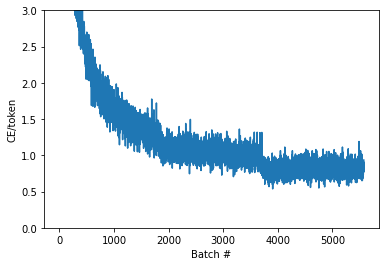

In [63]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

The visible jumps in the plot are at the epoch boundaries.

## Translate

Now that the model is trained, implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [64]:
class Translator(tf.Module):
  def __init__(self,
               encoder, decoder, 
               input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary())
    token_mask_ids = index_from_string(['',
                                        '[UNK]',
                                        '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string('[START]')
    self.end_token = index_from_string('[END]')

In [65]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

### Convert token IDs to text

The first method to implement is `tokens_to_text` which converts from token IDs to human readable text.

In [66]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [67]:
Translator.tokens_to_text = tokens_to_text

Input some random token IDs and see what it generates:

In [68]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'adult store', b'phoned doorknob', b'vegetable coast',
       b'observe explanation', b'blanket avoid'], dtype=object)

### Sample from the decoder's predictions

This function takes the decoder's logit outputs and samples token IDs from that distribution:

In [69]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [70]:
Translator.sample = sample

Test run this function on some random inputs:

In [71]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1607],
       [2497],
       [3862],
       [4653],
       [1229]])>

### Implement the translation loop

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using `tf.concat` to join them into tensors.

This implementation statically unrolls the graph out to `max_length` iterations.
This is okay with eager execution in python.

In [72]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [73]:
Translator.translate = translate_unrolled

Run it on a simple input:

In [74]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its been a cold ink here .
this is my life .

CPU times: user 165 ms, sys: 0 ns, total: 165 ms
Wall time: 159 ms


If you want to export this model you'll need to wrap this method in a `tf.function`. This basic implementation has a few issues if you try to do that:

1. The resulting graphs are very large and take a few seconds to build, save or load.
2. You can't break from a statically unrolled loop, so it will always run `max_length` iterations, even if all the outputs are done. But even then it's marginally faster than eager execution.


In [75]:
f = tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

Run the `tf.function` once to compile it:

In [76]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 151 ms, sys: 0 ns, total: 151 ms
Wall time: 146 ms


In [77]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its been very cold here .
this is my life .

CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 133 ms


In [78]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask = (input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [79]:
Translator.translate = translate_symbolic

The initial implementation used python lists to collect the outputs. This uses `tf.range` as the loop iterator, allowing `tf.autograph` to convert the loop. The biggest change in this implementation is the use of `tf.TensorArray` instead of python `list` to accumulate tensors. `tf.TensorArray` is required to collect a variable number of tensors in graph mode. 

With eager execution this implementation performs on par with the original:

In [80]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its a long cold here .
this is my life .

CPU times: user 154 ms, sys: 0 ns, total: 154 ms
Wall time: 148 ms


But when you wrap it in a `tf.function` you'll notice two differences.

In [81]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

First: Graph creation is much faster (~10x), since it doesn't create `max_iterations` copies of the model.

In [82]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.29 s


Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.

In [83]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it is really cold here .
this is my life .

CPU times: user 50.7 ms, sys: 0 ns, total: 50.7 ms
Wall time: 18.7 ms


### Visualize the process

The attention weights returned by the `translate` method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [84]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.         1.         0.9999999  0.99999994 1.         1.
 1.        ]


Here is the attention distribution for the first output step of the first example. Note how the attention is now much more focused than it was for the untrained model:

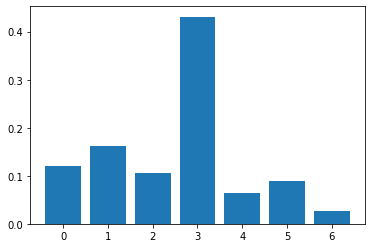

In [85]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

Since there is some rough alignment between the input and output words, you expect the attention to be focused near the diagonal:

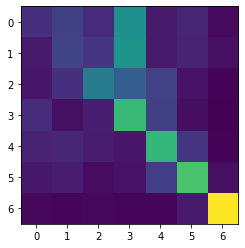

In [86]:
plt.imshow(np.array(a), vmin=0.0)

Here is some code to make a better attention plot:

In [87]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


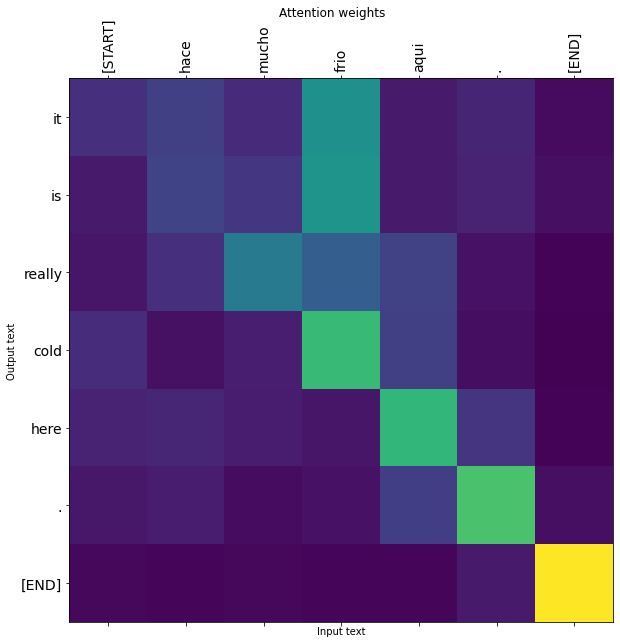

In [88]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

Translate a few more sentences and plot them:

In [89]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are you still at home ?
try it to discover .

CPU times: user 54.4 ms, sys: 52.1 ms, total: 107 ms
Wall time: 22.8 ms


In [90]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'this is my life .', b'are you still at home ?',
       b'try it to discover .'], dtype=object)>

/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


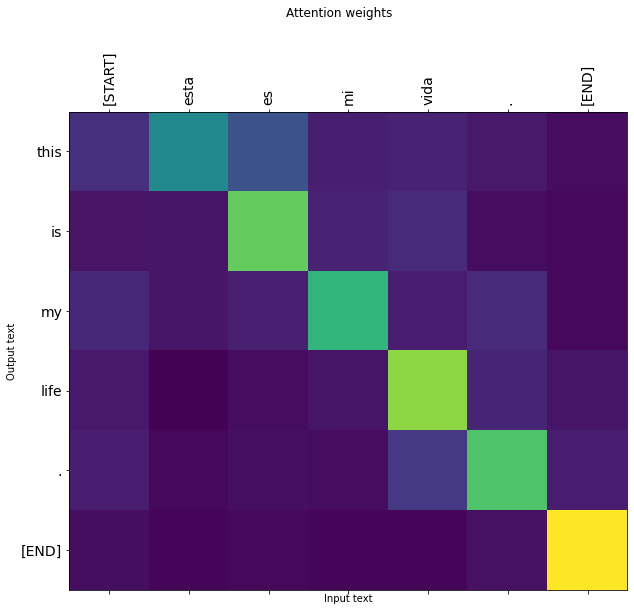

In [91]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


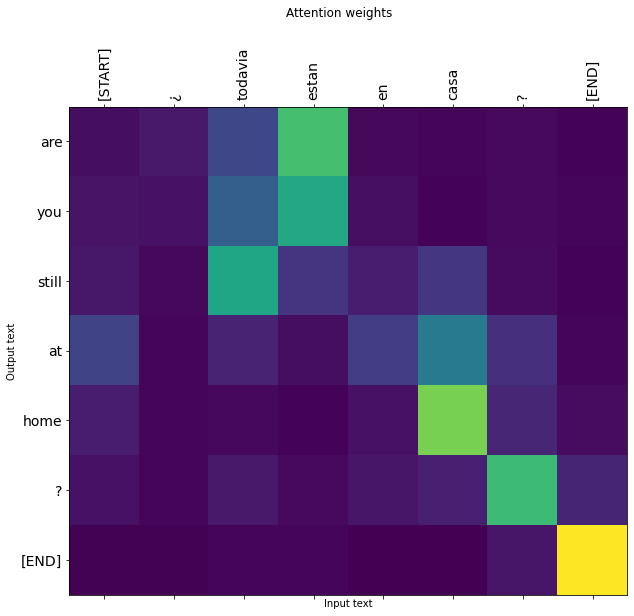

In [92]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


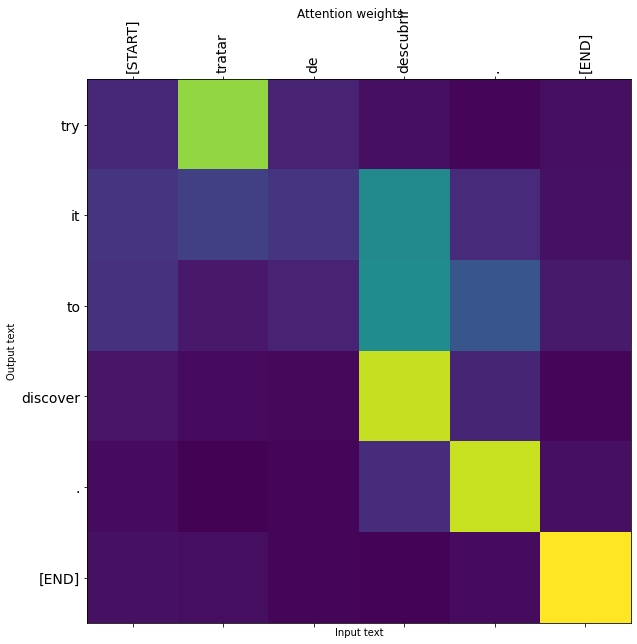

In [93]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. [Transformers](transformer.ipynb) solve this by using self-attention in the encoder and decoder.

In [94]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


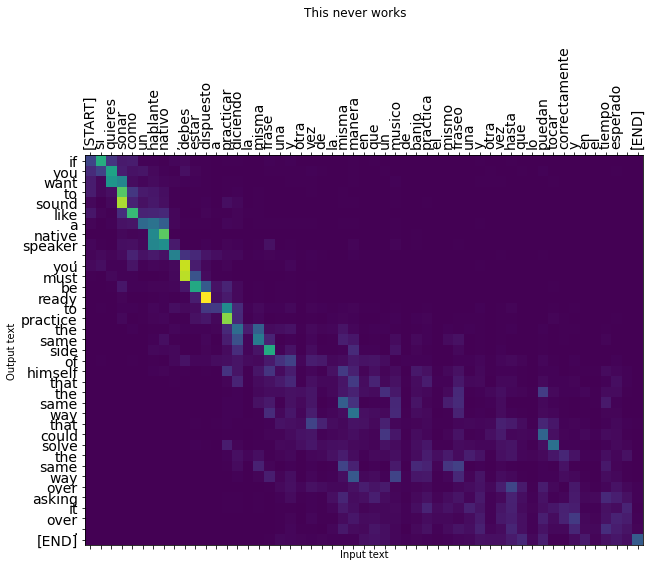

In [95]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

## Export

Once you have a model you're satisfied with you might want to export it as a `tf.saved_model` for use outside of this python program that created it.

Since the model is a subclass of `tf.Module` (through `keras.Model`), and all the functionality for export is compiled in a `tf.function` the model should export cleanly with `tf.saved_model.save`:  

Now that the function has been traced it can be exported using `saved_model.save`:

In [96]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [97]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [98]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are you still at home ?
try it under discover .

CPU times: user 39 ms, sys: 7.02 ms, total: 46 ms
Wall time: 19.5 ms


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses a transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement wordpiece tokenization.
* Have a look at the [tensorflow_addons.seq2seq](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt) for implementing this sort of sequence to sequence model. The `tfa.seq2seq` package includes higher level functionality like `seq2seq.BeamSearchDecoder`. 